In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(381944, 828)
(381944, 8)
validation
(50712, 828)
(50712, 8)
test
(50568, 828)
(50568, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/39 [..............................] - ETA: 49s - loss: 2.3408 - STD: 0.0851 - MAE: 0.2229

 4/39 [==>...........................] - ETA: 0s - loss: 1.7486 - STD: 0.1048 - MAE: 0.1914 

 5/39 [==>...........................] - ETA: 1s - loss: 1.6742 - STD: 0.1258 - MAE: 0.1813

 6/39 [===>..........................] - ETA: 1s - loss: 1.6276 - STD: 0.1438 - MAE: 0.1730

 7/39 [====>.........................] - ETA: 1s - loss: 1.5938 - STD: 0.1583 - MAE: 0.1662

 8/39 [=====>........................] - ETA: 1s - loss: 1.5693 - STD: 0.1697 - MAE: 0.1610

 9/39 [=====>........................] - ETA: 1s - loss: 1.5507 - STD: 0.1783 - MAE: 0.1570

10/39 [======>.......................] - ETA: 1s - loss: 1.5380 - STD: 0.1845 - MAE: 0.1542

11/39 [=======>......................] - ETA: 1s - loss: 1.5264 - STD: 0.1888 - MAE: 0.1523

12/39 [========>.....................] - ETA: 1s - loss: 1.5154 - STD: 0.1914 - MAE: 0.1510

13/39 [=========>....................] - ETA: 1s - loss: 1.5056 - STD: 0.1926 - MAE: 0.1502

14/39 [=========>....................] - ETA: 1s - loss: 1.4977 - STD: 0.1927 - MAE: 0.1500

15/39 [==========>...................] - ETA: 1s - loss: 1.4906 - STD: 0.1922 - MAE: 0.1500

16/39 [===========>..................] - ETA: 2s - loss: 1.4898 - STD: 0.1912 - MAE: 0.1503

20/39 [==============>...............] - ETA: 1s - loss: 1.4649 - STD: 0.1872 - MAE: 0.1512

21/39 [===============>..............] - ETA: 1s - loss: 1.4597 - STD: 0.1867 - MAE: 0.1512

22/39 [===============>..............] - ETA: 1s - loss: 1.4556 - STD: 0.1865 - MAE: 0.1512

23/39 [================>.............] - ETA: 1s - loss: 1.4513 - STD: 0.1865 - MAE: 0.1511

24/39 [=================>............] - ETA: 1s - loss: 1.4466 - STD: 0.1867 - MAE: 0.1509

25/39 [==================>...........] - ETA: 1s - loss: 1.4421 - STD: 0.1871 - MAE: 0.1507

26/39 [===================>..........] - ETA: 0s - loss: 1.4379 - STD: 0.1875 - MAE: 0.1504

27/39 [===================>..........] - ETA: 0s - loss: 1.4344 - STD: 0.1880 - MAE: 0.1501

28/39 [====================>.........] - ETA: 0s - loss: 1.4315 - STD: 0.1884 - MAE: 0.1499

29/39 [=====================>........] - ETA: 0s - loss: 1.4291 - STD: 0.1889 - MAE: 0.1497

30/39 [======================>.......] - ETA: 0s - loss: 1.4263 - STD: 0.1893 - MAE: 0.1495

31/39 [======================>.......] - ETA: 0s - loss: 1.4240 - STD: 0.1896 - MAE: 0.1493

32/39 [=======================>......] - ETA: 0s - loss: 1.4225 - STD: 0.1897 - MAE: 0.1492

33/39 [========================>.....] - ETA: 0s - loss: 1.4200 - STD: 0.1898 - MAE: 0.1491

34/39 [=========================>....] - ETA: 0s - loss: 1.4181 - STD: 0.1898 - MAE: 0.1491

35/39 [=========================>....] - ETA: 0s - loss: 1.4160 - STD: 0.1897 - MAE: 0.1491

36/39 [==========================>...] - ETA: 0s - loss: 1.4140 - STD: 0.1895 - MAE: 0.1491

37/39 [===========================>..] - ETA: 0s - loss: 1.4125 - STD: 0.1892 - MAE: 0.1492

38/39 [============================>.] - ETA: 0s - loss: 1.4106 - STD: 0.1889 - MAE: 0.1493

39/39 [==============================] - ETA: 0s - loss: 1.4091 - STD: 0.1887 - MAE: 0.1494

39/39 [==============================] - 5s 86ms/step - loss: 1.4091 - STD: 0.1887 - MAE: 0.1494 - val_loss: 1.3253 - val_STD: 0.1779 - val_MAE: 0.1474


Epoch 2/10000


 1/39 [..............................] - ETA: 3s - loss: 1.3424 - STD: 0.1779 - MAE: 0.1517

 2/39 [>.............................] - ETA: 2s - loss: 1.3409 - STD: 0.1784 - MAE: 0.1514

 3/39 [=>............................] - ETA: 2s - loss: 1.3477 - STD: 0.1792 - MAE: 0.1515

 4/39 [==>...........................] - ETA: 2s - loss: 1.3512 - STD: 0.1801 - MAE: 0.1514

 5/39 [==>...........................] - ETA: 2s - loss: 1.3504 - STD: 0.1810 - MAE: 0.1510

 6/39 [===>..........................] - ETA: 2s - loss: 1.3526 - STD: 0.1820 - MAE: 0.1508

 7/39 [====>.........................] - ETA: 2s - loss: 1.3521 - STD: 0.1830 - MAE: 0.1504

 8/39 [=====>........................] - ETA: 2s - loss: 1.3517 - STD: 0.1839 - MAE: 0.1501

 9/39 [=====>........................] - ETA: 1s - loss: 1.3509 - STD: 0.1847 - MAE: 0.1497

10/39 [======>.......................] - ETA: 1s - loss: 1.3489 - STD: 0.1854 - MAE: 0.1493

11/39 [=======>......................] - ETA: 1s - loss: 1.3513 - STD: 0.1860 - MAE: 0.1491

12/39 [========>.....................] - ETA: 1s - loss: 1.3508 - STD: 0.1865 - MAE: 0.1489

13/39 [=========>....................] - ETA: 1s - loss: 1.3510 - STD: 0.1869 - MAE: 0.1488

14/39 [=========>....................] - ETA: 1s - loss: 1.3493 - STD: 0.1872 - MAE: 0.1486

16/39 [===========>..................] - ETA: 1s - loss: 1.3497 - STD: 0.1875 - MAE: 0.1486

17/39 [============>.................] - ETA: 1s - loss: 1.3489 - STD: 0.1874 - MAE: 0.1486

18/39 [============>.................] - ETA: 1s - loss: 1.3480 - STD: 0.1873 - MAE: 0.1486

19/39 [=============>................] - ETA: 1s - loss: 1.3484 - STD: 0.1872 - MAE: 0.1486

20/39 [==============>...............] - ETA: 1s - loss: 1.3483 - STD: 0.1870 - MAE: 0.1487

21/39 [===============>..............] - ETA: 1s - loss: 1.3483 - STD: 0.1869 - MAE: 0.1487

22/39 [===============>..............] - ETA: 1s - loss: 1.3482 - STD: 0.1867 - MAE: 0.1488

23/39 [================>.............] - ETA: 0s - loss: 1.3474 - STD: 0.1867 - MAE: 0.1488

24/39 [=================>............] - ETA: 0s - loss: 1.3472 - STD: 0.1866 - MAE: 0.1488

25/39 [==================>...........] - ETA: 0s - loss: 1.3474 - STD: 0.1866 - MAE: 0.1488

26/39 [===================>..........] - ETA: 0s - loss: 1.3474 - STD: 0.1867 - MAE: 0.1488

27/39 [===================>..........] - ETA: 0s - loss: 1.3472 - STD: 0.1868 - MAE: 0.1487

28/39 [====================>.........] - ETA: 0s - loss: 1.3475 - STD: 0.1869 - MAE: 0.1487

29/39 [=====================>........] - ETA: 0s - loss: 1.3475 - STD: 0.1870 - MAE: 0.1487

30/39 [======================>.......] - ETA: 0s - loss: 1.3471 - STD: 0.1871 - MAE: 0.1486

31/39 [======================>.......] - ETA: 0s - loss: 1.3468 - STD: 0.1872 - MAE: 0.1486

32/39 [=======================>......] - ETA: 0s - loss: 1.3466 - STD: 0.1872 - MAE: 0.1485

33/39 [========================>.....] - ETA: 0s - loss: 1.3460 - STD: 0.1873 - MAE: 0.1485

34/39 [=========================>....] - ETA: 0s - loss: 1.3459 - STD: 0.1873 - MAE: 0.1485

35/39 [=========================>....] - ETA: 0s - loss: 1.3462 - STD: 0.1873 - MAE: 0.1485

36/39 [==========================>...] - ETA: 0s - loss: 1.3455 - STD: 0.1874 - MAE: 0.1484

37/39 [===========================>..] - ETA: 0s - loss: 1.3457 - STD: 0.1874 - MAE: 0.1484

38/39 [============================>.] - ETA: 0s - loss: 1.3455 - STD: 0.1874 - MAE: 0.1484

39/39 [==============================] - ETA: 0s - loss: 1.3453 - STD: 0.1873 - MAE: 0.1484

39/39 [==============================] - 3s 65ms/step - loss: 1.3453 - STD: 0.1873 - MAE: 0.1484 - val_loss: 1.3203 - val_STD: 0.1874 - val_MAE: 0.1436


Epoch 3/10000


 1/39 [..............................] - ETA: 3s - loss: 1.3252 - STD: 0.1874 - MAE: 0.1469

 2/39 [>.............................] - ETA: 2s - loss: 1.3342 - STD: 0.1878 - MAE: 0.1474

 3/39 [=>............................] - ETA: 2s - loss: 1.3457 - STD: 0.1882 - MAE: 0.1479

 4/39 [==>...........................] - ETA: 2s - loss: 1.3462 - STD: 0.1885 - MAE: 0.1479

 6/39 [===>..........................] - ETA: 1s - loss: 1.3430 - STD: 0.1888 - MAE: 0.1477

 7/39 [====>.........................] - ETA: 1s - loss: 1.3464 - STD: 0.1888 - MAE: 0.1478

 8/39 [=====>........................] - ETA: 1s - loss: 1.3446 - STD: 0.1888 - MAE: 0.1478

 9/39 [=====>........................] - ETA: 1s - loss: 1.3465 - STD: 0.1887 - MAE: 0.1479

10/39 [======>.......................] - ETA: 1s - loss: 1.3452 - STD: 0.1886 - MAE: 0.1479

11/39 [=======>......................] - ETA: 1s - loss: 1.3454 - STD: 0.1885 - MAE: 0.1479

12/39 [========>.....................] - ETA: 1s - loss: 1.3444 - STD: 0.1883 - MAE: 0.1479

13/39 [=========>....................] - ETA: 1s - loss: 1.3436 - STD: 0.1882 - MAE: 0.1479

14/39 [=========>....................] - ETA: 1s - loss: 1.3446 - STD: 0.1882 - MAE: 0.1480

15/39 [==========>...................] - ETA: 1s - loss: 1.3447 - STD: 0.1882 - MAE: 0.1480

16/39 [===========>..................] - ETA: 1s - loss: 1.3442 - STD: 0.1882 - MAE: 0.1480

17/39 [============>.................] - ETA: 1s - loss: 1.3444 - STD: 0.1882 - MAE: 0.1480

18/39 [============>.................] - ETA: 1s - loss: 1.3449 - STD: 0.1882 - MAE: 0.1480

19/39 [=============>................] - ETA: 1s - loss: 1.3452 - STD: 0.1882 - MAE: 0.1480

20/39 [==============>...............] - ETA: 1s - loss: 1.3457 - STD: 0.1882 - MAE: 0.1480

21/39 [===============>..............] - ETA: 1s - loss: 1.3459 - STD: 0.1882 - MAE: 0.1481

22/39 [===============>..............] - ETA: 1s - loss: 1.3460 - STD: 0.1881 - MAE: 0.1481

23/39 [================>.............] - ETA: 0s - loss: 1.3454 - STD: 0.1880 - MAE: 0.1481

24/39 [=================>............] - ETA: 0s - loss: 1.3461 - STD: 0.1879 - MAE: 0.1482

25/39 [==================>...........] - ETA: 0s - loss: 1.3457 - STD: 0.1878 - MAE: 0.1482

26/39 [===================>..........] - ETA: 0s - loss: 1.3454 - STD: 0.1877 - MAE: 0.1482

27/39 [===================>..........] - ETA: 0s - loss: 1.3455 - STD: 0.1877 - MAE: 0.1483

28/39 [====================>.........] - ETA: 0s - loss: 1.3451 - STD: 0.1876 - MAE: 0.1482

29/39 [=====================>........] - ETA: 0s - loss: 1.3456 - STD: 0.1876 - MAE: 0.1483

30/39 [======================>.......] - ETA: 0s - loss: 1.3459 - STD: 0.1877 - MAE: 0.1483

31/39 [======================>.......] - ETA: 0s - loss: 1.3451 - STD: 0.1877 - MAE: 0.1482

32/39 [=======================>......] - ETA: 0s - loss: 1.3455 - STD: 0.1878 - MAE: 0.1482

33/39 [========================>.....] - ETA: 0s - loss: 1.3455 - STD: 0.1878 - MAE: 0.1482

34/39 [=========================>....] - ETA: 0s - loss: 1.3454 - STD: 0.1878 - MAE: 0.1482

35/39 [=========================>....] - ETA: 0s - loss: 1.3447 - STD: 0.1879 - MAE: 0.1481

36/39 [==========================>...] - ETA: 0s - loss: 1.3444 - STD: 0.1879 - MAE: 0.1481

37/39 [===========================>..] - ETA: 0s - loss: 1.3442 - STD: 0.1879 - MAE: 0.1481

38/39 [============================>.] - ETA: 0s - loss: 1.3442 - STD: 0.1879 - MAE: 0.1481

39/39 [==============================] - ETA: 0s - loss: 1.3442 - STD: 0.1879 - MAE: 0.1481

39/39 [==============================] - 3s 65ms/step - loss: 1.3442 - STD: 0.1879 - MAE: 0.1481 - val_loss: 1.3193 - val_STD: 0.1882 - val_MAE: 0.1431


Epoch 4/10000


 1/39 [..............................] - ETA: 3s - loss: 1.3444 - STD: 0.1880 - MAE: 0.1481

 2/39 [>.............................] - ETA: 2s - loss: 1.3485 - STD: 0.1879 - MAE: 0.1483

 3/39 [=>............................] - ETA: 2s - loss: 1.3489 - STD: 0.1877 - MAE: 0.1484

 4/39 [==>...........................] - ETA: 2s - loss: 1.3520 - STD: 0.1876 - MAE: 0.1486

 5/39 [==>...........................] - ETA: 2s - loss: 1.3497 - STD: 0.1873 - MAE: 0.1486

 7/39 [====>.........................] - ETA: 1s - loss: 1.3486 - STD: 0.1871 - MAE: 0.1485

 8/39 [=====>........................] - ETA: 1s - loss: 1.3522 - STD: 0.1871 - MAE: 0.1487

 9/39 [=====>........................] - ETA: 1s - loss: 1.3511 - STD: 0.1871 - MAE: 0.1487

10/39 [======>.......................] - ETA: 1s - loss: 1.3476 - STD: 0.1870 - MAE: 0.1485

11/39 [=======>......................] - ETA: 1s - loss: 1.3479 - STD: 0.1871 - MAE: 0.1485

12/39 [========>.....................] - ETA: 1s - loss: 1.3485 - STD: 0.1871 - MAE: 0.1486

13/39 [=========>....................] - ETA: 1s - loss: 1.3485 - STD: 0.1871 - MAE: 0.1486

14/39 [=========>....................] - ETA: 1s - loss: 1.3486 - STD: 0.1871 - MAE: 0.1486

15/39 [==========>...................] - ETA: 1s - loss: 1.3504 - STD: 0.1870 - MAE: 0.1487

16/39 [===========>..................] - ETA: 1s - loss: 1.3496 - STD: 0.1869 - MAE: 0.1487

17/39 [============>.................] - ETA: 1s - loss: 1.3494 - STD: 0.1867 - MAE: 0.1488

18/39 [============>.................] - ETA: 1s - loss: 1.3476 - STD: 0.1866 - MAE: 0.1487

19/39 [=============>................] - ETA: 1s - loss: 1.3462 - STD: 0.1865 - MAE: 0.1487

20/39 [==============>...............] - ETA: 1s - loss: 1.3465 - STD: 0.1865 - MAE: 0.1487

21/39 [===============>..............] - ETA: 1s - loss: 1.3455 - STD: 0.1866 - MAE: 0.1486

22/39 [===============>..............] - ETA: 1s - loss: 1.3448 - STD: 0.1866 - MAE: 0.1486

23/39 [================>.............] - ETA: 0s - loss: 1.3442 - STD: 0.1868 - MAE: 0.1485

24/39 [=================>............] - ETA: 0s - loss: 1.3437 - STD: 0.1869 - MAE: 0.1484

25/39 [==================>...........] - ETA: 0s - loss: 1.3432 - STD: 0.1870 - MAE: 0.1483

26/39 [===================>..........] - ETA: 0s - loss: 1.3422 - STD: 0.1872 - MAE: 0.1482

27/39 [===================>..........] - ETA: 0s - loss: 1.3415 - STD: 0.1873 - MAE: 0.1481

28/39 [====================>.........] - ETA: 0s - loss: 1.3413 - STD: 0.1874 - MAE: 0.1481

29/39 [=====================>........] - ETA: 0s - loss: 1.3407 - STD: 0.1875 - MAE: 0.1480

30/39 [======================>.......] - ETA: 0s - loss: 1.3398 - STD: 0.1875 - MAE: 0.1480

31/39 [======================>.......] - ETA: 0s - loss: 1.3393 - STD: 0.1875 - MAE: 0.1479

32/39 [=======================>......] - ETA: 0s - loss: 1.3389 - STD: 0.1875 - MAE: 0.1479

33/39 [========================>.....] - ETA: 0s - loss: 1.3383 - STD: 0.1875 - MAE: 0.1479

34/39 [=========================>....] - ETA: 0s - loss: 1.3372 - STD: 0.1875 - MAE: 0.1478

35/39 [=========================>....] - ETA: 0s - loss: 1.3371 - STD: 0.1876 - MAE: 0.1478

36/39 [==========================>...] - ETA: 0s - loss: 1.3370 - STD: 0.1876 - MAE: 0.1478

37/39 [===========================>..] - ETA: 0s - loss: 1.3369 - STD: 0.1876 - MAE: 0.1478

38/39 [============================>.] - ETA: 0s - loss: 1.3365 - STD: 0.1876 - MAE: 0.1477

39/39 [==============================] - ETA: 0s - loss: 1.3363 - STD: 0.1876 - MAE: 0.1477

39/39 [==============================] - 3s 64ms/step - loss: 1.3363 - STD: 0.1876 - MAE: 0.1477 - val_loss: 1.2995 - val_STD: 0.1908 - val_MAE: 0.1404


Epoch 5/10000


 1/39 [..............................] - ETA: 3s - loss: 1.3180 - STD: 0.1871 - MAE: 0.1470

 2/39 [>.............................] - ETA: 2s - loss: 1.3244 - STD: 0.1873 - MAE: 0.1471

 3/39 [=>............................] - ETA: 2s - loss: 1.3199 - STD: 0.1874 - MAE: 0.1468

 5/39 [==>...........................] - ETA: 1s - loss: 1.3188 - STD: 0.1880 - MAE: 0.1464

 6/39 [===>..........................] - ETA: 1s - loss: 1.3174 - STD: 0.1882 - MAE: 0.1463

 7/39 [====>.........................] - ETA: 1s - loss: 1.3164 - STD: 0.1881 - MAE: 0.1463

 8/39 [=====>........................] - ETA: 1s - loss: 1.3162 - STD: 0.1878 - MAE: 0.1464

 9/39 [=====>........................] - ETA: 1s - loss: 1.3141 - STD: 0.1876 - MAE: 0.1464

10/39 [======>.......................] - ETA: 1s - loss: 1.3141 - STD: 0.1877 - MAE: 0.1463

11/39 [=======>......................] - ETA: 1s - loss: 1.3120 - STD: 0.1881 - MAE: 0.1461

12/39 [========>.....................] - ETA: 1s - loss: 1.3109 - STD: 0.1885 - MAE: 0.1459

13/39 [=========>....................] - ETA: 1s - loss: 1.3106 - STD: 0.1888 - MAE: 0.1458

14/39 [=========>....................] - ETA: 1s - loss: 1.3111 - STD: 0.1888 - MAE: 0.1458

15/39 [==========>...................] - ETA: 1s - loss: 1.3116 - STD: 0.1886 - MAE: 0.1459

16/39 [===========>..................] - ETA: 1s - loss: 1.3107 - STD: 0.1884 - MAE: 0.1459

17/39 [============>.................] - ETA: 1s - loss: 1.3096 - STD: 0.1885 - MAE: 0.1459

18/39 [============>.................] - ETA: 1s - loss: 1.3083 - STD: 0.1889 - MAE: 0.1456

19/39 [=============>................] - ETA: 1s - loss: 1.3070 - STD: 0.1893 - MAE: 0.1454

20/39 [==============>...............] - ETA: 1s - loss: 1.3056 - STD: 0.1893 - MAE: 0.1453

21/39 [===============>..............] - ETA: 1s - loss: 1.3057 - STD: 0.1892 - MAE: 0.1454

22/39 [===============>..............] - ETA: 1s - loss: 1.3040 - STD: 0.1890 - MAE: 0.1454

23/39 [================>.............] - ETA: 0s - loss: 1.3036 - STD: 0.1892 - MAE: 0.1453

24/39 [=================>............] - ETA: 0s - loss: 1.3034 - STD: 0.1896 - MAE: 0.1452

25/39 [==================>...........] - ETA: 0s - loss: 1.3037 - STD: 0.1897 - MAE: 0.1451

26/39 [===================>..........] - ETA: 0s - loss: 1.3024 - STD: 0.1896 - MAE: 0.1451

27/39 [===================>..........] - ETA: 0s - loss: 1.3017 - STD: 0.1896 - MAE: 0.1451

28/39 [====================>.........] - ETA: 0s - loss: 1.3012 - STD: 0.1899 - MAE: 0.1450

29/39 [=====================>........] - ETA: 0s - loss: 1.3003 - STD: 0.1901 - MAE: 0.1448

30/39 [======================>.......] - ETA: 0s - loss: 1.2994 - STD: 0.1902 - MAE: 0.1448

31/39 [======================>.......] - ETA: 0s - loss: 1.2982 - STD: 0.1901 - MAE: 0.1448

32/39 [=======================>......] - ETA: 0s - loss: 1.2976 - STD: 0.1902 - MAE: 0.1447

33/39 [========================>.....] - ETA: 0s - loss: 1.2971 - STD: 0.1904 - MAE: 0.1446

34/39 [=========================>....] - ETA: 0s - loss: 1.2969 - STD: 0.1905 - MAE: 0.1446

35/39 [=========================>....] - ETA: 0s - loss: 1.2962 - STD: 0.1905 - MAE: 0.1446

36/39 [==========================>...] - ETA: 0s - loss: 1.2952 - STD: 0.1906 - MAE: 0.1445

37/39 [===========================>..] - ETA: 0s - loss: 1.2938 - STD: 0.1909 - MAE: 0.1443

38/39 [============================>.] - ETA: 0s - loss: 1.2924 - STD: 0.1911 - MAE: 0.1442

39/39 [==============================] - ETA: 0s - loss: 1.2916 - STD: 0.1910 - MAE: 0.1442

39/39 [==============================] - 3s 66ms/step - loss: 1.2916 - STD: 0.1910 - MAE: 0.1442 - val_loss: 1.2502 - val_STD: 0.2109 - val_MAE: 0.1296


Epoch 6/10000


 1/39 [..............................] - ETA: 3s - loss: 1.2275 - STD: 0.1964 - MAE: 0.1392

 2/39 [>.............................] - ETA: 2s - loss: 1.2403 - STD: 0.2013 - MAE: 0.1381

 3/39 [=>............................] - ETA: 2s - loss: 1.2453 - STD: 0.1983 - MAE: 0.1396

 4/39 [==>...........................] - ETA: 2s - loss: 1.2490 - STD: 0.1954 - MAE: 0.1410

 5/39 [==>...........................] - ETA: 2s - loss: 1.2455 - STD: 0.1963 - MAE: 0.1406

 6/39 [===>..........................] - ETA: 2s - loss: 1.2423 - STD: 0.1976 - MAE: 0.1399

 7/39 [====>.........................] - ETA: 1s - loss: 1.2398 - STD: 0.1969 - MAE: 0.1400

 8/39 [=====>........................] - ETA: 1s - loss: 1.2391 - STD: 0.1960 - MAE: 0.1403

 9/39 [=====>........................] - ETA: 1s - loss: 1.2402 - STD: 0.1967 - MAE: 0.1401

10/39 [======>.......................] - ETA: 1s - loss: 1.2396 - STD: 0.1970 - MAE: 0.1400

11/39 [=======>......................] - ETA: 1s - loss: 1.2358 - STD: 0.1968 - MAE: 0.1399

12/39 [========>.....................] - ETA: 1s - loss: 1.2345 - STD: 0.1974 - MAE: 0.1397

13/39 [=========>....................] - ETA: 1s - loss: 1.2326 - STD: 0.1975 - MAE: 0.1396

14/39 [=========>....................] - ETA: 1s - loss: 1.2307 - STD: 0.1972 - MAE: 0.1396

15/39 [==========>...................] - ETA: 1s - loss: 1.2303 - STD: 0.1975 - MAE: 0.1395

16/39 [===========>..................] - ETA: 1s - loss: 1.2295 - STD: 0.1976 - MAE: 0.1395

17/39 [============>.................] - ETA: 1s - loss: 1.2283 - STD: 0.1972 - MAE: 0.1396

18/39 [============>.................] - ETA: 1s - loss: 1.2263 - STD: 0.1976 - MAE: 0.1394

19/39 [=============>................] - ETA: 1s - loss: 1.2252 - STD: 0.1980 - MAE: 0.1392

20/39 [==============>...............] - ETA: 1s - loss: 1.2238 - STD: 0.1975 - MAE: 0.1393

22/39 [===============>..............] - ETA: 0s - loss: 1.2226 - STD: 0.1979 - MAE: 0.1392

23/39 [================>.............] - ETA: 0s - loss: 1.2207 - STD: 0.1978 - MAE: 0.1392

24/39 [=================>............] - ETA: 0s - loss: 1.2207 - STD: 0.1981 - MAE: 0.1391

25/39 [==================>...........] - ETA: 0s - loss: 1.2196 - STD: 0.1981 - MAE: 0.1391

26/39 [===================>..........] - ETA: 0s - loss: 1.2190 - STD: 0.1979 - MAE: 0.1392

27/39 [===================>..........] - ETA: 0s - loss: 1.2181 - STD: 0.1981 - MAE: 0.1391

28/39 [====================>.........] - ETA: 0s - loss: 1.2169 - STD: 0.1980 - MAE: 0.1391

29/39 [=====================>........] - ETA: 0s - loss: 1.2156 - STD: 0.1979 - MAE: 0.1391

30/39 [======================>.......] - ETA: 0s - loss: 1.2140 - STD: 0.1982 - MAE: 0.1389

31/39 [======================>.......] - ETA: 0s - loss: 1.2125 - STD: 0.1982 - MAE: 0.1389

32/39 [=======================>......] - ETA: 0s - loss: 1.2112 - STD: 0.1983 - MAE: 0.1388

33/39 [========================>.....] - ETA: 0s - loss: 1.2100 - STD: 0.1986 - MAE: 0.1387

34/39 [=========================>....] - ETA: 0s - loss: 1.2094 - STD: 0.1987 - MAE: 0.1386

35/39 [=========================>....] - ETA: 0s - loss: 1.2085 - STD: 0.1984 - MAE: 0.1387

36/39 [==========================>...] - ETA: 0s - loss: 1.2072 - STD: 0.1985 - MAE: 0.1387

37/39 [===========================>..] - ETA: 0s - loss: 1.2064 - STD: 0.1986 - MAE: 0.1386

38/39 [============================>.] - ETA: 0s - loss: 1.2054 - STD: 0.1984 - MAE: 0.1387

39/39 [==============================] - ETA: 0s - loss: 1.2041 - STD: 0.1985 - MAE: 0.1386

39/39 [==============================] - 3s 64ms/step - loss: 1.2041 - STD: 0.1985 - MAE: 0.1386 - val_loss: 1.2148 - val_STD: 0.2246 - val_MAE: 0.1231


Epoch 7/10000


 1/39 [..............................] - ETA: 3s - loss: 1.1657 - STD: 0.2116 - MAE: 0.1322

 2/39 [>.............................] - ETA: 2s - loss: 1.1480 - STD: 0.2060 - MAE: 0.1337

 3/39 [=>............................] - ETA: 2s - loss: 1.1549 - STD: 0.2029 - MAE: 0.1354

 4/39 [==>...........................] - ETA: 2s - loss: 1.1560 - STD: 0.2031 - MAE: 0.1355

 5/39 [==>...........................] - ETA: 2s - loss: 1.1569 - STD: 0.2021 - MAE: 0.1359

 6/39 [===>..........................] - ETA: 2s - loss: 1.1584 - STD: 0.2005 - MAE: 0.1367

 7/39 [====>.........................] - ETA: 1s - loss: 1.1575 - STD: 0.1999 - MAE: 0.1369

 8/39 [=====>........................] - ETA: 1s - loss: 1.1546 - STD: 0.2008 - MAE: 0.1364

 9/39 [=====>........................] - ETA: 1s - loss: 1.1523 - STD: 0.2016 - MAE: 0.1359

10/39 [======>.......................] - ETA: 1s - loss: 1.1517 - STD: 0.2017 - MAE: 0.1359

11/39 [=======>......................] - ETA: 1s - loss: 1.1501 - STD: 0.2015 - MAE: 0.1359

12/39 [========>.....................] - ETA: 1s - loss: 1.1487 - STD: 0.2016 - MAE: 0.1359

13/39 [=========>....................] - ETA: 1s - loss: 1.1472 - STD: 0.2011 - MAE: 0.1360

14/39 [=========>....................] - ETA: 1s - loss: 1.1458 - STD: 0.2008 - MAE: 0.1361

15/39 [==========>...................] - ETA: 1s - loss: 1.1446 - STD: 0.2012 - MAE: 0.1358

16/39 [===========>..................] - ETA: 1s - loss: 1.1426 - STD: 0.2015 - MAE: 0.1356

17/39 [============>.................] - ETA: 1s - loss: 1.1414 - STD: 0.2015 - MAE: 0.1356

18/39 [============>.................] - ETA: 1s - loss: 1.1401 - STD: 0.2016 - MAE: 0.1355

19/39 [=============>................] - ETA: 1s - loss: 1.1389 - STD: 0.2016 - MAE: 0.1355

20/39 [==============>...............] - ETA: 1s - loss: 1.1374 - STD: 0.2014 - MAE: 0.1355

21/39 [===============>..............] - ETA: 1s - loss: 1.1360 - STD: 0.2014 - MAE: 0.1355

22/39 [===============>..............] - ETA: 1s - loss: 1.1354 - STD: 0.2016 - MAE: 0.1354

23/39 [================>.............] - ETA: 1s - loss: 1.1343 - STD: 0.2017 - MAE: 0.1354

24/39 [=================>............] - ETA: 0s - loss: 1.1334 - STD: 0.2015 - MAE: 0.1355

25/39 [==================>...........] - ETA: 0s - loss: 1.1326 - STD: 0.2015 - MAE: 0.1355

26/39 [===================>..........] - ETA: 0s - loss: 1.1307 - STD: 0.2015 - MAE: 0.1353

27/39 [===================>..........] - ETA: 0s - loss: 1.1282 - STD: 0.2018 - MAE: 0.1351

28/39 [====================>.........] - ETA: 0s - loss: 1.1268 - STD: 0.2021 - MAE: 0.1350

30/39 [======================>.......] - ETA: 0s - loss: 1.1253 - STD: 0.2020 - MAE: 0.1349

31/39 [======================>.......] - ETA: 0s - loss: 1.1237 - STD: 0.2022 - MAE: 0.1348

32/39 [=======================>......] - ETA: 0s - loss: 1.1220 - STD: 0.2025 - MAE: 0.1346

33/39 [========================>.....] - ETA: 0s - loss: 1.1212 - STD: 0.2026 - MAE: 0.1345

34/39 [=========================>....] - ETA: 0s - loss: 1.1196 - STD: 0.2026 - MAE: 0.1344

35/39 [=========================>....] - ETA: 0s - loss: 1.1183 - STD: 0.2028 - MAE: 0.1343

36/39 [==========================>...] - ETA: 0s - loss: 1.1167 - STD: 0.2028 - MAE: 0.1343

37/39 [===========================>..] - ETA: 0s - loss: 1.1151 - STD: 0.2029 - MAE: 0.1342

38/39 [============================>.] - ETA: 0s - loss: 1.1139 - STD: 0.2030 - MAE: 0.1341

39/39 [==============================] - ETA: 0s - loss: 1.1127 - STD: 0.2031 - MAE: 0.1340

39/39 [==============================] - 3s 65ms/step - loss: 1.1127 - STD: 0.2031 - MAE: 0.1340 - val_loss: 1.1094 - val_STD: 0.2164 - val_MAE: 0.1224


Epoch 8/10000


 1/39 [..............................] - ETA: 3s - loss: 1.0466 - STD: 0.2051 - MAE: 0.1309

 2/39 [>.............................] - ETA: 2s - loss: 1.0523 - STD: 0.2091 - MAE: 0.1296

 3/39 [=>............................] - ETA: 2s - loss: 1.0502 - STD: 0.2092 - MAE: 0.1294

 4/39 [==>...........................] - ETA: 2s - loss: 1.0549 - STD: 0.2073 - MAE: 0.1304

 5/39 [==>...........................] - ETA: 2s - loss: 1.0543 - STD: 0.2072 - MAE: 0.1304

 6/39 [===>..........................] - ETA: 2s - loss: 1.0553 - STD: 0.2081 - MAE: 0.1300

 7/39 [====>.........................] - ETA: 2s - loss: 1.0537 - STD: 0.2077 - MAE: 0.1301

 8/39 [=====>........................] - ETA: 1s - loss: 1.0536 - STD: 0.2075 - MAE: 0.1301

 9/39 [=====>........................] - ETA: 1s - loss: 1.0538 - STD: 0.2078 - MAE: 0.1301

10/39 [======>.......................] - ETA: 1s - loss: 1.0550 - STD: 0.2082 - MAE: 0.1300

11/39 [=======>......................] - ETA: 1s - loss: 1.0540 - STD: 0.2079 - MAE: 0.1301

12/39 [========>.....................] - ETA: 1s - loss: 1.0529 - STD: 0.2081 - MAE: 0.1299

13/39 [=========>....................] - ETA: 1s - loss: 1.0519 - STD: 0.2082 - MAE: 0.1298

14/39 [=========>....................] - ETA: 1s - loss: 1.0507 - STD: 0.2080 - MAE: 0.1298

15/39 [==========>...................] - ETA: 1s - loss: 1.0501 - STD: 0.2082 - MAE: 0.1297

16/39 [===========>..................] - ETA: 1s - loss: 1.0486 - STD: 0.2085 - MAE: 0.1296

17/39 [============>.................] - ETA: 1s - loss: 1.0476 - STD: 0.2086 - MAE: 0.1295

19/39 [=============>................] - ETA: 1s - loss: 1.0474 - STD: 0.2081 - MAE: 0.1297

20/39 [==============>...............] - ETA: 1s - loss: 1.0464 - STD: 0.2086 - MAE: 0.1295

21/39 [===============>..............] - ETA: 1s - loss: 1.0453 - STD: 0.2087 - MAE: 0.1294

22/39 [===============>..............] - ETA: 1s - loss: 1.0445 - STD: 0.2084 - MAE: 0.1295

23/39 [================>.............] - ETA: 0s - loss: 1.0435 - STD: 0.2089 - MAE: 0.1292

24/39 [=================>............] - ETA: 0s - loss: 1.0419 - STD: 0.2087 - MAE: 0.1292

25/39 [==================>...........] - ETA: 0s - loss: 1.0411 - STD: 0.2088 - MAE: 0.1292

26/39 [===================>..........] - ETA: 0s - loss: 1.0400 - STD: 0.2090 - MAE: 0.1290

27/39 [===================>..........] - ETA: 0s - loss: 1.0391 - STD: 0.2090 - MAE: 0.1290

28/39 [====================>.........] - ETA: 0s - loss: 1.0380 - STD: 0.2092 - MAE: 0.1289

29/39 [=====================>........] - ETA: 0s - loss: 1.0366 - STD: 0.2094 - MAE: 0.1287

30/39 [======================>.......] - ETA: 0s - loss: 1.0355 - STD: 0.2094 - MAE: 0.1287

31/39 [======================>.......] - ETA: 0s - loss: 1.0338 - STD: 0.2096 - MAE: 0.1285

32/39 [=======================>......] - ETA: 0s - loss: 1.0327 - STD: 0.2097 - MAE: 0.1284

33/39 [========================>.....] - ETA: 0s - loss: 1.0319 - STD: 0.2096 - MAE: 0.1284

34/39 [=========================>....] - ETA: 0s - loss: 1.0308 - STD: 0.2098 - MAE: 0.1283

35/39 [=========================>....] - ETA: 0s - loss: 1.0297 - STD: 0.2099 - MAE: 0.1282

36/39 [==========================>...] - ETA: 0s - loss: 1.0287 - STD: 0.2100 - MAE: 0.1281

37/39 [===========================>..] - ETA: 0s - loss: 1.0279 - STD: 0.2102 - MAE: 0.1280

38/39 [============================>.] - ETA: 0s - loss: 1.0268 - STD: 0.2100 - MAE: 0.1280

39/39 [==============================] - ETA: 0s - loss: 1.0262 - STD: 0.2105 - MAE: 0.1278

39/39 [==============================] - 3s 65ms/step - loss: 1.0262 - STD: 0.2105 - MAE: 0.1278 - val_loss: 1.0607 - val_STD: 0.2090 - val_MAE: 0.1231


Epoch 9/10000


 1/39 [..............................] - ETA: 3s - loss: 0.9977 - STD: 0.1988 - MAE: 0.1315

 2/39 [>.............................] - ETA: 2s - loss: 0.9845 - STD: 0.2115 - MAE: 0.1254

 3/39 [=>............................] - ETA: 2s - loss: 0.9844 - STD: 0.2154 - MAE: 0.1236

 4/39 [==>...........................] - ETA: 2s - loss: 0.9859 - STD: 0.2108 - MAE: 0.1256

 5/39 [==>...........................] - ETA: 2s - loss: 0.9867 - STD: 0.2133 - MAE: 0.1246

 6/39 [===>..........................] - ETA: 2s - loss: 0.9864 - STD: 0.2150 - MAE: 0.1239

 7/39 [====>.........................] - ETA: 1s - loss: 0.9878 - STD: 0.2128 - MAE: 0.1250

 8/39 [=====>........................] - ETA: 1s - loss: 0.9841 - STD: 0.2134 - MAE: 0.1245

 9/39 [=====>........................] - ETA: 1s - loss: 0.9870 - STD: 0.2158 - MAE: 0.1237

11/39 [=======>......................] - ETA: 1s - loss: 0.9871 - STD: 0.2126 - MAE: 0.1251

12/39 [========>.....................] - ETA: 1s - loss: 0.9870 - STD: 0.2145 - MAE: 0.1243

13/39 [=========>....................] - ETA: 1s - loss: 0.9845 - STD: 0.2157 - MAE: 0.1237

14/39 [=========>....................] - ETA: 1s - loss: 0.9841 - STD: 0.2147 - MAE: 0.1241

15/39 [==========>...................] - ETA: 1s - loss: 0.9836 - STD: 0.2139 - MAE: 0.1244

16/39 [===========>..................] - ETA: 1s - loss: 0.9833 - STD: 0.2146 - MAE: 0.1241

17/39 [============>.................] - ETA: 1s - loss: 0.9833 - STD: 0.2153 - MAE: 0.1238

18/39 [============>.................] - ETA: 1s - loss: 0.9821 - STD: 0.2150 - MAE: 0.1239

19/39 [=============>................] - ETA: 1s - loss: 0.9812 - STD: 0.2147 - MAE: 0.1240

20/39 [==============>...............] - ETA: 1s - loss: 0.9802 - STD: 0.2151 - MAE: 0.1238

21/39 [===============>..............] - ETA: 1s - loss: 0.9802 - STD: 0.2155 - MAE: 0.1236

22/39 [===============>..............] - ETA: 1s - loss: 0.9788 - STD: 0.2152 - MAE: 0.1237

23/39 [================>.............] - ETA: 0s - loss: 0.9781 - STD: 0.2151 - MAE: 0.1237

24/39 [=================>............] - ETA: 0s - loss: 0.9773 - STD: 0.2156 - MAE: 0.1235

25/39 [==================>...........] - ETA: 0s - loss: 0.9766 - STD: 0.2158 - MAE: 0.1234

26/39 [===================>..........] - ETA: 0s - loss: 0.9756 - STD: 0.2155 - MAE: 0.1234

27/39 [===================>..........] - ETA: 0s - loss: 0.9748 - STD: 0.2155 - MAE: 0.1234

28/39 [====================>.........] - ETA: 0s - loss: 0.9742 - STD: 0.2158 - MAE: 0.1233

29/39 [=====================>........] - ETA: 0s - loss: 0.9732 - STD: 0.2160 - MAE: 0.1231

30/39 [======================>.......] - ETA: 0s - loss: 0.9720 - STD: 0.2160 - MAE: 0.1231

31/39 [======================>.......] - ETA: 0s - loss: 0.9711 - STD: 0.2160 - MAE: 0.1230

32/39 [=======================>......] - ETA: 0s - loss: 0.9696 - STD: 0.2163 - MAE: 0.1228

33/39 [========================>.....] - ETA: 0s - loss: 0.9685 - STD: 0.2164 - MAE: 0.1227

34/39 [=========================>....] - ETA: 0s - loss: 0.9675 - STD: 0.2165 - MAE: 0.1226

35/39 [=========================>....] - ETA: 0s - loss: 0.9667 - STD: 0.2167 - MAE: 0.1225

36/39 [==========================>...] - ETA: 0s - loss: 0.9655 - STD: 0.2167 - MAE: 0.1225

37/39 [===========================>..] - ETA: 0s - loss: 0.9643 - STD: 0.2169 - MAE: 0.1223

38/39 [============================>.] - ETA: 0s - loss: 0.9631 - STD: 0.2171 - MAE: 0.1222

39/39 [==============================] - ETA: 0s - loss: 0.9625 - STD: 0.2171 - MAE: 0.1221

39/39 [==============================] - 3s 65ms/step - loss: 0.9625 - STD: 0.2171 - MAE: 0.1221 - val_loss: 1.0040 - val_STD: 0.2243 - val_MAE: 0.1139


Epoch 10/10000


 1/39 [..............................] - ETA: 3s - loss: 0.9254 - STD: 0.2152 - MAE: 0.1212

 2/39 [>.............................] - ETA: 2s - loss: 0.9223 - STD: 0.2209 - MAE: 0.1186

 3/39 [=>............................] - ETA: 2s - loss: 0.9279 - STD: 0.2224 - MAE: 0.1183

 4/39 [==>...........................] - ETA: 2s - loss: 0.9287 - STD: 0.2192 - MAE: 0.1196

 5/39 [==>...........................] - ETA: 2s - loss: 0.9257 - STD: 0.2206 - MAE: 0.1189

 6/39 [===>..........................] - ETA: 2s - loss: 0.9248 - STD: 0.2223 - MAE: 0.1181

 7/39 [====>.........................] - ETA: 1s - loss: 0.9247 - STD: 0.2213 - MAE: 0.1185

 8/39 [=====>........................] - ETA: 1s - loss: 0.9246 - STD: 0.2210 - MAE: 0.1186

 9/39 [=====>........................] - ETA: 1s - loss: 0.9238 - STD: 0.2219 - MAE: 0.1182

10/39 [======>.......................] - ETA: 1s - loss: 0.9235 - STD: 0.2221 - MAE: 0.1181

11/39 [=======>......................] - ETA: 1s - loss: 0.9239 - STD: 0.2214 - MAE: 0.1184

12/39 [========>.....................] - ETA: 1s - loss: 0.9246 - STD: 0.2217 - MAE: 0.1184

13/39 [=========>....................] - ETA: 1s - loss: 0.9233 - STD: 0.2217 - MAE: 0.1183

14/39 [=========>....................] - ETA: 1s - loss: 0.9227 - STD: 0.2217 - MAE: 0.1183

15/39 [==========>...................] - ETA: 1s - loss: 0.9211 - STD: 0.2218 - MAE: 0.1182

16/39 [===========>..................] - ETA: 1s - loss: 0.9202 - STD: 0.2221 - MAE: 0.1180

17/39 [============>.................] - ETA: 1s - loss: 0.9200 - STD: 0.2221 - MAE: 0.1180

18/39 [============>.................] - ETA: 1s - loss: 0.9189 - STD: 0.2221 - MAE: 0.1179

19/39 [=============>................] - ETA: 1s - loss: 0.9191 - STD: 0.2222 - MAE: 0.1179

20/39 [==============>...............] - ETA: 1s - loss: 0.9192 - STD: 0.2221 - MAE: 0.1179

21/39 [===============>..............] - ETA: 1s - loss: 0.9186 - STD: 0.2224 - MAE: 0.1178

22/39 [===============>..............] - ETA: 1s - loss: 0.9189 - STD: 0.2223 - MAE: 0.1179

23/39 [================>.............] - ETA: 0s - loss: 0.9179 - STD: 0.2221 - MAE: 0.1179

24/39 [=================>............] - ETA: 0s - loss: 0.9178 - STD: 0.2226 - MAE: 0.1177

25/39 [==================>...........] - ETA: 0s - loss: 0.9171 - STD: 0.2226 - MAE: 0.1176

26/39 [===================>..........] - ETA: 0s - loss: 0.9168 - STD: 0.2224 - MAE: 0.1177

27/39 [===================>..........] - ETA: 0s - loss: 0.9169 - STD: 0.2227 - MAE: 0.1176

28/39 [====================>.........] - ETA: 0s - loss: 0.9157 - STD: 0.2227 - MAE: 0.1175

29/39 [=====================>........] - ETA: 0s - loss: 0.9153 - STD: 0.2227 - MAE: 0.1175

30/39 [======================>.......] - ETA: 0s - loss: 0.9151 - STD: 0.2228 - MAE: 0.1175

31/39 [======================>.......] - ETA: 0s - loss: 0.9146 - STD: 0.2229 - MAE: 0.1174

32/39 [=======================>......] - ETA: 0s - loss: 0.9146 - STD: 0.2228 - MAE: 0.1174

33/39 [========================>.....] - ETA: 0s - loss: 0.9140 - STD: 0.2229 - MAE: 0.1174

34/39 [=========================>....] - ETA: 0s - loss: 0.9141 - STD: 0.2230 - MAE: 0.1173

35/39 [=========================>....] - ETA: 0s - loss: 0.9132 - STD: 0.2229 - MAE: 0.1173

36/39 [==========================>...] - ETA: 0s - loss: 0.9128 - STD: 0.2231 - MAE: 0.1172

37/39 [===========================>..] - ETA: 0s - loss: 0.9118 - STD: 0.2233 - MAE: 0.1171

39/39 [==============================] - ETA: 0s - loss: 0.9118 - STD: 0.2232 - MAE: 0.1171

39/39 [==============================] - 3s 64ms/step - loss: 0.9118 - STD: 0.2232 - MAE: 0.1171 - val_loss: 0.9880 - val_STD: 0.2399 - val_MAE: 0.1061


Epoch 11/10000


 1/39 [..............................] - ETA: 3s - loss: 0.9051 - STD: 0.2311 - MAE: 0.1134

 2/39 [>.............................] - ETA: 2s - loss: 0.8948 - STD: 0.2268 - MAE: 0.1146

 3/39 [=>............................] - ETA: 2s - loss: 0.9096 - STD: 0.2260 - MAE: 0.1157

 4/39 [==>...........................] - ETA: 2s - loss: 0.9118 - STD: 0.2275 - MAE: 0.1153

 5/39 [==>...........................] - ETA: 2s - loss: 0.9093 - STD: 0.2258 - MAE: 0.1158

 6/39 [===>..........................] - ETA: 2s - loss: 0.9145 - STD: 0.2255 - MAE: 0.1163

 7/39 [====>.........................] - ETA: 1s - loss: 0.9149 - STD: 0.2270 - MAE: 0.1156

 8/39 [=====>........................] - ETA: 1s - loss: 0.9151 - STD: 0.2262 - MAE: 0.1159

 9/39 [=====>........................] - ETA: 1s - loss: 0.9138 - STD: 0.2259 - MAE: 0.1159

10/39 [======>.......................] - ETA: 1s - loss: 0.9113 - STD: 0.2267 - MAE: 0.1155

11/39 [=======>......................] - ETA: 1s - loss: 0.9104 - STD: 0.2268 - MAE: 0.1154

12/39 [========>.....................] - ETA: 1s - loss: 0.9083 - STD: 0.2261 - MAE: 0.1156

13/39 [=========>....................] - ETA: 1s - loss: 0.9073 - STD: 0.2261 - MAE: 0.1155

14/39 [=========>....................] - ETA: 1s - loss: 0.9050 - STD: 0.2268 - MAE: 0.1152

15/39 [==========>...................] - ETA: 1s - loss: 0.9053 - STD: 0.2266 - MAE: 0.1153

16/39 [===========>..................] - ETA: 1s - loss: 0.9040 - STD: 0.2260 - MAE: 0.1155

17/39 [============>.................] - ETA: 1s - loss: 0.9042 - STD: 0.2262 - MAE: 0.1154

18/39 [============>.................] - ETA: 1s - loss: 0.9033 - STD: 0.2266 - MAE: 0.1152

19/39 [=============>................] - ETA: 1s - loss: 0.9029 - STD: 0.2262 - MAE: 0.1154

20/39 [==============>...............] - ETA: 1s - loss: 0.9017 - STD: 0.2261 - MAE: 0.1153

21/39 [===============>..............] - ETA: 1s - loss: 0.9008 - STD: 0.2265 - MAE: 0.1151

22/39 [===============>..............] - ETA: 1s - loss: 0.8994 - STD: 0.2264 - MAE: 0.1151

23/39 [================>.............] - ETA: 0s - loss: 0.8992 - STD: 0.2263 - MAE: 0.1151

24/39 [=================>............] - ETA: 0s - loss: 0.8983 - STD: 0.2265 - MAE: 0.1150

25/39 [==================>...........] - ETA: 0s - loss: 0.8975 - STD: 0.2266 - MAE: 0.1149

26/39 [===================>..........] - ETA: 0s - loss: 0.8972 - STD: 0.2264 - MAE: 0.1150

27/39 [===================>..........] - ETA: 0s - loss: 0.8965 - STD: 0.2264 - MAE: 0.1149

28/39 [====================>.........] - ETA: 0s - loss: 0.8955 - STD: 0.2267 - MAE: 0.1148

29/39 [=====================>........] - ETA: 0s - loss: 0.8950 - STD: 0.2266 - MAE: 0.1148

30/39 [======================>.......] - ETA: 0s - loss: 0.8945 - STD: 0.2265 - MAE: 0.1148

31/39 [======================>.......] - ETA: 0s - loss: 0.8939 - STD: 0.2266 - MAE: 0.1147

32/39 [=======================>......] - ETA: 0s - loss: 0.8937 - STD: 0.2266 - MAE: 0.1147

33/39 [========================>.....] - ETA: 0s - loss: 0.8934 - STD: 0.2266 - MAE: 0.1147

34/39 [=========================>....] - ETA: 0s - loss: 0.8925 - STD: 0.2266 - MAE: 0.1147

35/39 [=========================>....] - ETA: 0s - loss: 0.8922 - STD: 0.2267 - MAE: 0.1146

36/39 [==========================>...] - ETA: 0s - loss: 0.8916 - STD: 0.2267 - MAE: 0.1146

38/39 [============================>.] - ETA: 0s - loss: 0.8911 - STD: 0.2270 - MAE: 0.1144

39/39 [==============================] - ETA: 0s - loss: 0.8910 - STD: 0.2269 - MAE: 0.1144

39/39 [==============================] - 2s 63ms/step - loss: 0.8910 - STD: 0.2269 - MAE: 0.1144 - val_loss: 0.9910 - val_STD: 0.2308 - val_MAE: 0.1101


Epoch 12/10000


 1/39 [..............................] - ETA: 3s - loss: 0.8747 - STD: 0.2236 - MAE: 0.1152

 2/39 [>.............................] - ETA: 2s - loss: 0.8675 - STD: 0.2296 - MAE: 0.1119

 3/39 [=>............................] - ETA: 2s - loss: 0.8696 - STD: 0.2298 - MAE: 0.1120

 4/39 [==>...........................] - ETA: 2s - loss: 0.8694 - STD: 0.2269 - MAE: 0.1133

 5/39 [==>...........................] - ETA: 2s - loss: 0.8706 - STD: 0.2280 - MAE: 0.1128

 6/39 [===>..........................] - ETA: 2s - loss: 0.8718 - STD: 0.2290 - MAE: 0.1125

 7/39 [====>.........................] - ETA: 1s - loss: 0.8729 - STD: 0.2275 - MAE: 0.1132

 8/39 [=====>........................] - ETA: 1s - loss: 0.8740 - STD: 0.2279 - MAE: 0.1131

 9/39 [=====>........................] - ETA: 1s - loss: 0.8753 - STD: 0.2291 - MAE: 0.1127

10/39 [======>.......................] - ETA: 1s - loss: 0.8730 - STD: 0.2284 - MAE: 0.1129

11/39 [=======>......................] - ETA: 1s - loss: 0.8738 - STD: 0.2285 - MAE: 0.1128

12/39 [========>.....................] - ETA: 1s - loss: 0.8746 - STD: 0.2289 - MAE: 0.1127

13/39 [=========>....................] - ETA: 1s - loss: 0.8742 - STD: 0.2283 - MAE: 0.1130

14/39 [=========>....................] - ETA: 1s - loss: 0.8743 - STD: 0.2284 - MAE: 0.1130

15/39 [==========>...................] - ETA: 1s - loss: 0.8744 - STD: 0.2286 - MAE: 0.1129

16/39 [===========>..................] - ETA: 1s - loss: 0.8736 - STD: 0.2283 - MAE: 0.1130

17/39 [============>.................] - ETA: 1s - loss: 0.8739 - STD: 0.2284 - MAE: 0.1129

18/39 [============>.................] - ETA: 1s - loss: 0.8737 - STD: 0.2284 - MAE: 0.1129

19/39 [=============>................] - ETA: 1s - loss: 0.8738 - STD: 0.2285 - MAE: 0.1129

20/39 [==============>...............] - ETA: 1s - loss: 0.8741 - STD: 0.2285 - MAE: 0.1129

21/39 [===============>..............] - ETA: 1s - loss: 0.8735 - STD: 0.2284 - MAE: 0.1129

22/39 [===============>..............] - ETA: 1s - loss: 0.8740 - STD: 0.2283 - MAE: 0.1130

23/39 [================>.............] - ETA: 1s - loss: 0.8738 - STD: 0.2285 - MAE: 0.1129

25/39 [==================>...........] - ETA: 0s - loss: 0.8737 - STD: 0.2285 - MAE: 0.1129

26/39 [===================>..........] - ETA: 0s - loss: 0.8737 - STD: 0.2289 - MAE: 0.1127

27/39 [===================>..........] - ETA: 0s - loss: 0.8740 - STD: 0.2285 - MAE: 0.1129

28/39 [====================>.........] - ETA: 0s - loss: 0.8740 - STD: 0.2284 - MAE: 0.1129

29/39 [=====================>........] - ETA: 0s - loss: 0.8738 - STD: 0.2289 - MAE: 0.1127

30/39 [======================>.......] - ETA: 0s - loss: 0.8730 - STD: 0.2288 - MAE: 0.1127

31/39 [======================>.......] - ETA: 0s - loss: 0.8730 - STD: 0.2286 - MAE: 0.1128

32/39 [=======================>......] - ETA: 0s - loss: 0.8729 - STD: 0.2289 - MAE: 0.1127

33/39 [========================>.....] - ETA: 0s - loss: 0.8724 - STD: 0.2290 - MAE: 0.1126

34/39 [=========================>....] - ETA: 0s - loss: 0.8722 - STD: 0.2288 - MAE: 0.1127

35/39 [=========================>....] - ETA: 0s - loss: 0.8720 - STD: 0.2287 - MAE: 0.1127

36/39 [==========================>...] - ETA: 0s - loss: 0.8720 - STD: 0.2290 - MAE: 0.1126

37/39 [===========================>..] - ETA: 0s - loss: 0.8718 - STD: 0.2289 - MAE: 0.1126

38/39 [============================>.] - ETA: 0s - loss: 0.8717 - STD: 0.2288 - MAE: 0.1127

39/39 [==============================] - ETA: 0s - loss: 0.8719 - STD: 0.2289 - MAE: 0.1126

39/39 [==============================] - 3s 66ms/step - loss: 0.8719 - STD: 0.2289 - MAE: 0.1126 - val_loss: 0.9834 - val_STD: 0.2383 - val_MAE: 0.1061


Epoch 13/10000


 1/39 [..............................] - ETA: 1s - loss: 0.8672 - STD: 0.2307 - MAE: 0.1121

 2/39 [>.............................] - ETA: 2s - loss: 0.8583 - STD: 0.2266 - MAE: 0.1134

 3/39 [=>............................] - ETA: 2s - loss: 0.8597 - STD: 0.2289 - MAE: 0.1123

 4/39 [==>...........................] - ETA: 2s - loss: 0.8531 - STD: 0.2310 - MAE: 0.1110

 5/39 [==>...........................] - ETA: 2s - loss: 0.8550 - STD: 0.2298 - MAE: 0.1115

 6/39 [===>..........................] - ETA: 2s - loss: 0.8555 - STD: 0.2294 - MAE: 0.1118

 7/39 [====>.........................] - ETA: 2s - loss: 0.8562 - STD: 0.2301 - MAE: 0.1115

 8/39 [=====>........................] - ETA: 2s - loss: 0.8575 - STD: 0.2304 - MAE: 0.1113

 9/39 [=====>........................] - ETA: 1s - loss: 0.8587 - STD: 0.2296 - MAE: 0.1118

10/39 [======>.......................] - ETA: 1s - loss: 0.8585 - STD: 0.2296 - MAE: 0.1118

11/39 [=======>......................] - ETA: 1s - loss: 0.8581 - STD: 0.2303 - MAE: 0.1115

12/39 [========>.....................] - ETA: 1s - loss: 0.8593 - STD: 0.2299 - MAE: 0.1117

13/39 [=========>....................] - ETA: 1s - loss: 0.8580 - STD: 0.2297 - MAE: 0.1117

14/39 [=========>....................] - ETA: 1s - loss: 0.8579 - STD: 0.2303 - MAE: 0.1114

15/39 [==========>...................] - ETA: 1s - loss: 0.8580 - STD: 0.2303 - MAE: 0.1114

16/39 [===========>..................] - ETA: 1s - loss: 0.8583 - STD: 0.2298 - MAE: 0.1117

17/39 [============>.................] - ETA: 1s - loss: 0.8585 - STD: 0.2302 - MAE: 0.1115

18/39 [============>.................] - ETA: 1s - loss: 0.8586 - STD: 0.2302 - MAE: 0.1115

19/39 [=============>................] - ETA: 1s - loss: 0.8588 - STD: 0.2300 - MAE: 0.1116

20/39 [==============>...............] - ETA: 1s - loss: 0.8589 - STD: 0.2300 - MAE: 0.1116

21/39 [===============>..............] - ETA: 1s - loss: 0.8594 - STD: 0.2301 - MAE: 0.1116

22/39 [===============>..............] - ETA: 1s - loss: 0.8595 - STD: 0.2300 - MAE: 0.1116

23/39 [================>.............] - ETA: 1s - loss: 0.8589 - STD: 0.2300 - MAE: 0.1116

24/39 [=================>............] - ETA: 0s - loss: 0.8589 - STD: 0.2303 - MAE: 0.1114

25/39 [==================>...........] - ETA: 0s - loss: 0.8588 - STD: 0.2303 - MAE: 0.1114

26/39 [===================>..........] - ETA: 0s - loss: 0.8590 - STD: 0.2302 - MAE: 0.1114

27/39 [===================>..........] - ETA: 0s - loss: 0.8594 - STD: 0.2302 - MAE: 0.1115

28/39 [====================>.........] - ETA: 0s - loss: 0.8588 - STD: 0.2303 - MAE: 0.1114

29/39 [=====================>........] - ETA: 0s - loss: 0.8584 - STD: 0.2304 - MAE: 0.1113

30/39 [======================>.......] - ETA: 0s - loss: 0.8587 - STD: 0.2302 - MAE: 0.1115

31/39 [======================>.......] - ETA: 0s - loss: 0.8589 - STD: 0.2304 - MAE: 0.1114

32/39 [=======================>......] - ETA: 0s - loss: 0.8587 - STD: 0.2304 - MAE: 0.1113

33/39 [========================>.....] - ETA: 0s - loss: 0.8589 - STD: 0.2304 - MAE: 0.1114

34/39 [=========================>....] - ETA: 0s - loss: 0.8593 - STD: 0.2307 - MAE: 0.1113

35/39 [=========================>....] - ETA: 0s - loss: 0.8590 - STD: 0.2306 - MAE: 0.1113

36/39 [==========================>...] - ETA: 0s - loss: 0.8590 - STD: 0.2304 - MAE: 0.1114

37/39 [===========================>..] - ETA: 0s - loss: 0.8588 - STD: 0.2307 - MAE: 0.1112

38/39 [============================>.] - ETA: 0s - loss: 0.8586 - STD: 0.2307 - MAE: 0.1112

39/39 [==============================] - ETA: 0s - loss: 0.8590 - STD: 0.2305 - MAE: 0.1113

39/39 [==============================] - 3s 67ms/step - loss: 0.8590 - STD: 0.2305 - MAE: 0.1113 - val_loss: 0.9715 - val_STD: 0.2403 - val_MAE: 0.1047


Epoch 14/10000


 1/39 [..............................] - ETA: 3s - loss: 0.8418 - STD: 0.2350 - MAE: 0.1085

 2/39 [>.............................] - ETA: 2s - loss: 0.8605 - STD: 0.2343 - MAE: 0.1097

 3/39 [=>............................] - ETA: 2s - loss: 0.8591 - STD: 0.2306 - MAE: 0.1114

 4/39 [==>...........................] - ETA: 2s - loss: 0.8564 - STD: 0.2307 - MAE: 0.1112

 5/39 [==>...........................] - ETA: 2s - loss: 0.8564 - STD: 0.2322 - MAE: 0.1104

 6/39 [===>..........................] - ETA: 2s - loss: 0.8530 - STD: 0.2318 - MAE: 0.1104

 7/39 [====>.........................] - ETA: 2s - loss: 0.8514 - STD: 0.2312 - MAE: 0.1107

 8/39 [=====>........................] - ETA: 1s - loss: 0.8513 - STD: 0.2318 - MAE: 0.1104

 9/39 [=====>........................] - ETA: 1s - loss: 0.8509 - STD: 0.2318 - MAE: 0.1103

10/39 [======>.......................] - ETA: 1s - loss: 0.8521 - STD: 0.2313 - MAE: 0.1106

11/39 [=======>......................] - ETA: 1s - loss: 0.8509 - STD: 0.2313 - MAE: 0.1106

12/39 [========>.....................] - ETA: 1s - loss: 0.8490 - STD: 0.2319 - MAE: 0.1102

13/39 [=========>....................] - ETA: 1s - loss: 0.8487 - STD: 0.2318 - MAE: 0.1102

14/39 [=========>....................] - ETA: 1s - loss: 0.8490 - STD: 0.2317 - MAE: 0.1103

15/39 [==========>...................] - ETA: 1s - loss: 0.8486 - STD: 0.2317 - MAE: 0.1102

16/39 [===========>..................] - ETA: 1s - loss: 0.8480 - STD: 0.2320 - MAE: 0.1100

17/39 [============>.................] - ETA: 1s - loss: 0.8483 - STD: 0.2317 - MAE: 0.1102

18/39 [============>.................] - ETA: 1s - loss: 0.8485 - STD: 0.2316 - MAE: 0.1103

19/39 [=============>................] - ETA: 1s - loss: 0.8479 - STD: 0.2320 - MAE: 0.1101

20/39 [==============>...............] - ETA: 1s - loss: 0.8486 - STD: 0.2319 - MAE: 0.1102

21/39 [===============>..............] - ETA: 1s - loss: 0.8492 - STD: 0.2315 - MAE: 0.1104

22/39 [===============>..............] - ETA: 1s - loss: 0.8491 - STD: 0.2317 - MAE: 0.1103

23/39 [================>.............] - ETA: 0s - loss: 0.8495 - STD: 0.2318 - MAE: 0.1103

24/39 [=================>............] - ETA: 0s - loss: 0.8491 - STD: 0.2316 - MAE: 0.1104

25/39 [==================>...........] - ETA: 0s - loss: 0.8483 - STD: 0.2317 - MAE: 0.1102

26/39 [===================>..........] - ETA: 0s - loss: 0.8477 - STD: 0.2319 - MAE: 0.1101

27/39 [===================>..........] - ETA: 0s - loss: 0.8473 - STD: 0.2319 - MAE: 0.1101

28/39 [====================>.........] - ETA: 0s - loss: 0.8467 - STD: 0.2317 - MAE: 0.1102

29/39 [=====================>........] - ETA: 0s - loss: 0.8463 - STD: 0.2319 - MAE: 0.1101

31/39 [======================>.......] - ETA: 0s - loss: 0.8465 - STD: 0.2318 - MAE: 0.1100

32/39 [=======================>......] - ETA: 0s - loss: 0.8469 - STD: 0.2319 - MAE: 0.1100

33/39 [========================>.....] - ETA: 0s - loss: 0.8470 - STD: 0.2320 - MAE: 0.1100

34/39 [=========================>....] - ETA: 0s - loss: 0.8468 - STD: 0.2320 - MAE: 0.1100

35/39 [=========================>....] - ETA: 0s - loss: 0.8472 - STD: 0.2319 - MAE: 0.1100

36/39 [==========================>...] - ETA: 0s - loss: 0.8471 - STD: 0.2320 - MAE: 0.1100

37/39 [===========================>..] - ETA: 0s - loss: 0.8471 - STD: 0.2321 - MAE: 0.1099

38/39 [============================>.] - ETA: 0s - loss: 0.8473 - STD: 0.2320 - MAE: 0.1100

39/39 [==============================] - ETA: 0s - loss: 0.8471 - STD: 0.2321 - MAE: 0.1099

39/39 [==============================] - 2s 63ms/step - loss: 0.8471 - STD: 0.2321 - MAE: 0.1099 - val_loss: 0.9724 - val_STD: 0.2381 - val_MAE: 0.1059


Epoch 15/10000


 1/39 [..............................] - ETA: 3s - loss: 0.8496 - STD: 0.2331 - MAE: 0.1102

 2/39 [>.............................] - ETA: 2s - loss: 0.8384 - STD: 0.2313 - MAE: 0.1101

 3/39 [=>............................] - ETA: 2s - loss: 0.8403 - STD: 0.2324 - MAE: 0.1096

 4/39 [==>...........................] - ETA: 2s - loss: 0.8374 - STD: 0.2325 - MAE: 0.1094

 5/39 [==>...........................] - ETA: 2s - loss: 0.8343 - STD: 0.2318 - MAE: 0.1096

 6/39 [===>..........................] - ETA: 2s - loss: 0.8345 - STD: 0.2324 - MAE: 0.1093

 7/39 [====>.........................] - ETA: 1s - loss: 0.8359 - STD: 0.2325 - MAE: 0.1092

 8/39 [=====>........................] - ETA: 1s - loss: 0.8363 - STD: 0.2321 - MAE: 0.1094

 9/39 [=====>........................] - ETA: 1s - loss: 0.8361 - STD: 0.2327 - MAE: 0.1092

10/39 [======>.......................] - ETA: 1s - loss: 0.8364 - STD: 0.2325 - MAE: 0.1093

11/39 [=======>......................] - ETA: 1s - loss: 0.8363 - STD: 0.2325 - MAE: 0.1093

12/39 [========>.....................] - ETA: 1s - loss: 0.8358 - STD: 0.2330 - MAE: 0.1090

13/39 [=========>....................] - ETA: 1s - loss: 0.8355 - STD: 0.2329 - MAE: 0.1090

14/39 [=========>....................] - ETA: 1s - loss: 0.8352 - STD: 0.2328 - MAE: 0.1090

15/39 [==========>...................] - ETA: 1s - loss: 0.8351 - STD: 0.2331 - MAE: 0.1089

16/39 [===========>..................] - ETA: 1s - loss: 0.8348 - STD: 0.2329 - MAE: 0.1090

17/39 [============>.................] - ETA: 1s - loss: 0.8335 - STD: 0.2328 - MAE: 0.1090

18/39 [============>.................] - ETA: 1s - loss: 0.8346 - STD: 0.2333 - MAE: 0.1088

19/39 [=============>................] - ETA: 1s - loss: 0.8346 - STD: 0.2328 - MAE: 0.1090

20/39 [==============>...............] - ETA: 1s - loss: 0.8343 - STD: 0.2327 - MAE: 0.1091

21/39 [===============>..............] - ETA: 1s - loss: 0.8350 - STD: 0.2331 - MAE: 0.1089

22/39 [===============>..............] - ETA: 1s - loss: 0.8349 - STD: 0.2328 - MAE: 0.1091

23/39 [================>.............] - ETA: 0s - loss: 0.8343 - STD: 0.2328 - MAE: 0.1090

24/39 [=================>............] - ETA: 0s - loss: 0.8344 - STD: 0.2331 - MAE: 0.1089

26/39 [===================>..........] - ETA: 0s - loss: 0.8342 - STD: 0.2328 - MAE: 0.1090

27/39 [===================>..........] - ETA: 0s - loss: 0.8344 - STD: 0.2332 - MAE: 0.1089

28/39 [====================>.........] - ETA: 0s - loss: 0.8340 - STD: 0.2329 - MAE: 0.1090

29/39 [=====================>........] - ETA: 0s - loss: 0.8336 - STD: 0.2329 - MAE: 0.1089

30/39 [======================>.......] - ETA: 0s - loss: 0.8333 - STD: 0.2332 - MAE: 0.1088

31/39 [======================>.......] - ETA: 0s - loss: 0.8331 - STD: 0.2331 - MAE: 0.1088

32/39 [=======================>......] - ETA: 0s - loss: 0.8331 - STD: 0.2330 - MAE: 0.1089

33/39 [========================>.....] - ETA: 0s - loss: 0.8331 - STD: 0.2332 - MAE: 0.1088

34/39 [=========================>....] - ETA: 0s - loss: 0.8332 - STD: 0.2331 - MAE: 0.1089

35/39 [=========================>....] - ETA: 0s - loss: 0.8335 - STD: 0.2330 - MAE: 0.1089

36/39 [==========================>...] - ETA: 0s - loss: 0.8334 - STD: 0.2330 - MAE: 0.1089

37/39 [===========================>..] - ETA: 0s - loss: 0.8332 - STD: 0.2332 - MAE: 0.1089

38/39 [============================>.] - ETA: 0s - loss: 0.8335 - STD: 0.2330 - MAE: 0.1089

39/39 [==============================] - ETA: 0s - loss: 0.8334 - STD: 0.2330 - MAE: 0.1089

39/39 [==============================] - 3s 65ms/step - loss: 0.8334 - STD: 0.2330 - MAE: 0.1089 - val_loss: 0.9504 - val_STD: 0.2475 - val_MAE: 0.1008


Epoch 16/10000


 1/39 [..............................] - ETA: 3s - loss: 0.8171 - STD: 0.2426 - MAE: 0.1034

 2/39 [>.............................] - ETA: 2s - loss: 0.8234 - STD: 0.2357 - MAE: 0.1071

 3/39 [=>............................] - ETA: 2s - loss: 0.8210 - STD: 0.2341 - MAE: 0.1078

 4/39 [==>...........................] - ETA: 2s - loss: 0.8243 - STD: 0.2358 - MAE: 0.1072

 5/39 [==>...........................] - ETA: 2s - loss: 0.8244 - STD: 0.2347 - MAE: 0.1077

 6/39 [===>..........................] - ETA: 2s - loss: 0.8240 - STD: 0.2341 - MAE: 0.1080

 7/39 [====>.........................] - ETA: 2s - loss: 0.8233 - STD: 0.2349 - MAE: 0.1076

 8/39 [=====>........................] - ETA: 2s - loss: 0.8238 - STD: 0.2345 - MAE: 0.1078

 9/39 [=====>........................] - ETA: 1s - loss: 0.8238 - STD: 0.2342 - MAE: 0.1079

10/39 [======>.......................] - ETA: 1s - loss: 0.8231 - STD: 0.2347 - MAE: 0.1077

11/39 [=======>......................] - ETA: 1s - loss: 0.8239 - STD: 0.2348 - MAE: 0.1077

12/39 [========>.....................] - ETA: 1s - loss: 0.8252 - STD: 0.2342 - MAE: 0.1080

13/39 [=========>....................] - ETA: 1s - loss: 0.8248 - STD: 0.2345 - MAE: 0.1079

14/39 [=========>....................] - ETA: 1s - loss: 0.8252 - STD: 0.2344 - MAE: 0.1079

15/39 [==========>...................] - ETA: 1s - loss: 0.8251 - STD: 0.2342 - MAE: 0.1080

16/39 [===========>..................] - ETA: 1s - loss: 0.8253 - STD: 0.2343 - MAE: 0.1080

18/39 [============>.................] - ETA: 1s - loss: 0.8254 - STD: 0.2346 - MAE: 0.1077

19/39 [=============>................] - ETA: 1s - loss: 0.8256 - STD: 0.2343 - MAE: 0.1078

20/39 [==============>...............] - ETA: 1s - loss: 0.8254 - STD: 0.2344 - MAE: 0.1078

21/39 [===============>..............] - ETA: 1s - loss: 0.8253 - STD: 0.2346 - MAE: 0.1077

22/39 [===============>..............] - ETA: 1s - loss: 0.8253 - STD: 0.2342 - MAE: 0.1079

23/39 [================>.............] - ETA: 0s - loss: 0.8250 - STD: 0.2342 - MAE: 0.1079

24/39 [=================>............] - ETA: 0s - loss: 0.8246 - STD: 0.2345 - MAE: 0.1077

25/39 [==================>...........] - ETA: 0s - loss: 0.8245 - STD: 0.2343 - MAE: 0.1078

26/39 [===================>..........] - ETA: 0s - loss: 0.8247 - STD: 0.2343 - MAE: 0.1078

27/39 [===================>..........] - ETA: 0s - loss: 0.8238 - STD: 0.2345 - MAE: 0.1077

28/39 [====================>.........] - ETA: 0s - loss: 0.8239 - STD: 0.2346 - MAE: 0.1077

29/39 [=====================>........] - ETA: 0s - loss: 0.8247 - STD: 0.2343 - MAE: 0.1078

30/39 [======================>.......] - ETA: 0s - loss: 0.8247 - STD: 0.2344 - MAE: 0.1078

31/39 [======================>.......] - ETA: 0s - loss: 0.8248 - STD: 0.2348 - MAE: 0.1076

32/39 [=======================>......] - ETA: 0s - loss: 0.8247 - STD: 0.2344 - MAE: 0.1078

33/39 [========================>.....] - ETA: 0s - loss: 0.8241 - STD: 0.2344 - MAE: 0.1077

34/39 [=========================>....] - ETA: 0s - loss: 0.8245 - STD: 0.2348 - MAE: 0.1076

35/39 [=========================>....] - ETA: 0s - loss: 0.8245 - STD: 0.2344 - MAE: 0.1078

36/39 [==========================>...] - ETA: 0s - loss: 0.8247 - STD: 0.2343 - MAE: 0.1079

37/39 [===========================>..] - ETA: 0s - loss: 0.8250 - STD: 0.2346 - MAE: 0.1078

38/39 [============================>.] - ETA: 0s - loss: 0.8252 - STD: 0.2344 - MAE: 0.1079

39/39 [==============================] - ETA: 0s - loss: 0.8253 - STD: 0.2344 - MAE: 0.1079

39/39 [==============================] - 3s 65ms/step - loss: 0.8253 - STD: 0.2344 - MAE: 0.1079 - val_loss: 1.0100 - val_STD: 0.2487 - val_MAE: 0.1016


Epoch 17/10000


 1/39 [..............................] - ETA: 3s - loss: 0.8352 - STD: 0.2446 - MAE: 0.1037

 2/39 [>.............................] - ETA: 2s - loss: 0.8294 - STD: 0.2386 - MAE: 0.1063

 3/39 [=>............................] - ETA: 2s - loss: 0.8231 - STD: 0.2349 - MAE: 0.1076

 4/39 [==>...........................] - ETA: 2s - loss: 0.8247 - STD: 0.2372 - MAE: 0.1066

 5/39 [==>...........................] - ETA: 2s - loss: 0.8242 - STD: 0.2372 - MAE: 0.1066

 6/39 [===>..........................] - ETA: 2s - loss: 0.8261 - STD: 0.2354 - MAE: 0.1076

 7/39 [====>.........................] - ETA: 2s - loss: 0.8260 - STD: 0.2356 - MAE: 0.1075

 8/39 [=====>........................] - ETA: 1s - loss: 0.8242 - STD: 0.2362 - MAE: 0.1071

 9/39 [=====>........................] - ETA: 1s - loss: 0.8230 - STD: 0.2357 - MAE: 0.1073

10/39 [======>.......................] - ETA: 1s - loss: 0.8225 - STD: 0.2354 - MAE: 0.1074

11/39 [=======>......................] - ETA: 1s - loss: 0.8252 - STD: 0.2356 - MAE: 0.1074

12/39 [========>.....................] - ETA: 1s - loss: 0.8243 - STD: 0.2353 - MAE: 0.1075

13/39 [=========>....................] - ETA: 1s - loss: 0.8229 - STD: 0.2353 - MAE: 0.1074

14/39 [=========>....................] - ETA: 1s - loss: 0.8228 - STD: 0.2355 - MAE: 0.1073

15/39 [==========>...................] - ETA: 1s - loss: 0.8228 - STD: 0.2352 - MAE: 0.1075

16/39 [===========>..................] - ETA: 1s - loss: 0.8220 - STD: 0.2350 - MAE: 0.1075

17/39 [============>.................] - ETA: 1s - loss: 0.8218 - STD: 0.2353 - MAE: 0.1074

18/39 [============>.................] - ETA: 1s - loss: 0.8220 - STD: 0.2351 - MAE: 0.1074

19/39 [=============>................] - ETA: 1s - loss: 0.8212 - STD: 0.2350 - MAE: 0.1075

20/39 [==============>...............] - ETA: 1s - loss: 0.8216 - STD: 0.2354 - MAE: 0.1073

21/39 [===============>..............] - ETA: 1s - loss: 0.8208 - STD: 0.2353 - MAE: 0.1072

22/39 [===============>..............] - ETA: 1s - loss: 0.8208 - STD: 0.2351 - MAE: 0.1074

23/39 [================>.............] - ETA: 0s - loss: 0.8205 - STD: 0.2354 - MAE: 0.1072

24/39 [=================>............] - ETA: 0s - loss: 0.8198 - STD: 0.2355 - MAE: 0.1071

25/39 [==================>...........] - ETA: 0s - loss: 0.8197 - STD: 0.2352 - MAE: 0.1073

26/39 [===================>..........] - ETA: 0s - loss: 0.8204 - STD: 0.2353 - MAE: 0.1073

27/39 [===================>..........] - ETA: 0s - loss: 0.8200 - STD: 0.2354 - MAE: 0.1072

29/39 [=====================>........] - ETA: 0s - loss: 0.8196 - STD: 0.2353 - MAE: 0.1072

30/39 [======================>.......] - ETA: 0s - loss: 0.8195 - STD: 0.2353 - MAE: 0.1072

31/39 [======================>.......] - ETA: 0s - loss: 0.8195 - STD: 0.2354 - MAE: 0.1072

32/39 [=======================>......] - ETA: 0s - loss: 0.8192 - STD: 0.2353 - MAE: 0.1072

33/39 [========================>.....] - ETA: 0s - loss: 0.8190 - STD: 0.2354 - MAE: 0.1072

34/39 [=========================>....] - ETA: 0s - loss: 0.8189 - STD: 0.2354 - MAE: 0.1071

35/39 [=========================>....] - ETA: 0s - loss: 0.8187 - STD: 0.2354 - MAE: 0.1071

36/39 [==========================>...] - ETA: 0s - loss: 0.8192 - STD: 0.2354 - MAE: 0.1071

37/39 [===========================>..] - ETA: 0s - loss: 0.8190 - STD: 0.2354 - MAE: 0.1072

38/39 [============================>.] - ETA: 0s - loss: 0.8193 - STD: 0.2354 - MAE: 0.1072

39/39 [==============================] - ETA: 0s - loss: 0.8188 - STD: 0.2354 - MAE: 0.1071

39/39 [==============================] - 3s 65ms/step - loss: 0.8188 - STD: 0.2354 - MAE: 0.1071 - val_loss: 0.9427 - val_STD: 0.2421 - val_MAE: 0.1030


Epoch 18/10000


 1/39 [..............................] - ETA: 3s - loss: 0.8075 - STD: 0.2384 - MAE: 0.1051

 2/39 [>.............................] - ETA: 2s - loss: 0.8110 - STD: 0.2363 - MAE: 0.1063

 3/39 [=>............................] - ETA: 2s - loss: 0.8113 - STD: 0.2368 - MAE: 0.1060

 4/39 [==>...........................] - ETA: 2s - loss: 0.8150 - STD: 0.2362 - MAE: 0.1066

 5/39 [==>...........................] - ETA: 2s - loss: 0.8126 - STD: 0.2354 - MAE: 0.1068

 6/39 [===>..........................] - ETA: 2s - loss: 0.8118 - STD: 0.2360 - MAE: 0.1065

 7/39 [====>.........................] - ETA: 2s - loss: 0.8088 - STD: 0.2360 - MAE: 0.1063

 8/39 [=====>........................] - ETA: 1s - loss: 0.8088 - STD: 0.2355 - MAE: 0.1065

 9/39 [=====>........................] - ETA: 1s - loss: 0.8095 - STD: 0.2358 - MAE: 0.1065

10/39 [======>.......................] - ETA: 1s - loss: 0.8096 - STD: 0.2358 - MAE: 0.1065

11/39 [=======>......................] - ETA: 1s - loss: 0.8107 - STD: 0.2358 - MAE: 0.1065

12/39 [========>.....................] - ETA: 1s - loss: 0.8109 - STD: 0.2355 - MAE: 0.1067

13/39 [=========>....................] - ETA: 1s - loss: 0.8108 - STD: 0.2355 - MAE: 0.1067

14/39 [=========>....................] - ETA: 1s - loss: 0.8106 - STD: 0.2358 - MAE: 0.1066

15/39 [==========>...................] - ETA: 1s - loss: 0.8112 - STD: 0.2354 - MAE: 0.1068

16/39 [===========>..................] - ETA: 1s - loss: 0.8111 - STD: 0.2353 - MAE: 0.1068

17/39 [============>.................] - ETA: 1s - loss: 0.8116 - STD: 0.2359 - MAE: 0.1065

18/39 [============>.................] - ETA: 1s - loss: 0.8112 - STD: 0.2356 - MAE: 0.1067

19/39 [=============>................] - ETA: 1s - loss: 0.8101 - STD: 0.2355 - MAE: 0.1067

20/39 [==============>...............] - ETA: 1s - loss: 0.8103 - STD: 0.2361 - MAE: 0.1064

21/39 [===============>..............] - ETA: 1s - loss: 0.8104 - STD: 0.2360 - MAE: 0.1064

22/39 [===============>..............] - ETA: 1s - loss: 0.8111 - STD: 0.2355 - MAE: 0.1068

23/39 [================>.............] - ETA: 0s - loss: 0.8122 - STD: 0.2360 - MAE: 0.1066

24/39 [=================>............] - ETA: 0s - loss: 0.8115 - STD: 0.2362 - MAE: 0.1065

25/39 [==================>...........] - ETA: 0s - loss: 0.8117 - STD: 0.2358 - MAE: 0.1067

26/39 [===================>..........] - ETA: 0s - loss: 0.8114 - STD: 0.2358 - MAE: 0.1067

27/39 [===================>..........] - ETA: 0s - loss: 0.8118 - STD: 0.2362 - MAE: 0.1064

29/39 [=====================>........] - ETA: 0s - loss: 0.8113 - STD: 0.2357 - MAE: 0.1066

30/39 [======================>.......] - ETA: 0s - loss: 0.8119 - STD: 0.2361 - MAE: 0.1065

31/39 [======================>.......] - ETA: 0s - loss: 0.8115 - STD: 0.2360 - MAE: 0.1065

32/39 [=======================>......] - ETA: 0s - loss: 0.8116 - STD: 0.2357 - MAE: 0.1067

33/39 [========================>.....] - ETA: 0s - loss: 0.8113 - STD: 0.2358 - MAE: 0.1066

34/39 [=========================>....] - ETA: 0s - loss: 0.8111 - STD: 0.2361 - MAE: 0.1065

35/39 [=========================>....] - ETA: 0s - loss: 0.8108 - STD: 0.2359 - MAE: 0.1066

36/39 [==========================>...] - ETA: 0s - loss: 0.8110 - STD: 0.2357 - MAE: 0.1066

37/39 [===========================>..] - ETA: 0s - loss: 0.8106 - STD: 0.2359 - MAE: 0.1066

38/39 [============================>.] - ETA: 0s - loss: 0.8104 - STD: 0.2360 - MAE: 0.1065

39/39 [==============================] - ETA: 0s - loss: 0.8104 - STD: 0.2359 - MAE: 0.1065

39/39 [==============================] - 3s 65ms/step - loss: 0.8104 - STD: 0.2359 - MAE: 0.1065 - val_loss: 0.9158 - val_STD: 0.2354 - val_MAE: 0.1061


Epoch 19/10000


 1/39 [..............................] - ETA: 3s - loss: 0.8227 - STD: 0.2317 - MAE: 0.1086

 2/39 [>.............................] - ETA: 2s - loss: 0.8105 - STD: 0.2369 - MAE: 0.1058

 3/39 [=>............................] - ETA: 2s - loss: 0.8061 - STD: 0.2380 - MAE: 0.1052

 4/39 [==>...........................] - ETA: 2s - loss: 0.8038 - STD: 0.2359 - MAE: 0.1060

 5/39 [==>...........................] - ETA: 2s - loss: 0.8049 - STD: 0.2368 - MAE: 0.1057

 6/39 [===>..........................] - ETA: 2s - loss: 0.8037 - STD: 0.2380 - MAE: 0.1051

 7/39 [====>.........................] - ETA: 1s - loss: 0.8026 - STD: 0.2371 - MAE: 0.1055

 8/39 [=====>........................] - ETA: 1s - loss: 0.8038 - STD: 0.2365 - MAE: 0.1058

 9/39 [=====>........................] - ETA: 1s - loss: 0.8043 - STD: 0.2375 - MAE: 0.1054

10/39 [======>.......................] - ETA: 1s - loss: 0.8050 - STD: 0.2377 - MAE: 0.1054

11/39 [=======>......................] - ETA: 1s - loss: 0.8087 - STD: 0.2366 - MAE: 0.1062

12/39 [========>.....................] - ETA: 1s - loss: 0.8101 - STD: 0.2365 - MAE: 0.1063

13/39 [=========>....................] - ETA: 1s - loss: 0.8114 - STD: 0.2374 - MAE: 0.1060

14/39 [=========>....................] - ETA: 1s - loss: 0.8117 - STD: 0.2369 - MAE: 0.1062

15/39 [==========>...................] - ETA: 1s - loss: 0.8126 - STD: 0.2361 - MAE: 0.1066

16/39 [===========>..................] - ETA: 1s - loss: 0.8135 - STD: 0.2366 - MAE: 0.1064

17/39 [============>.................] - ETA: 1s - loss: 0.8131 - STD: 0.2367 - MAE: 0.1063

19/39 [=============>................] - ETA: 1s - loss: 0.8133 - STD: 0.2363 - MAE: 0.1065

20/39 [==============>...............] - ETA: 1s - loss: 0.8133 - STD: 0.2364 - MAE: 0.1064

21/39 [===============>..............] - ETA: 1s - loss: 0.8119 - STD: 0.2365 - MAE: 0.1063

22/39 [===============>..............] - ETA: 1s - loss: 0.8115 - STD: 0.2365 - MAE: 0.1063

23/39 [================>.............] - ETA: 0s - loss: 0.8101 - STD: 0.2364 - MAE: 0.1063

24/39 [=================>............] - ETA: 0s - loss: 0.8102 - STD: 0.2365 - MAE: 0.1062

25/39 [==================>...........] - ETA: 0s - loss: 0.8094 - STD: 0.2365 - MAE: 0.1062

26/39 [===================>..........] - ETA: 0s - loss: 0.8092 - STD: 0.2364 - MAE: 0.1063

27/39 [===================>..........] - ETA: 0s - loss: 0.8086 - STD: 0.2365 - MAE: 0.1062

28/39 [====================>.........] - ETA: 0s - loss: 0.8075 - STD: 0.2366 - MAE: 0.1060

29/39 [=====================>........] - ETA: 0s - loss: 0.8069 - STD: 0.2366 - MAE: 0.1060

30/39 [======================>.......] - ETA: 0s - loss: 0.8062 - STD: 0.2366 - MAE: 0.1060

31/39 [======================>.......] - ETA: 0s - loss: 0.8058 - STD: 0.2368 - MAE: 0.1058

32/39 [=======================>......] - ETA: 0s - loss: 0.8053 - STD: 0.2368 - MAE: 0.1058

33/39 [========================>.....] - ETA: 0s - loss: 0.8049 - STD: 0.2367 - MAE: 0.1058

34/39 [=========================>....] - ETA: 0s - loss: 0.8045 - STD: 0.2367 - MAE: 0.1058

35/39 [=========================>....] - ETA: 0s - loss: 0.8041 - STD: 0.2368 - MAE: 0.1057

36/39 [==========================>...] - ETA: 0s - loss: 0.8037 - STD: 0.2368 - MAE: 0.1057

37/39 [===========================>..] - ETA: 0s - loss: 0.8035 - STD: 0.2367 - MAE: 0.1057

38/39 [============================>.] - ETA: 0s - loss: 0.8031 - STD: 0.2368 - MAE: 0.1057

39/39 [==============================] - ETA: 0s - loss: 0.8030 - STD: 0.2369 - MAE: 0.1057

39/39 [==============================] - 3s 65ms/step - loss: 0.8030 - STD: 0.2369 - MAE: 0.1057 - val_loss: 0.9466 - val_STD: 0.2379 - val_MAE: 0.1060


Epoch 20/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7851 - STD: 0.2327 - MAE: 0.1068

 2/39 [>.............................] - ETA: 2s - loss: 0.7889 - STD: 0.2358 - MAE: 0.1056

 3/39 [=>............................] - ETA: 2s - loss: 0.7892 - STD: 0.2371 - MAE: 0.1049

 4/39 [==>...........................] - ETA: 2s - loss: 0.7903 - STD: 0.2371 - MAE: 0.1049

 5/39 [==>...........................] - ETA: 2s - loss: 0.7912 - STD: 0.2363 - MAE: 0.1053

 6/39 [===>..........................] - ETA: 2s - loss: 0.7905 - STD: 0.2370 - MAE: 0.1050

 7/39 [====>.........................] - ETA: 1s - loss: 0.7920 - STD: 0.2370 - MAE: 0.1051

 8/39 [=====>........................] - ETA: 1s - loss: 0.7938 - STD: 0.2365 - MAE: 0.1054

 9/39 [=====>........................] - ETA: 1s - loss: 0.7955 - STD: 0.2370 - MAE: 0.1053

10/39 [======>.......................] - ETA: 1s - loss: 0.7937 - STD: 0.2369 - MAE: 0.1052

11/39 [=======>......................] - ETA: 1s - loss: 0.7939 - STD: 0.2368 - MAE: 0.1053

12/39 [========>.....................] - ETA: 1s - loss: 0.7944 - STD: 0.2373 - MAE: 0.1051

13/39 [=========>....................] - ETA: 1s - loss: 0.7946 - STD: 0.2368 - MAE: 0.1053

15/39 [==========>...................] - ETA: 1s - loss: 0.7964 - STD: 0.2368 - MAE: 0.1055

16/39 [===========>..................] - ETA: 1s - loss: 0.7954 - STD: 0.2369 - MAE: 0.1054

17/39 [============>.................] - ETA: 1s - loss: 0.7959 - STD: 0.2368 - MAE: 0.1054

18/39 [============>.................] - ETA: 1s - loss: 0.7955 - STD: 0.2369 - MAE: 0.1054

19/39 [=============>................] - ETA: 1s - loss: 0.7949 - STD: 0.2369 - MAE: 0.1053

20/39 [==============>...............] - ETA: 1s - loss: 0.7954 - STD: 0.2370 - MAE: 0.1053

21/39 [===============>..............] - ETA: 1s - loss: 0.7954 - STD: 0.2370 - MAE: 0.1053

22/39 [===============>..............] - ETA: 1s - loss: 0.7951 - STD: 0.2372 - MAE: 0.1052

23/39 [================>.............] - ETA: 0s - loss: 0.7942 - STD: 0.2373 - MAE: 0.1051

24/39 [=================>............] - ETA: 0s - loss: 0.7938 - STD: 0.2373 - MAE: 0.1051

25/39 [==================>...........] - ETA: 0s - loss: 0.7937 - STD: 0.2373 - MAE: 0.1051

26/39 [===================>..........] - ETA: 0s - loss: 0.7933 - STD: 0.2373 - MAE: 0.1050

27/39 [===================>..........] - ETA: 0s - loss: 0.7929 - STD: 0.2374 - MAE: 0.1050

28/39 [====================>.........] - ETA: 0s - loss: 0.7928 - STD: 0.2374 - MAE: 0.1050

29/39 [=====================>........] - ETA: 0s - loss: 0.7923 - STD: 0.2375 - MAE: 0.1049

30/39 [======================>.......] - ETA: 0s - loss: 0.7917 - STD: 0.2376 - MAE: 0.1048

31/39 [======================>.......] - ETA: 0s - loss: 0.7917 - STD: 0.2376 - MAE: 0.1048

32/39 [=======================>......] - ETA: 0s - loss: 0.7915 - STD: 0.2375 - MAE: 0.1049

33/39 [========================>.....] - ETA: 0s - loss: 0.7913 - STD: 0.2376 - MAE: 0.1048

34/39 [=========================>....] - ETA: 0s - loss: 0.7912 - STD: 0.2376 - MAE: 0.1048

35/39 [=========================>....] - ETA: 0s - loss: 0.7909 - STD: 0.2375 - MAE: 0.1048

36/39 [==========================>...] - ETA: 0s - loss: 0.7904 - STD: 0.2375 - MAE: 0.1048

37/39 [===========================>..] - ETA: 0s - loss: 0.7900 - STD: 0.2377 - MAE: 0.1047

38/39 [============================>.] - ETA: 0s - loss: 0.7896 - STD: 0.2377 - MAE: 0.1047

39/39 [==============================] - ETA: 0s - loss: 0.7893 - STD: 0.2377 - MAE: 0.1047

39/39 [==============================] - 3s 64ms/step - loss: 0.7893 - STD: 0.2377 - MAE: 0.1047 - val_loss: 0.9448 - val_STD: 0.2463 - val_MAE: 0.1009


Epoch 21/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7848 - STD: 0.2425 - MAE: 0.1021

 2/39 [>.............................] - ETA: 2s - loss: 0.7781 - STD: 0.2405 - MAE: 0.1025

 3/39 [=>............................] - ETA: 2s - loss: 0.7768 - STD: 0.2392 - MAE: 0.1031

 4/39 [==>...........................] - ETA: 2s - loss: 0.7787 - STD: 0.2392 - MAE: 0.1032

 5/39 [==>...........................] - ETA: 2s - loss: 0.7801 - STD: 0.2395 - MAE: 0.1032

 6/39 [===>..........................] - ETA: 2s - loss: 0.7800 - STD: 0.2391 - MAE: 0.1034

 7/39 [====>.........................] - ETA: 1s - loss: 0.7818 - STD: 0.2387 - MAE: 0.1036

 8/39 [=====>........................] - ETA: 1s - loss: 0.7836 - STD: 0.2388 - MAE: 0.1038

 9/39 [=====>........................] - ETA: 1s - loss: 0.7827 - STD: 0.2388 - MAE: 0.1037

10/39 [======>.......................] - ETA: 1s - loss: 0.7824 - STD: 0.2387 - MAE: 0.1038

11/39 [=======>......................] - ETA: 1s - loss: 0.7828 - STD: 0.2384 - MAE: 0.1039

12/39 [========>.....................] - ETA: 1s - loss: 0.7822 - STD: 0.2388 - MAE: 0.1038

13/39 [=========>....................] - ETA: 1s - loss: 0.7826 - STD: 0.2387 - MAE: 0.1038

14/39 [=========>....................] - ETA: 1s - loss: 0.7830 - STD: 0.2385 - MAE: 0.1039

15/39 [==========>...................] - ETA: 1s - loss: 0.7824 - STD: 0.2387 - MAE: 0.1038

16/39 [===========>..................] - ETA: 1s - loss: 0.7847 - STD: 0.2388 - MAE: 0.1038

17/39 [============>.................] - ETA: 1s - loss: 0.7875 - STD: 0.2389 - MAE: 0.1039

18/39 [============>.................] - ETA: 1s - loss: 0.7902 - STD: 0.2390 - MAE: 0.1040

19/39 [=============>................] - ETA: 1s - loss: 0.7890 - STD: 0.2390 - MAE: 0.1039

20/39 [==============>...............] - ETA: 1s - loss: 0.7903 - STD: 0.2389 - MAE: 0.1041

21/39 [===============>..............] - ETA: 1s - loss: 0.7934 - STD: 0.2390 - MAE: 0.1042

22/39 [===============>..............] - ETA: 1s - loss: 0.7936 - STD: 0.2390 - MAE: 0.1042

23/39 [================>.............] - ETA: 0s - loss: 0.7940 - STD: 0.2389 - MAE: 0.1043

24/39 [=================>............] - ETA: 0s - loss: 0.7952 - STD: 0.2389 - MAE: 0.1044

25/39 [==================>...........] - ETA: 0s - loss: 0.7948 - STD: 0.2391 - MAE: 0.1042

26/39 [===================>..........] - ETA: 0s - loss: 0.7957 - STD: 0.2388 - MAE: 0.1044

27/39 [===================>..........] - ETA: 0s - loss: 0.7956 - STD: 0.2387 - MAE: 0.1045

28/39 [====================>.........] - ETA: 0s - loss: 0.7961 - STD: 0.2390 - MAE: 0.1044

29/39 [=====================>........] - ETA: 0s - loss: 0.7963 - STD: 0.2388 - MAE: 0.1045

31/39 [======================>.......] - ETA: 0s - loss: 0.7970 - STD: 0.2387 - MAE: 0.1046

32/39 [=======================>......] - ETA: 0s - loss: 0.7968 - STD: 0.2387 - MAE: 0.1046

33/39 [========================>.....] - ETA: 0s - loss: 0.7968 - STD: 0.2385 - MAE: 0.1047

34/39 [=========================>....] - ETA: 0s - loss: 0.7963 - STD: 0.2385 - MAE: 0.1046

35/39 [=========================>....] - ETA: 0s - loss: 0.7957 - STD: 0.2386 - MAE: 0.1046

36/39 [==========================>...] - ETA: 0s - loss: 0.7951 - STD: 0.2386 - MAE: 0.1045

37/39 [===========================>..] - ETA: 0s - loss: 0.7950 - STD: 0.2385 - MAE: 0.1046

38/39 [============================>.] - ETA: 0s - loss: 0.7944 - STD: 0.2386 - MAE: 0.1045

39/39 [==============================] - ETA: 0s - loss: 0.7944 - STD: 0.2386 - MAE: 0.1045

39/39 [==============================] - 3s 65ms/step - loss: 0.7944 - STD: 0.2386 - MAE: 0.1045 - val_loss: 0.9172 - val_STD: 0.2392 - val_MAE: 0.1043


Epoch 22/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7757 - STD: 0.2356 - MAE: 0.1048

 2/39 [>.............................] - ETA: 2s - loss: 0.7685 - STD: 0.2375 - MAE: 0.1037

 3/39 [=>............................] - ETA: 2s - loss: 0.7648 - STD: 0.2384 - MAE: 0.1030

 4/39 [==>...........................] - ETA: 2s - loss: 0.7700 - STD: 0.2389 - MAE: 0.1031

 5/39 [==>...........................] - ETA: 2s - loss: 0.7730 - STD: 0.2374 - MAE: 0.1039

 6/39 [===>..........................] - ETA: 2s - loss: 0.7733 - STD: 0.2373 - MAE: 0.1040

 7/39 [====>.........................] - ETA: 1s - loss: 0.7756 - STD: 0.2386 - MAE: 0.1036

 8/39 [=====>........................] - ETA: 1s - loss: 0.7759 - STD: 0.2376 - MAE: 0.1042

 9/39 [=====>........................] - ETA: 1s - loss: 0.7746 - STD: 0.2374 - MAE: 0.1041

10/39 [======>.......................] - ETA: 1s - loss: 0.7778 - STD: 0.2385 - MAE: 0.1039

11/39 [=======>......................] - ETA: 1s - loss: 0.7785 - STD: 0.2379 - MAE: 0.1041

12/39 [========>.....................] - ETA: 1s - loss: 0.7785 - STD: 0.2374 - MAE: 0.1043

13/39 [=========>....................] - ETA: 1s - loss: 0.7784 - STD: 0.2382 - MAE: 0.1040

14/39 [=========>....................] - ETA: 1s - loss: 0.7783 - STD: 0.2382 - MAE: 0.1040

15/39 [==========>...................] - ETA: 1s - loss: 0.7784 - STD: 0.2379 - MAE: 0.1041

16/39 [===========>..................] - ETA: 1s - loss: 0.7784 - STD: 0.2380 - MAE: 0.1040

17/39 [============>.................] - ETA: 1s - loss: 0.7782 - STD: 0.2384 - MAE: 0.1039

18/39 [============>.................] - ETA: 1s - loss: 0.7767 - STD: 0.2383 - MAE: 0.1038

19/39 [=============>................] - ETA: 1s - loss: 0.7772 - STD: 0.2383 - MAE: 0.1038

20/39 [==============>...............] - ETA: 1s - loss: 0.7776 - STD: 0.2383 - MAE: 0.1038

22/39 [===============>..............] - ETA: 1s - loss: 0.7784 - STD: 0.2380 - MAE: 0.1041

23/39 [================>.............] - ETA: 0s - loss: 0.7790 - STD: 0.2383 - MAE: 0.1039

24/39 [=================>............] - ETA: 0s - loss: 0.7790 - STD: 0.2382 - MAE: 0.1040

25/39 [==================>...........] - ETA: 0s - loss: 0.7789 - STD: 0.2381 - MAE: 0.1040

26/39 [===================>..........] - ETA: 0s - loss: 0.7784 - STD: 0.2383 - MAE: 0.1039

27/39 [===================>..........] - ETA: 0s - loss: 0.7785 - STD: 0.2384 - MAE: 0.1038

28/39 [====================>.........] - ETA: 0s - loss: 0.7783 - STD: 0.2384 - MAE: 0.1038

29/39 [=====================>........] - ETA: 0s - loss: 0.7783 - STD: 0.2384 - MAE: 0.1038

30/39 [======================>.......] - ETA: 0s - loss: 0.7783 - STD: 0.2386 - MAE: 0.1037

31/39 [======================>.......] - ETA: 0s - loss: 0.7777 - STD: 0.2385 - MAE: 0.1038

32/39 [=======================>......] - ETA: 0s - loss: 0.7778 - STD: 0.2385 - MAE: 0.1038

33/39 [========================>.....] - ETA: 0s - loss: 0.7774 - STD: 0.2386 - MAE: 0.1037

34/39 [=========================>....] - ETA: 0s - loss: 0.7773 - STD: 0.2386 - MAE: 0.1037

35/39 [=========================>....] - ETA: 0s - loss: 0.7771 - STD: 0.2385 - MAE: 0.1037

36/39 [==========================>...] - ETA: 0s - loss: 0.7769 - STD: 0.2388 - MAE: 0.1036

37/39 [===========================>..] - ETA: 0s - loss: 0.7769 - STD: 0.2387 - MAE: 0.1036

38/39 [============================>.] - ETA: 0s - loss: 0.7773 - STD: 0.2386 - MAE: 0.1037

39/39 [==============================] - ETA: 0s - loss: 0.7772 - STD: 0.2388 - MAE: 0.1036

39/39 [==============================] - 3s 65ms/step - loss: 0.7772 - STD: 0.2388 - MAE: 0.1036 - val_loss: 0.9120 - val_STD: 0.2432 - val_MAE: 0.1020


Epoch 23/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7631 - STD: 0.2395 - MAE: 0.1025

 2/39 [>.............................] - ETA: 2s - loss: 0.7688 - STD: 0.2367 - MAE: 0.1041

 3/39 [=>............................] - ETA: 2s - loss: 0.7733 - STD: 0.2401 - MAE: 0.1027

 4/39 [==>...........................] - ETA: 2s - loss: 0.7751 - STD: 0.2402 - MAE: 0.1028

 5/39 [==>...........................] - ETA: 2s - loss: 0.7766 - STD: 0.2387 - MAE: 0.1036

 6/39 [===>..........................] - ETA: 2s - loss: 0.7728 - STD: 0.2391 - MAE: 0.1032

 8/39 [=====>........................] - ETA: 1s - loss: 0.7726 - STD: 0.2393 - MAE: 0.1029

 9/39 [=====>........................] - ETA: 1s - loss: 0.7754 - STD: 0.2390 - MAE: 0.1032

10/39 [======>.......................] - ETA: 1s - loss: 0.7748 - STD: 0.2396 - MAE: 0.1030

11/39 [=======>......................] - ETA: 1s - loss: 0.7751 - STD: 0.2396 - MAE: 0.1030

12/39 [========>.....................] - ETA: 1s - loss: 0.7758 - STD: 0.2390 - MAE: 0.1033

13/39 [=========>....................] - ETA: 1s - loss: 0.7761 - STD: 0.2394 - MAE: 0.1031

14/39 [=========>....................] - ETA: 1s - loss: 0.7752 - STD: 0.2397 - MAE: 0.1030

15/39 [==========>...................] - ETA: 1s - loss: 0.7756 - STD: 0.2392 - MAE: 0.1033

16/39 [===========>..................] - ETA: 1s - loss: 0.7754 - STD: 0.2392 - MAE: 0.1032

17/39 [============>.................] - ETA: 1s - loss: 0.7756 - STD: 0.2396 - MAE: 0.1031

18/39 [============>.................] - ETA: 1s - loss: 0.7748 - STD: 0.2395 - MAE: 0.1031

19/39 [=============>................] - ETA: 1s - loss: 0.7750 - STD: 0.2392 - MAE: 0.1032

20/39 [==============>...............] - ETA: 1s - loss: 0.7752 - STD: 0.2395 - MAE: 0.1031

21/39 [===============>..............] - ETA: 1s - loss: 0.7748 - STD: 0.2398 - MAE: 0.1029

22/39 [===============>..............] - ETA: 1s - loss: 0.7745 - STD: 0.2395 - MAE: 0.1031

23/39 [================>.............] - ETA: 0s - loss: 0.7739 - STD: 0.2394 - MAE: 0.1031

24/39 [=================>............] - ETA: 0s - loss: 0.7753 - STD: 0.2398 - MAE: 0.1030

25/39 [==================>...........] - ETA: 0s - loss: 0.7760 - STD: 0.2396 - MAE: 0.1031

26/39 [===================>..........] - ETA: 0s - loss: 0.7762 - STD: 0.2395 - MAE: 0.1032

27/39 [===================>..........] - ETA: 0s - loss: 0.7759 - STD: 0.2398 - MAE: 0.1030

28/39 [====================>.........] - ETA: 0s - loss: 0.7769 - STD: 0.2397 - MAE: 0.1031

29/39 [=====================>........] - ETA: 0s - loss: 0.7777 - STD: 0.2398 - MAE: 0.1031

30/39 [======================>.......] - ETA: 0s - loss: 0.7785 - STD: 0.2398 - MAE: 0.1032

31/39 [======================>.......] - ETA: 0s - loss: 0.7791 - STD: 0.2398 - MAE: 0.1032

32/39 [=======================>......] - ETA: 0s - loss: 0.7804 - STD: 0.2399 - MAE: 0.1033

33/39 [========================>.....] - ETA: 0s - loss: 0.7816 - STD: 0.2398 - MAE: 0.1034

34/39 [=========================>....] - ETA: 0s - loss: 0.7813 - STD: 0.2398 - MAE: 0.1033

35/39 [=========================>....] - ETA: 0s - loss: 0.7825 - STD: 0.2398 - MAE: 0.1034

36/39 [==========================>...] - ETA: 0s - loss: 0.7828 - STD: 0.2398 - MAE: 0.1034

37/39 [===========================>..] - ETA: 0s - loss: 0.7829 - STD: 0.2398 - MAE: 0.1034

38/39 [============================>.] - ETA: 0s - loss: 0.7825 - STD: 0.2397 - MAE: 0.1034

39/39 [==============================] - ETA: 0s - loss: 0.7827 - STD: 0.2398 - MAE: 0.1034

39/39 [==============================] - 3s 64ms/step - loss: 0.7827 - STD: 0.2398 - MAE: 0.1034 - val_loss: 0.9383 - val_STD: 0.2460 - val_MAE: 0.1011


Epoch 24/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7709 - STD: 0.2417 - MAE: 0.1021

 2/39 [>.............................] - ETA: 2s - loss: 0.7748 - STD: 0.2385 - MAE: 0.1038

 3/39 [=>............................] - ETA: 2s - loss: 0.7678 - STD: 0.2391 - MAE: 0.1031

 4/39 [==>...........................] - ETA: 2s - loss: 0.7655 - STD: 0.2403 - MAE: 0.1024

 5/39 [==>...........................] - ETA: 2s - loss: 0.7685 - STD: 0.2402 - MAE: 0.1025

 6/39 [===>..........................] - ETA: 2s - loss: 0.7665 - STD: 0.2395 - MAE: 0.1027

 7/39 [====>.........................] - ETA: 2s - loss: 0.7668 - STD: 0.2397 - MAE: 0.1026

 8/39 [=====>........................] - ETA: 1s - loss: 0.7673 - STD: 0.2400 - MAE: 0.1025

 9/39 [=====>........................] - ETA: 1s - loss: 0.7687 - STD: 0.2397 - MAE: 0.1027

10/39 [======>.......................] - ETA: 1s - loss: 0.7683 - STD: 0.2393 - MAE: 0.1029

11/39 [=======>......................] - ETA: 1s - loss: 0.7681 - STD: 0.2395 - MAE: 0.1028

12/39 [========>.....................] - ETA: 1s - loss: 0.7682 - STD: 0.2396 - MAE: 0.1028

13/39 [=========>....................] - ETA: 1s - loss: 0.7669 - STD: 0.2395 - MAE: 0.1028

14/39 [=========>....................] - ETA: 1s - loss: 0.7660 - STD: 0.2396 - MAE: 0.1026

15/39 [==========>...................] - ETA: 1s - loss: 0.7656 - STD: 0.2398 - MAE: 0.1025

16/39 [===========>..................] - ETA: 1s - loss: 0.7656 - STD: 0.2397 - MAE: 0.1026

17/39 [============>.................] - ETA: 1s - loss: 0.7653 - STD: 0.2395 - MAE: 0.1026

18/39 [============>.................] - ETA: 1s - loss: 0.7656 - STD: 0.2398 - MAE: 0.1025

19/39 [=============>................] - ETA: 1s - loss: 0.7651 - STD: 0.2399 - MAE: 0.1024

21/39 [===============>..............] - ETA: 1s - loss: 0.7655 - STD: 0.2396 - MAE: 0.1026

22/39 [===============>..............] - ETA: 1s - loss: 0.7659 - STD: 0.2398 - MAE: 0.1025

23/39 [================>.............] - ETA: 0s - loss: 0.7646 - STD: 0.2397 - MAE: 0.1025

24/39 [=================>............] - ETA: 0s - loss: 0.7640 - STD: 0.2397 - MAE: 0.1025

25/39 [==================>...........] - ETA: 0s - loss: 0.7648 - STD: 0.2399 - MAE: 0.1024

26/39 [===================>..........] - ETA: 0s - loss: 0.7657 - STD: 0.2398 - MAE: 0.1025

27/39 [===================>..........] - ETA: 0s - loss: 0.7653 - STD: 0.2396 - MAE: 0.1026

28/39 [====================>.........] - ETA: 0s - loss: 0.7659 - STD: 0.2399 - MAE: 0.1026

29/39 [=====================>........] - ETA: 0s - loss: 0.7662 - STD: 0.2398 - MAE: 0.1026

30/39 [======================>.......] - ETA: 0s - loss: 0.7660 - STD: 0.2397 - MAE: 0.1026

31/39 [======================>.......] - ETA: 0s - loss: 0.7657 - STD: 0.2398 - MAE: 0.1026

32/39 [=======================>......] - ETA: 0s - loss: 0.7663 - STD: 0.2400 - MAE: 0.1025

33/39 [========================>.....] - ETA: 0s - loss: 0.7662 - STD: 0.2398 - MAE: 0.1026

34/39 [=========================>....] - ETA: 0s - loss: 0.7662 - STD: 0.2398 - MAE: 0.1026

35/39 [=========================>....] - ETA: 0s - loss: 0.7668 - STD: 0.2399 - MAE: 0.1026

36/39 [==========================>...] - ETA: 0s - loss: 0.7668 - STD: 0.2399 - MAE: 0.1025

37/39 [===========================>..] - ETA: 0s - loss: 0.7667 - STD: 0.2399 - MAE: 0.1026

38/39 [============================>.] - ETA: 0s - loss: 0.7662 - STD: 0.2399 - MAE: 0.1025

39/39 [==============================] - ETA: 0s - loss: 0.7664 - STD: 0.2401 - MAE: 0.1025

39/39 [==============================] - 3s 65ms/step - loss: 0.7664 - STD: 0.2401 - MAE: 0.1025 - val_loss: 0.9079 - val_STD: 0.2407 - val_MAE: 0.1037


Epoch 25/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7661 - STD: 0.2379 - MAE: 0.1033

 2/39 [>.............................] - ETA: 2s - loss: 0.7610 - STD: 0.2378 - MAE: 0.1031

 3/39 [=>............................] - ETA: 2s - loss: 0.7589 - STD: 0.2412 - MAE: 0.1014

 4/39 [==>...........................] - ETA: 2s - loss: 0.7574 - STD: 0.2413 - MAE: 0.1013

 5/39 [==>...........................] - ETA: 2s - loss: 0.7574 - STD: 0.2402 - MAE: 0.1019

 6/39 [===>..........................] - ETA: 2s - loss: 0.7571 - STD: 0.2407 - MAE: 0.1016

 7/39 [====>.........................] - ETA: 1s - loss: 0.7580 - STD: 0.2411 - MAE: 0.1014

 8/39 [=====>........................] - ETA: 1s - loss: 0.7582 - STD: 0.2406 - MAE: 0.1017

 9/39 [=====>........................] - ETA: 1s - loss: 0.7577 - STD: 0.2404 - MAE: 0.1018

10/39 [======>.......................] - ETA: 1s - loss: 0.7586 - STD: 0.2408 - MAE: 0.1016

11/39 [=======>......................] - ETA: 1s - loss: 0.7589 - STD: 0.2408 - MAE: 0.1017

12/39 [========>.....................] - ETA: 1s - loss: 0.7589 - STD: 0.2404 - MAE: 0.1019

13/39 [=========>....................] - ETA: 1s - loss: 0.7590 - STD: 0.2407 - MAE: 0.1017

14/39 [=========>....................] - ETA: 1s - loss: 0.7587 - STD: 0.2410 - MAE: 0.1016

15/39 [==========>...................] - ETA: 1s - loss: 0.7592 - STD: 0.2406 - MAE: 0.1018

16/39 [===========>..................] - ETA: 1s - loss: 0.7600 - STD: 0.2407 - MAE: 0.1018

17/39 [============>.................] - ETA: 1s - loss: 0.7610 - STD: 0.2409 - MAE: 0.1018

18/39 [============>.................] - ETA: 1s - loss: 0.7613 - STD: 0.2407 - MAE: 0.1019

19/39 [=============>................] - ETA: 1s - loss: 0.7613 - STD: 0.2406 - MAE: 0.1019

20/39 [==============>...............] - ETA: 1s - loss: 0.7621 - STD: 0.2409 - MAE: 0.1018

21/39 [===============>..............] - ETA: 1s - loss: 0.7611 - STD: 0.2408 - MAE: 0.1018

22/39 [===============>..............] - ETA: 1s - loss: 0.7622 - STD: 0.2406 - MAE: 0.1020

23/39 [================>.............] - ETA: 0s - loss: 0.7642 - STD: 0.2407 - MAE: 0.1020

24/39 [=================>............] - ETA: 0s - loss: 0.7642 - STD: 0.2410 - MAE: 0.1019

25/39 [==================>...........] - ETA: 0s - loss: 0.7649 - STD: 0.2407 - MAE: 0.1021

26/39 [===================>..........] - ETA: 0s - loss: 0.7659 - STD: 0.2406 - MAE: 0.1022

27/39 [===================>..........] - ETA: 0s - loss: 0.7662 - STD: 0.2409 - MAE: 0.1020

28/39 [====================>.........] - ETA: 0s - loss: 0.7663 - STD: 0.2410 - MAE: 0.1020

29/39 [=====================>........] - ETA: 0s - loss: 0.7675 - STD: 0.2407 - MAE: 0.1022

30/39 [======================>.......] - ETA: 0s - loss: 0.7674 - STD: 0.2409 - MAE: 0.1022

31/39 [======================>.......] - ETA: 0s - loss: 0.7675 - STD: 0.2411 - MAE: 0.1021

32/39 [=======================>......] - ETA: 0s - loss: 0.7683 - STD: 0.2409 - MAE: 0.1022

33/39 [========================>.....] - ETA: 0s - loss: 0.7687 - STD: 0.2407 - MAE: 0.1023

34/39 [=========================>....] - ETA: 0s - loss: 0.7683 - STD: 0.2409 - MAE: 0.1022

35/39 [=========================>....] - ETA: 0s - loss: 0.7687 - STD: 0.2410 - MAE: 0.1022

37/39 [===========================>..] - ETA: 0s - loss: 0.7684 - STD: 0.2407 - MAE: 0.1023

38/39 [============================>.] - ETA: 0s - loss: 0.7681 - STD: 0.2408 - MAE: 0.1023

39/39 [==============================] - ETA: 0s - loss: 0.7676 - STD: 0.2409 - MAE: 0.1022

39/39 [==============================] - 3s 64ms/step - loss: 0.7676 - STD: 0.2409 - MAE: 0.1022 - val_loss: 0.9221 - val_STD: 0.2437 - val_MAE: 0.1021


Epoch 26/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7618 - STD: 0.2405 - MAE: 0.1020

 2/39 [>.............................] - ETA: 2s - loss: 0.7650 - STD: 0.2376 - MAE: 0.1037

 3/39 [=>............................] - ETA: 2s - loss: 0.7629 - STD: 0.2381 - MAE: 0.1034

 4/39 [==>...........................] - ETA: 2s - loss: 0.7620 - STD: 0.2407 - MAE: 0.1020

 5/39 [==>...........................] - ETA: 2s - loss: 0.7624 - STD: 0.2403 - MAE: 0.1023

 6/39 [===>..........................] - ETA: 2s - loss: 0.7631 - STD: 0.2393 - MAE: 0.1028

 7/39 [====>.........................] - ETA: 1s - loss: 0.7625 - STD: 0.2399 - MAE: 0.1025

 8/39 [=====>........................] - ETA: 1s - loss: 0.7629 - STD: 0.2404 - MAE: 0.1022

 9/39 [=====>........................] - ETA: 1s - loss: 0.7634 - STD: 0.2399 - MAE: 0.1025

10/39 [======>.......................] - ETA: 1s - loss: 0.7625 - STD: 0.2397 - MAE: 0.1025

11/39 [=======>......................] - ETA: 1s - loss: 0.7617 - STD: 0.2403 - MAE: 0.1022

12/39 [========>.....................] - ETA: 1s - loss: 0.7621 - STD: 0.2407 - MAE: 0.1020

13/39 [=========>....................] - ETA: 1s - loss: 0.7624 - STD: 0.2402 - MAE: 0.1023

14/39 [=========>....................] - ETA: 1s - loss: 0.7611 - STD: 0.2401 - MAE: 0.1023

15/39 [==========>...................] - ETA: 1s - loss: 0.7609 - STD: 0.2406 - MAE: 0.1020

16/39 [===========>..................] - ETA: 1s - loss: 0.7613 - STD: 0.2405 - MAE: 0.1021

17/39 [============>.................] - ETA: 1s - loss: 0.7612 - STD: 0.2402 - MAE: 0.1023

18/39 [============>.................] - ETA: 1s - loss: 0.7608 - STD: 0.2404 - MAE: 0.1021

19/39 [=============>................] - ETA: 1s - loss: 0.7607 - STD: 0.2407 - MAE: 0.1020

20/39 [==============>...............] - ETA: 1s - loss: 0.7606 - STD: 0.2406 - MAE: 0.1020

21/39 [===============>..............] - ETA: 1s - loss: 0.7598 - STD: 0.2405 - MAE: 0.1020

22/39 [===============>..............] - ETA: 1s - loss: 0.7607 - STD: 0.2406 - MAE: 0.1020

23/39 [================>.............] - ETA: 0s - loss: 0.7601 - STD: 0.2407 - MAE: 0.1019

24/39 [=================>............] - ETA: 0s - loss: 0.7600 - STD: 0.2407 - MAE: 0.1019

25/39 [==================>...........] - ETA: 0s - loss: 0.7603 - STD: 0.2407 - MAE: 0.1019

26/39 [===================>..........] - ETA: 0s - loss: 0.7607 - STD: 0.2407 - MAE: 0.1019

27/39 [===================>..........] - ETA: 0s - loss: 0.7608 - STD: 0.2407 - MAE: 0.1020

28/39 [====================>.........] - ETA: 0s - loss: 0.7597 - STD: 0.2408 - MAE: 0.1018

29/39 [=====================>........] - ETA: 0s - loss: 0.7595 - STD: 0.2409 - MAE: 0.1017

30/39 [======================>.......] - ETA: 0s - loss: 0.7589 - STD: 0.2408 - MAE: 0.1018

31/39 [======================>.......] - ETA: 0s - loss: 0.7581 - STD: 0.2409 - MAE: 0.1017

33/39 [========================>.....] - ETA: 0s - loss: 0.7582 - STD: 0.2408 - MAE: 0.1018

34/39 [=========================>....] - ETA: 0s - loss: 0.7579 - STD: 0.2408 - MAE: 0.1017

35/39 [=========================>....] - ETA: 0s - loss: 0.7591 - STD: 0.2413 - MAE: 0.1016

36/39 [==========================>...] - ETA: 0s - loss: 0.7595 - STD: 0.2410 - MAE: 0.1017

37/39 [===========================>..] - ETA: 0s - loss: 0.7596 - STD: 0.2408 - MAE: 0.1019

38/39 [============================>.] - ETA: 0s - loss: 0.7597 - STD: 0.2411 - MAE: 0.1017

39/39 [==============================] - ETA: 0s - loss: 0.7590 - STD: 0.2413 - MAE: 0.1016

39/39 [==============================] - 2s 63ms/step - loss: 0.7590 - STD: 0.2413 - MAE: 0.1016 - val_loss: 0.9480 - val_STD: 0.2351 - val_MAE: 0.1097


Epoch 27/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7641 - STD: 0.2315 - MAE: 0.1068

 2/39 [>.............................] - ETA: 2s - loss: 0.7589 - STD: 0.2359 - MAE: 0.1042

 3/39 [=>............................] - ETA: 2s - loss: 0.7662 - STD: 0.2412 - MAE: 0.1022

 4/39 [==>...........................] - ETA: 2s - loss: 0.7633 - STD: 0.2403 - MAE: 0.1024

 5/39 [==>...........................] - ETA: 2s - loss: 0.7629 - STD: 0.2387 - MAE: 0.1031

 6/39 [===>..........................] - ETA: 2s - loss: 0.7585 - STD: 0.2402 - MAE: 0.1022

 7/39 [====>.........................] - ETA: 2s - loss: 0.7574 - STD: 0.2413 - MAE: 0.1015

 8/39 [=====>........................] - ETA: 1s - loss: 0.7568 - STD: 0.2408 - MAE: 0.1017

10/39 [======>.......................] - ETA: 1s - loss: 0.7570 - STD: 0.2408 - MAE: 0.1016

11/39 [=======>......................] - ETA: 1s - loss: 0.7582 - STD: 0.2417 - MAE: 0.1013

12/39 [========>.....................] - ETA: 1s - loss: 0.7573 - STD: 0.2414 - MAE: 0.1013

13/39 [=========>....................] - ETA: 1s - loss: 0.7579 - STD: 0.2410 - MAE: 0.1016

14/39 [=========>....................] - ETA: 1s - loss: 0.7582 - STD: 0.2414 - MAE: 0.1014

15/39 [==========>...................] - ETA: 1s - loss: 0.7584 - STD: 0.2418 - MAE: 0.1013

16/39 [===========>..................] - ETA: 1s - loss: 0.7576 - STD: 0.2413 - MAE: 0.1015

17/39 [============>.................] - ETA: 1s - loss: 0.7583 - STD: 0.2410 - MAE: 0.1016

18/39 [============>.................] - ETA: 1s - loss: 0.7580 - STD: 0.2414 - MAE: 0.1015

19/39 [=============>................] - ETA: 1s - loss: 0.7572 - STD: 0.2416 - MAE: 0.1013

20/39 [==============>...............] - ETA: 1s - loss: 0.7579 - STD: 0.2414 - MAE: 0.1014

21/39 [===============>..............] - ETA: 1s - loss: 0.7577 - STD: 0.2412 - MAE: 0.1015

22/39 [===============>..............] - ETA: 1s - loss: 0.7575 - STD: 0.2415 - MAE: 0.1014

23/39 [================>.............] - ETA: 0s - loss: 0.7575 - STD: 0.2417 - MAE: 0.1013

24/39 [=================>............] - ETA: 0s - loss: 0.7574 - STD: 0.2415 - MAE: 0.1014

25/39 [==================>...........] - ETA: 0s - loss: 0.7570 - STD: 0.2413 - MAE: 0.1015

26/39 [===================>..........] - ETA: 0s - loss: 0.7567 - STD: 0.2416 - MAE: 0.1014

27/39 [===================>..........] - ETA: 0s - loss: 0.7564 - STD: 0.2418 - MAE: 0.1013

28/39 [====================>.........] - ETA: 0s - loss: 0.7563 - STD: 0.2415 - MAE: 0.1014

29/39 [=====================>........] - ETA: 0s - loss: 0.7564 - STD: 0.2413 - MAE: 0.1015

30/39 [======================>.......] - ETA: 0s - loss: 0.7569 - STD: 0.2416 - MAE: 0.1014

31/39 [======================>.......] - ETA: 0s - loss: 0.7564 - STD: 0.2415 - MAE: 0.1014

32/39 [=======================>......] - ETA: 0s - loss: 0.7565 - STD: 0.2413 - MAE: 0.1015

33/39 [========================>.....] - ETA: 0s - loss: 0.7564 - STD: 0.2413 - MAE: 0.1015

34/39 [=========================>....] - ETA: 0s - loss: 0.7562 - STD: 0.2414 - MAE: 0.1015

35/39 [=========================>....] - ETA: 0s - loss: 0.7557 - STD: 0.2413 - MAE: 0.1015

36/39 [==========================>...] - ETA: 0s - loss: 0.7553 - STD: 0.2413 - MAE: 0.1015

37/39 [===========================>..] - ETA: 0s - loss: 0.7549 - STD: 0.2414 - MAE: 0.1014

38/39 [============================>.] - ETA: 0s - loss: 0.7548 - STD: 0.2414 - MAE: 0.1014

39/39 [==============================] - ETA: 0s - loss: 0.7547 - STD: 0.2414 - MAE: 0.1014

39/39 [==============================] - 3s 65ms/step - loss: 0.7547 - STD: 0.2414 - MAE: 0.1014 - val_loss: 0.9007 - val_STD: 0.2464 - val_MAE: 0.1008


Epoch 28/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7637 - STD: 0.2410 - MAE: 0.1020

 2/39 [>.............................] - ETA: 2s - loss: 0.7493 - STD: 0.2423 - MAE: 0.1005

 3/39 [=>............................] - ETA: 2s - loss: 0.7491 - STD: 0.2432 - MAE: 0.1001

 4/39 [==>...........................] - ETA: 2s - loss: 0.7456 - STD: 0.2427 - MAE: 0.1002

 5/39 [==>...........................] - ETA: 2s - loss: 0.7443 - STD: 0.2422 - MAE: 0.1003

 6/39 [===>..........................] - ETA: 2s - loss: 0.7424 - STD: 0.2426 - MAE: 0.1001

 7/39 [====>.........................] - ETA: 2s - loss: 0.7426 - STD: 0.2425 - MAE: 0.1001

 8/39 [=====>........................] - ETA: 2s - loss: 0.7434 - STD: 0.2421 - MAE: 0.1003

 9/39 [=====>........................] - ETA: 1s - loss: 0.7432 - STD: 0.2423 - MAE: 0.1002

10/39 [======>.......................] - ETA: 1s - loss: 0.7436 - STD: 0.2423 - MAE: 0.1002

11/39 [=======>......................] - ETA: 1s - loss: 0.7431 - STD: 0.2422 - MAE: 0.1003

12/39 [========>.....................] - ETA: 1s - loss: 0.7418 - STD: 0.2422 - MAE: 0.1002

13/39 [=========>....................] - ETA: 1s - loss: 0.7417 - STD: 0.2424 - MAE: 0.1001

15/39 [==========>...................] - ETA: 1s - loss: 0.7425 - STD: 0.2418 - MAE: 0.1005

16/39 [===========>..................] - ETA: 1s - loss: 0.7424 - STD: 0.2421 - MAE: 0.1004

17/39 [============>.................] - ETA: 1s - loss: 0.7426 - STD: 0.2423 - MAE: 0.1003

18/39 [============>.................] - ETA: 1s - loss: 0.7419 - STD: 0.2422 - MAE: 0.1003

19/39 [=============>................] - ETA: 1s - loss: 0.7418 - STD: 0.2422 - MAE: 0.1003

20/39 [==============>...............] - ETA: 1s - loss: 0.7423 - STD: 0.2424 - MAE: 0.1002

21/39 [===============>..............] - ETA: 1s - loss: 0.7425 - STD: 0.2424 - MAE: 0.1002

22/39 [===============>..............] - ETA: 1s - loss: 0.7424 - STD: 0.2424 - MAE: 0.1002

23/39 [================>.............] - ETA: 0s - loss: 0.7423 - STD: 0.2425 - MAE: 0.1001

24/39 [=================>............] - ETA: 0s - loss: 0.7425 - STD: 0.2426 - MAE: 0.1001

25/39 [==================>...........] - ETA: 0s - loss: 0.7426 - STD: 0.2426 - MAE: 0.1001

26/39 [===================>..........] - ETA: 0s - loss: 0.7426 - STD: 0.2425 - MAE: 0.1002

27/39 [===================>..........] - ETA: 0s - loss: 0.7426 - STD: 0.2426 - MAE: 0.1001

28/39 [====================>.........] - ETA: 0s - loss: 0.7430 - STD: 0.2427 - MAE: 0.1001

29/39 [=====================>........] - ETA: 0s - loss: 0.7426 - STD: 0.2425 - MAE: 0.1002

30/39 [======================>.......] - ETA: 0s - loss: 0.7425 - STD: 0.2425 - MAE: 0.1001

31/39 [======================>.......] - ETA: 0s - loss: 0.7424 - STD: 0.2427 - MAE: 0.1000

32/39 [=======================>......] - ETA: 0s - loss: 0.7424 - STD: 0.2426 - MAE: 0.1001

33/39 [========================>.....] - ETA: 0s - loss: 0.7429 - STD: 0.2425 - MAE: 0.1002

34/39 [=========================>....] - ETA: 0s - loss: 0.7427 - STD: 0.2425 - MAE: 0.1002

35/39 [=========================>....] - ETA: 0s - loss: 0.7426 - STD: 0.2426 - MAE: 0.1001

36/39 [==========================>...] - ETA: 0s - loss: 0.7423 - STD: 0.2425 - MAE: 0.1002

37/39 [===========================>..] - ETA: 0s - loss: 0.7426 - STD: 0.2425 - MAE: 0.1002

38/39 [============================>.] - ETA: 0s - loss: 0.7428 - STD: 0.2425 - MAE: 0.1002

39/39 [==============================] - ETA: 0s - loss: 0.7432 - STD: 0.2425 - MAE: 0.1003

39/39 [==============================] - 3s 64ms/step - loss: 0.7432 - STD: 0.2425 - MAE: 0.1003 - val_loss: 0.9351 - val_STD: 0.2483 - val_MAE: 0.1011


Epoch 29/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7544 - STD: 0.2439 - MAE: 0.1002

 2/39 [>.............................] - ETA: 2s - loss: 0.7462 - STD: 0.2437 - MAE: 0.0997

 3/39 [=>............................] - ETA: 2s - loss: 0.7459 - STD: 0.2430 - MAE: 0.1000

 4/39 [==>...........................] - ETA: 2s - loss: 0.7501 - STD: 0.2435 - MAE: 0.1001

 5/39 [==>...........................] - ETA: 2s - loss: 0.7543 - STD: 0.2430 - MAE: 0.1005

 6/39 [===>..........................] - ETA: 2s - loss: 0.7587 - STD: 0.2428 - MAE: 0.1008

 7/39 [====>.........................] - ETA: 1s - loss: 0.7594 - STD: 0.2431 - MAE: 0.1007

 8/39 [=====>........................] - ETA: 1s - loss: 0.7571 - STD: 0.2430 - MAE: 0.1007

 9/39 [=====>........................] - ETA: 1s - loss: 0.7587 - STD: 0.2428 - MAE: 0.1009

10/39 [======>.......................] - ETA: 1s - loss: 0.7579 - STD: 0.2431 - MAE: 0.1007

11/39 [=======>......................] - ETA: 1s - loss: 0.7567 - STD: 0.2430 - MAE: 0.1006

12/39 [========>.....................] - ETA: 1s - loss: 0.7571 - STD: 0.2427 - MAE: 0.1008

13/39 [=========>....................] - ETA: 1s - loss: 0.7582 - STD: 0.2429 - MAE: 0.1007

14/39 [=========>....................] - ETA: 1s - loss: 0.7581 - STD: 0.2429 - MAE: 0.1008

15/39 [==========>...................] - ETA: 1s - loss: 0.7569 - STD: 0.2426 - MAE: 0.1009

16/39 [===========>..................] - ETA: 1s - loss: 0.7555 - STD: 0.2427 - MAE: 0.1007

17/39 [============>.................] - ETA: 1s - loss: 0.7548 - STD: 0.2430 - MAE: 0.1006

18/39 [============>.................] - ETA: 1s - loss: 0.7540 - STD: 0.2427 - MAE: 0.1006

19/39 [=============>................] - ETA: 1s - loss: 0.7539 - STD: 0.2425 - MAE: 0.1007

20/39 [==============>...............] - ETA: 1s - loss: 0.7532 - STD: 0.2429 - MAE: 0.1005

21/39 [===============>..............] - ETA: 1s - loss: 0.7526 - STD: 0.2430 - MAE: 0.1004

22/39 [===============>..............] - ETA: 1s - loss: 0.7520 - STD: 0.2426 - MAE: 0.1006

23/39 [================>.............] - ETA: 0s - loss: 0.7517 - STD: 0.2426 - MAE: 0.1006

24/39 [=================>............] - ETA: 0s - loss: 0.7512 - STD: 0.2429 - MAE: 0.1005

25/39 [==================>...........] - ETA: 0s - loss: 0.7502 - STD: 0.2427 - MAE: 0.1005

26/39 [===================>..........] - ETA: 0s - loss: 0.7495 - STD: 0.2426 - MAE: 0.1005

27/39 [===================>..........] - ETA: 0s - loss: 0.7490 - STD: 0.2427 - MAE: 0.1004

28/39 [====================>.........] - ETA: 0s - loss: 0.7487 - STD: 0.2429 - MAE: 0.1003

29/39 [=====================>........] - ETA: 0s - loss: 0.7484 - STD: 0.2426 - MAE: 0.1005

30/39 [======================>.......] - ETA: 0s - loss: 0.7479 - STD: 0.2426 - MAE: 0.1005

31/39 [======================>.......] - ETA: 0s - loss: 0.7475 - STD: 0.2428 - MAE: 0.1003

32/39 [=======================>......] - ETA: 0s - loss: 0.7473 - STD: 0.2428 - MAE: 0.1003

33/39 [========================>.....] - ETA: 0s - loss: 0.7473 - STD: 0.2427 - MAE: 0.1004

34/39 [=========================>....] - ETA: 0s - loss: 0.7473 - STD: 0.2428 - MAE: 0.1004

35/39 [=========================>....] - ETA: 0s - loss: 0.7469 - STD: 0.2429 - MAE: 0.1003

36/39 [==========================>...] - ETA: 0s - loss: 0.7465 - STD: 0.2428 - MAE: 0.1003

37/39 [===========================>..] - ETA: 0s - loss: 0.7458 - STD: 0.2428 - MAE: 0.1003

39/39 [==============================] - ETA: 0s - loss: 0.7453 - STD: 0.2429 - MAE: 0.1001

39/39 [==============================] - 3s 64ms/step - loss: 0.7453 - STD: 0.2429 - MAE: 0.1001 - val_loss: 0.9197 - val_STD: 0.2469 - val_MAE: 0.1010


Epoch 30/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7495 - STD: 0.2422 - MAE: 0.1006

 2/39 [>.............................] - ETA: 2s - loss: 0.7442 - STD: 0.2431 - MAE: 0.1000

 3/39 [=>............................] - ETA: 2s - loss: 0.7427 - STD: 0.2435 - MAE: 0.0998

 4/39 [==>...........................] - ETA: 2s - loss: 0.7413 - STD: 0.2438 - MAE: 0.0995

 5/39 [==>...........................] - ETA: 2s - loss: 0.7433 - STD: 0.2433 - MAE: 0.0999

 6/39 [===>..........................] - ETA: 2s - loss: 0.7423 - STD: 0.2428 - MAE: 0.1001

 7/39 [====>.........................] - ETA: 1s - loss: 0.7412 - STD: 0.2435 - MAE: 0.0997

 8/39 [=====>........................] - ETA: 1s - loss: 0.7409 - STD: 0.2433 - MAE: 0.0997

 9/39 [=====>........................] - ETA: 1s - loss: 0.7429 - STD: 0.2431 - MAE: 0.1000

10/39 [======>.......................] - ETA: 1s - loss: 0.7428 - STD: 0.2432 - MAE: 0.0999

11/39 [=======>......................] - ETA: 1s - loss: 0.7419 - STD: 0.2432 - MAE: 0.0998

12/39 [========>.....................] - ETA: 1s - loss: 0.7402 - STD: 0.2432 - MAE: 0.0998

13/39 [=========>....................] - ETA: 1s - loss: 0.7420 - STD: 0.2432 - MAE: 0.0999

14/39 [=========>....................] - ETA: 1s - loss: 0.7428 - STD: 0.2433 - MAE: 0.0999

15/39 [==========>...................] - ETA: 1s - loss: 0.7431 - STD: 0.2434 - MAE: 0.0998

16/39 [===========>..................] - ETA: 1s - loss: 0.7422 - STD: 0.2434 - MAE: 0.0998

17/39 [============>.................] - ETA: 1s - loss: 0.7422 - STD: 0.2434 - MAE: 0.0997

18/39 [============>.................] - ETA: 1s - loss: 0.7434 - STD: 0.2434 - MAE: 0.0998

19/39 [=============>................] - ETA: 1s - loss: 0.7421 - STD: 0.2437 - MAE: 0.0996

20/39 [==============>...............] - ETA: 1s - loss: 0.7428 - STD: 0.2435 - MAE: 0.0997

21/39 [===============>..............] - ETA: 1s - loss: 0.7446 - STD: 0.2434 - MAE: 0.0999

22/39 [===============>..............] - ETA: 1s - loss: 0.7440 - STD: 0.2435 - MAE: 0.0998

23/39 [================>.............] - ETA: 0s - loss: 0.7438 - STD: 0.2436 - MAE: 0.0997

24/39 [=================>............] - ETA: 0s - loss: 0.7436 - STD: 0.2435 - MAE: 0.0998

25/39 [==================>...........] - ETA: 0s - loss: 0.7436 - STD: 0.2436 - MAE: 0.0997

26/39 [===================>..........] - ETA: 0s - loss: 0.7433 - STD: 0.2438 - MAE: 0.0996

28/39 [====================>.........] - ETA: 0s - loss: 0.7434 - STD: 0.2434 - MAE: 0.0998

29/39 [=====================>........] - ETA: 0s - loss: 0.7442 - STD: 0.2437 - MAE: 0.0998

30/39 [======================>.......] - ETA: 0s - loss: 0.7445 - STD: 0.2437 - MAE: 0.0998

31/39 [======================>.......] - ETA: 0s - loss: 0.7452 - STD: 0.2434 - MAE: 0.1000

32/39 [=======================>......] - ETA: 0s - loss: 0.7452 - STD: 0.2434 - MAE: 0.1000

33/39 [========================>.....] - ETA: 0s - loss: 0.7460 - STD: 0.2438 - MAE: 0.0998

34/39 [=========================>....] - ETA: 0s - loss: 0.7462 - STD: 0.2436 - MAE: 0.1000

35/39 [=========================>....] - ETA: 0s - loss: 0.7463 - STD: 0.2433 - MAE: 0.1001

36/39 [==========================>...] - ETA: 0s - loss: 0.7465 - STD: 0.2436 - MAE: 0.1000

37/39 [===========================>..] - ETA: 0s - loss: 0.7465 - STD: 0.2436 - MAE: 0.1000

38/39 [============================>.] - ETA: 0s - loss: 0.7468 - STD: 0.2433 - MAE: 0.1001

39/39 [==============================] - ETA: 0s - loss: 0.7464 - STD: 0.2433 - MAE: 0.1002

39/39 [==============================] - 3s 64ms/step - loss: 0.7464 - STD: 0.2433 - MAE: 0.1002 - val_loss: 0.9302 - val_STD: 0.2547 - val_MAE: 0.0963


Epoch 31/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7413 - STD: 0.2503 - MAE: 0.0967

 2/39 [>.............................] - ETA: 2s - loss: 0.7361 - STD: 0.2453 - MAE: 0.0987

 3/39 [=>............................] - ETA: 2s - loss: 0.7421 - STD: 0.2419 - MAE: 0.1007

 4/39 [==>...........................] - ETA: 2s - loss: 0.7411 - STD: 0.2417 - MAE: 0.1007

 5/39 [==>...........................] - ETA: 2s - loss: 0.7421 - STD: 0.2430 - MAE: 0.1002

 6/39 [===>..........................] - ETA: 2s - loss: 0.7397 - STD: 0.2431 - MAE: 0.1000

 7/39 [====>.........................] - ETA: 2s - loss: 0.7394 - STD: 0.2425 - MAE: 0.1002

 8/39 [=====>........................] - ETA: 1s - loss: 0.7429 - STD: 0.2423 - MAE: 0.1005

 9/39 [=====>........................] - ETA: 1s - loss: 0.7422 - STD: 0.2434 - MAE: 0.0999

10/39 [======>.......................] - ETA: 1s - loss: 0.7420 - STD: 0.2431 - MAE: 0.1001

11/39 [=======>......................] - ETA: 1s - loss: 0.7419 - STD: 0.2424 - MAE: 0.1004

12/39 [========>.....................] - ETA: 1s - loss: 0.7397 - STD: 0.2429 - MAE: 0.1001

13/39 [=========>....................] - ETA: 1s - loss: 0.7394 - STD: 0.2435 - MAE: 0.0997

14/39 [=========>....................] - ETA: 1s - loss: 0.7389 - STD: 0.2431 - MAE: 0.0999

15/39 [==========>...................] - ETA: 1s - loss: 0.7390 - STD: 0.2426 - MAE: 0.1001

16/39 [===========>..................] - ETA: 1s - loss: 0.7389 - STD: 0.2431 - MAE: 0.0998

17/39 [============>.................] - ETA: 1s - loss: 0.7387 - STD: 0.2434 - MAE: 0.0997

18/39 [============>.................] - ETA: 1s - loss: 0.7391 - STD: 0.2431 - MAE: 0.0999

19/39 [=============>................] - ETA: 1s - loss: 0.7383 - STD: 0.2430 - MAE: 0.0999

20/39 [==============>...............] - ETA: 1s - loss: 0.7386 - STD: 0.2433 - MAE: 0.0997

21/39 [===============>..............] - ETA: 1s - loss: 0.7384 - STD: 0.2434 - MAE: 0.0997

22/39 [===============>..............] - ETA: 1s - loss: 0.7380 - STD: 0.2432 - MAE: 0.0997

23/39 [================>.............] - ETA: 1s - loss: 0.7376 - STD: 0.2433 - MAE: 0.0997

24/39 [=================>............] - ETA: 0s - loss: 0.7379 - STD: 0.2434 - MAE: 0.0997

25/39 [==================>...........] - ETA: 0s - loss: 0.7387 - STD: 0.2432 - MAE: 0.0998

26/39 [===================>..........] - ETA: 0s - loss: 0.7391 - STD: 0.2432 - MAE: 0.0998

27/39 [===================>..........] - ETA: 0s - loss: 0.7384 - STD: 0.2433 - MAE: 0.0997

28/39 [====================>.........] - ETA: 0s - loss: 0.7398 - STD: 0.2433 - MAE: 0.0998

29/39 [=====================>........] - ETA: 0s - loss: 0.7395 - STD: 0.2432 - MAE: 0.0998

30/39 [======================>.......] - ETA: 0s - loss: 0.7390 - STD: 0.2432 - MAE: 0.0998

31/39 [======================>.......] - ETA: 0s - loss: 0.7385 - STD: 0.2432 - MAE: 0.0997

33/39 [========================>.....] - ETA: 0s - loss: 0.7386 - STD: 0.2432 - MAE: 0.0998

34/39 [=========================>....] - ETA: 0s - loss: 0.7383 - STD: 0.2431 - MAE: 0.0998

35/39 [=========================>....] - ETA: 0s - loss: 0.7379 - STD: 0.2432 - MAE: 0.0998

36/39 [==========================>...] - ETA: 0s - loss: 0.7376 - STD: 0.2433 - MAE: 0.0997

37/39 [===========================>..] - ETA: 0s - loss: 0.7372 - STD: 0.2432 - MAE: 0.0997

38/39 [============================>.] - ETA: 0s - loss: 0.7372 - STD: 0.2432 - MAE: 0.0997

39/39 [==============================] - ETA: 0s - loss: 0.7374 - STD: 0.2433 - MAE: 0.0997

39/39 [==============================] - 3s 64ms/step - loss: 0.7374 - STD: 0.2433 - MAE: 0.0997 - val_loss: 0.9195 - val_STD: 0.2516 - val_MAE: 0.0984


Epoch 32/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7431 - STD: 0.2460 - MAE: 0.0986

 2/39 [>.............................] - ETA: 2s - loss: 0.7414 - STD: 0.2439 - MAE: 0.0993

 3/39 [=>............................] - ETA: 2s - loss: 0.7330 - STD: 0.2428 - MAE: 0.0993

 4/39 [==>...........................] - ETA: 2s - loss: 0.7287 - STD: 0.2437 - MAE: 0.0987

 5/39 [==>...........................] - ETA: 2s - loss: 0.7284 - STD: 0.2454 - MAE: 0.0981

 6/39 [===>..........................] - ETA: 2s - loss: 0.7291 - STD: 0.2441 - MAE: 0.0988

 7/39 [====>.........................] - ETA: 1s - loss: 0.7290 - STD: 0.2432 - MAE: 0.0993

 8/39 [=====>........................] - ETA: 1s - loss: 0.7323 - STD: 0.2445 - MAE: 0.0989

 9/39 [=====>........................] - ETA: 1s - loss: 0.7330 - STD: 0.2447 - MAE: 0.0988

10/39 [======>.......................] - ETA: 1s - loss: 0.7357 - STD: 0.2437 - MAE: 0.0995

11/39 [=======>......................] - ETA: 1s - loss: 0.7356 - STD: 0.2436 - MAE: 0.0995

12/39 [========>.....................] - ETA: 1s - loss: 0.7362 - STD: 0.2443 - MAE: 0.0992

13/39 [=========>....................] - ETA: 1s - loss: 0.7363 - STD: 0.2443 - MAE: 0.0992

14/39 [=========>....................] - ETA: 1s - loss: 0.7377 - STD: 0.2436 - MAE: 0.0996

15/39 [==========>...................] - ETA: 1s - loss: 0.7380 - STD: 0.2436 - MAE: 0.0996

16/39 [===========>..................] - ETA: 1s - loss: 0.7378 - STD: 0.2440 - MAE: 0.0994

17/39 [============>.................] - ETA: 1s - loss: 0.7377 - STD: 0.2438 - MAE: 0.0995

18/39 [============>.................] - ETA: 1s - loss: 0.7369 - STD: 0.2436 - MAE: 0.0995

20/39 [==============>...............] - ETA: 1s - loss: 0.7377 - STD: 0.2438 - MAE: 0.0995

21/39 [===============>..............] - ETA: 1s - loss: 0.7390 - STD: 0.2437 - MAE: 0.0995

22/39 [===============>..............] - ETA: 1s - loss: 0.7380 - STD: 0.2436 - MAE: 0.0995

23/39 [================>.............] - ETA: 0s - loss: 0.7392 - STD: 0.2437 - MAE: 0.0995

24/39 [=================>............] - ETA: 0s - loss: 0.7401 - STD: 0.2438 - MAE: 0.0995

25/39 [==================>...........] - ETA: 0s - loss: 0.7387 - STD: 0.2437 - MAE: 0.0995

26/39 [===================>..........] - ETA: 0s - loss: 0.7388 - STD: 0.2436 - MAE: 0.0995

27/39 [===================>..........] - ETA: 0s - loss: 0.7394 - STD: 0.2437 - MAE: 0.0995

28/39 [====================>.........] - ETA: 0s - loss: 0.7390 - STD: 0.2439 - MAE: 0.0994

29/39 [=====================>........] - ETA: 0s - loss: 0.7395 - STD: 0.2438 - MAE: 0.0995

30/39 [======================>.......] - ETA: 0s - loss: 0.7397 - STD: 0.2437 - MAE: 0.0996

31/39 [======================>.......] - ETA: 0s - loss: 0.7388 - STD: 0.2437 - MAE: 0.0995

32/39 [=======================>......] - ETA: 0s - loss: 0.7392 - STD: 0.2438 - MAE: 0.0995

33/39 [========================>.....] - ETA: 0s - loss: 0.7391 - STD: 0.2437 - MAE: 0.0995

34/39 [=========================>....] - ETA: 0s - loss: 0.7387 - STD: 0.2437 - MAE: 0.0995

35/39 [=========================>....] - ETA: 0s - loss: 0.7392 - STD: 0.2437 - MAE: 0.0995

36/39 [==========================>...] - ETA: 0s - loss: 0.7386 - STD: 0.2438 - MAE: 0.0995

37/39 [===========================>..] - ETA: 0s - loss: 0.7382 - STD: 0.2438 - MAE: 0.0994

38/39 [============================>.] - ETA: 0s - loss: 0.7384 - STD: 0.2437 - MAE: 0.0995

39/39 [==============================] - ETA: 0s - loss: 0.7380 - STD: 0.2437 - MAE: 0.0995

39/39 [==============================] - 3s 64ms/step - loss: 0.7380 - STD: 0.2437 - MAE: 0.0995 - val_loss: 0.9284 - val_STD: 0.2519 - val_MAE: 0.0979


Epoch 33/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7298 - STD: 0.2474 - MAE: 0.0971

 2/39 [>.............................] - ETA: 2s - loss: 0.7317 - STD: 0.2461 - MAE: 0.0979

 3/39 [=>............................] - ETA: 2s - loss: 0.7348 - STD: 0.2434 - MAE: 0.0994

 4/39 [==>...........................] - ETA: 2s - loss: 0.7329 - STD: 0.2434 - MAE: 0.0993

 5/39 [==>...........................] - ETA: 2s - loss: 0.7305 - STD: 0.2443 - MAE: 0.0987

 6/39 [===>..........................] - ETA: 2s - loss: 0.7302 - STD: 0.2443 - MAE: 0.0988

 7/39 [====>.........................] - ETA: 1s - loss: 0.7287 - STD: 0.2437 - MAE: 0.0990

 8/39 [=====>........................] - ETA: 1s - loss: 0.7281 - STD: 0.2440 - MAE: 0.0989

 9/39 [=====>........................] - ETA: 1s - loss: 0.7271 - STD: 0.2442 - MAE: 0.0987

10/39 [======>.......................] - ETA: 1s - loss: 0.7285 - STD: 0.2438 - MAE: 0.0990

11/39 [=======>......................] - ETA: 1s - loss: 0.7281 - STD: 0.2437 - MAE: 0.0990

12/39 [========>.....................] - ETA: 1s - loss: 0.7289 - STD: 0.2440 - MAE: 0.0989

13/39 [=========>....................] - ETA: 1s - loss: 0.7271 - STD: 0.2442 - MAE: 0.0987

14/39 [=========>....................] - ETA: 1s - loss: 0.7278 - STD: 0.2442 - MAE: 0.0987

15/39 [==========>...................] - ETA: 1s - loss: 0.7284 - STD: 0.2443 - MAE: 0.0987

16/39 [===========>..................] - ETA: 1s - loss: 0.7289 - STD: 0.2442 - MAE: 0.0988

17/39 [============>.................] - ETA: 1s - loss: 0.7284 - STD: 0.2441 - MAE: 0.0988

18/39 [============>.................] - ETA: 1s - loss: 0.7279 - STD: 0.2444 - MAE: 0.0986

19/39 [=============>................] - ETA: 1s - loss: 0.7265 - STD: 0.2443 - MAE: 0.0986

20/39 [==============>...............] - ETA: 1s - loss: 0.7261 - STD: 0.2442 - MAE: 0.0986

21/39 [===============>..............] - ETA: 1s - loss: 0.7259 - STD: 0.2444 - MAE: 0.0985

22/39 [===============>..............] - ETA: 1s - loss: 0.7259 - STD: 0.2443 - MAE: 0.0985

23/39 [================>.............] - ETA: 0s - loss: 0.7260 - STD: 0.2443 - MAE: 0.0985

25/39 [==================>...........] - ETA: 0s - loss: 0.7264 - STD: 0.2444 - MAE: 0.0985

26/39 [===================>..........] - ETA: 0s - loss: 0.7261 - STD: 0.2444 - MAE: 0.0985

27/39 [===================>..........] - ETA: 0s - loss: 0.7261 - STD: 0.2442 - MAE: 0.0986

28/39 [====================>.........] - ETA: 0s - loss: 0.7261 - STD: 0.2442 - MAE: 0.0986

29/39 [=====================>........] - ETA: 0s - loss: 0.7266 - STD: 0.2445 - MAE: 0.0985

30/39 [======================>.......] - ETA: 0s - loss: 0.7266 - STD: 0.2442 - MAE: 0.0986

31/39 [======================>.......] - ETA: 0s - loss: 0.7264 - STD: 0.2440 - MAE: 0.0987

32/39 [=======================>......] - ETA: 0s - loss: 0.7264 - STD: 0.2443 - MAE: 0.0986

33/39 [========================>.....] - ETA: 0s - loss: 0.7260 - STD: 0.2444 - MAE: 0.0985

34/39 [=========================>....] - ETA: 0s - loss: 0.7259 - STD: 0.2442 - MAE: 0.0986

35/39 [=========================>....] - ETA: 0s - loss: 0.7257 - STD: 0.2441 - MAE: 0.0986

36/39 [==========================>...] - ETA: 0s - loss: 0.7254 - STD: 0.2444 - MAE: 0.0985

37/39 [===========================>..] - ETA: 0s - loss: 0.7252 - STD: 0.2444 - MAE: 0.0985

38/39 [============================>.] - ETA: 0s - loss: 0.7256 - STD: 0.2442 - MAE: 0.0986

39/39 [==============================] - ETA: 0s - loss: 0.7253 - STD: 0.2442 - MAE: 0.0986

39/39 [==============================] - 3s 64ms/step - loss: 0.7253 - STD: 0.2442 - MAE: 0.0986 - val_loss: 0.9281 - val_STD: 0.2552 - val_MAE: 0.0963


Epoch 34/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7248 - STD: 0.2507 - MAE: 0.0956

 2/39 [>.............................] - ETA: 2s - loss: 0.7224 - STD: 0.2461 - MAE: 0.0976

 3/39 [=>............................] - ETA: 2s - loss: 0.7258 - STD: 0.2443 - MAE: 0.0986

 4/39 [==>...........................] - ETA: 2s - loss: 0.7235 - STD: 0.2447 - MAE: 0.0983

 5/39 [==>...........................] - ETA: 2s - loss: 0.7225 - STD: 0.2456 - MAE: 0.0978

 6/39 [===>..........................] - ETA: 2s - loss: 0.7207 - STD: 0.2454 - MAE: 0.0979

 7/39 [====>.........................] - ETA: 1s - loss: 0.7207 - STD: 0.2448 - MAE: 0.0981

 8/39 [=====>........................] - ETA: 1s - loss: 0.7198 - STD: 0.2451 - MAE: 0.0979

 9/39 [=====>........................] - ETA: 1s - loss: 0.7191 - STD: 0.2458 - MAE: 0.0975

11/39 [=======>......................] - ETA: 1s - loss: 0.7194 - STD: 0.2445 - MAE: 0.0980

12/39 [========>.....................] - ETA: 1s - loss: 0.7199 - STD: 0.2449 - MAE: 0.0978

13/39 [=========>....................] - ETA: 1s - loss: 0.7196 - STD: 0.2453 - MAE: 0.0977

14/39 [=========>....................] - ETA: 1s - loss: 0.7198 - STD: 0.2448 - MAE: 0.0979

15/39 [==========>...................] - ETA: 1s - loss: 0.7198 - STD: 0.2448 - MAE: 0.0979

16/39 [===========>..................] - ETA: 1s - loss: 0.7196 - STD: 0.2450 - MAE: 0.0978

17/39 [============>.................] - ETA: 1s - loss: 0.7195 - STD: 0.2449 - MAE: 0.0979

18/39 [============>.................] - ETA: 1s - loss: 0.7204 - STD: 0.2447 - MAE: 0.0981

19/39 [=============>................] - ETA: 1s - loss: 0.7202 - STD: 0.2446 - MAE: 0.0981

20/39 [==============>...............] - ETA: 1s - loss: 0.7202 - STD: 0.2448 - MAE: 0.0980

21/39 [===============>..............] - ETA: 1s - loss: 0.7210 - STD: 0.2447 - MAE: 0.0981

22/39 [===============>..............] - ETA: 1s - loss: 0.7212 - STD: 0.2446 - MAE: 0.0981

23/39 [================>.............] - ETA: 0s - loss: 0.7204 - STD: 0.2447 - MAE: 0.0980

24/39 [=================>............] - ETA: 0s - loss: 0.7199 - STD: 0.2449 - MAE: 0.0979

25/39 [==================>...........] - ETA: 0s - loss: 0.7197 - STD: 0.2450 - MAE: 0.0978

26/39 [===================>..........] - ETA: 0s - loss: 0.7204 - STD: 0.2448 - MAE: 0.0980

27/39 [===================>..........] - ETA: 0s - loss: 0.7206 - STD: 0.2448 - MAE: 0.0980

28/39 [====================>.........] - ETA: 0s - loss: 0.7209 - STD: 0.2452 - MAE: 0.0979

29/39 [=====================>........] - ETA: 0s - loss: 0.7204 - STD: 0.2450 - MAE: 0.0979

30/39 [======================>.......] - ETA: 0s - loss: 0.7208 - STD: 0.2449 - MAE: 0.0980

31/39 [======================>.......] - ETA: 0s - loss: 0.7206 - STD: 0.2450 - MAE: 0.0979

32/39 [=======================>......] - ETA: 0s - loss: 0.7205 - STD: 0.2450 - MAE: 0.0979

33/39 [========================>.....] - ETA: 0s - loss: 0.7204 - STD: 0.2449 - MAE: 0.0980

34/39 [=========================>....] - ETA: 0s - loss: 0.7203 - STD: 0.2449 - MAE: 0.0980

35/39 [=========================>....] - ETA: 0s - loss: 0.7201 - STD: 0.2450 - MAE: 0.0979

36/39 [==========================>...] - ETA: 0s - loss: 0.7203 - STD: 0.2450 - MAE: 0.0979

37/39 [===========================>..] - ETA: 0s - loss: 0.7203 - STD: 0.2449 - MAE: 0.0980

38/39 [============================>.] - ETA: 0s - loss: 0.7202 - STD: 0.2449 - MAE: 0.0980

39/39 [==============================] - ETA: 0s - loss: 0.7205 - STD: 0.2449 - MAE: 0.0980

39/39 [==============================] - 3s 64ms/step - loss: 0.7205 - STD: 0.2449 - MAE: 0.0980 - val_loss: 0.8905 - val_STD: 0.2471 - val_MAE: 0.1001


Epoch 35/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7087 - STD: 0.2424 - MAE: 0.0985

 3/39 [=>............................] - ETA: 1s - loss: 0.7093 - STD: 0.2446 - MAE: 0.0978

 4/39 [==>...........................] - ETA: 1s - loss: 0.7126 - STD: 0.2440 - MAE: 0.0982

 5/39 [==>...........................] - ETA: 1s - loss: 0.7131 - STD: 0.2446 - MAE: 0.0979

 6/39 [===>..........................] - ETA: 1s - loss: 0.7113 - STD: 0.2451 - MAE: 0.0975

 7/39 [====>.........................] - ETA: 1s - loss: 0.7114 - STD: 0.2451 - MAE: 0.0975

 8/39 [=====>........................] - ETA: 1s - loss: 0.7125 - STD: 0.2450 - MAE: 0.0976

 9/39 [=====>........................] - ETA: 1s - loss: 0.7152 - STD: 0.2451 - MAE: 0.0977

10/39 [======>.......................] - ETA: 1s - loss: 0.7144 - STD: 0.2450 - MAE: 0.0977

11/39 [=======>......................] - ETA: 1s - loss: 0.7158 - STD: 0.2452 - MAE: 0.0976

12/39 [========>.....................] - ETA: 1s - loss: 0.7143 - STD: 0.2453 - MAE: 0.0975

13/39 [=========>....................] - ETA: 1s - loss: 0.7132 - STD: 0.2453 - MAE: 0.0974

14/39 [=========>....................] - ETA: 1s - loss: 0.7144 - STD: 0.2455 - MAE: 0.0974

15/39 [==========>...................] - ETA: 1s - loss: 0.7150 - STD: 0.2456 - MAE: 0.0974

16/39 [===========>..................] - ETA: 1s - loss: 0.7141 - STD: 0.2456 - MAE: 0.0974

17/39 [============>.................] - ETA: 1s - loss: 0.7155 - STD: 0.2456 - MAE: 0.0974

18/39 [============>.................] - ETA: 1s - loss: 0.7155 - STD: 0.2455 - MAE: 0.0975

19/39 [=============>................] - ETA: 1s - loss: 0.7148 - STD: 0.2456 - MAE: 0.0974

20/39 [==============>...............] - ETA: 1s - loss: 0.7160 - STD: 0.2453 - MAE: 0.0976

21/39 [===============>..............] - ETA: 1s - loss: 0.7164 - STD: 0.2454 - MAE: 0.0976

22/39 [===============>..............] - ETA: 1s - loss: 0.7171 - STD: 0.2456 - MAE: 0.0975

23/39 [================>.............] - ETA: 0s - loss: 0.7166 - STD: 0.2454 - MAE: 0.0976

24/39 [=================>............] - ETA: 0s - loss: 0.7173 - STD: 0.2451 - MAE: 0.0977

25/39 [==================>...........] - ETA: 0s - loss: 0.7178 - STD: 0.2454 - MAE: 0.0976

26/39 [===================>..........] - ETA: 0s - loss: 0.7179 - STD: 0.2454 - MAE: 0.0976

27/39 [===================>..........] - ETA: 0s - loss: 0.7186 - STD: 0.2451 - MAE: 0.0978

28/39 [====================>.........] - ETA: 0s - loss: 0.7189 - STD: 0.2452 - MAE: 0.0978

29/39 [=====================>........] - ETA: 0s - loss: 0.7186 - STD: 0.2453 - MAE: 0.0977

30/39 [======================>.......] - ETA: 0s - loss: 0.7190 - STD: 0.2452 - MAE: 0.0978

31/39 [======================>.......] - ETA: 0s - loss: 0.7189 - STD: 0.2450 - MAE: 0.0979

32/39 [=======================>......] - ETA: 0s - loss: 0.7187 - STD: 0.2453 - MAE: 0.0978

33/39 [========================>.....] - ETA: 0s - loss: 0.7185 - STD: 0.2453 - MAE: 0.0977

34/39 [=========================>....] - ETA: 0s - loss: 0.7185 - STD: 0.2451 - MAE: 0.0978

35/39 [=========================>....] - ETA: 0s - loss: 0.7185 - STD: 0.2452 - MAE: 0.0978

36/39 [==========================>...] - ETA: 0s - loss: 0.7186 - STD: 0.2453 - MAE: 0.0978

37/39 [===========================>..] - ETA: 0s - loss: 0.7186 - STD: 0.2453 - MAE: 0.0977

38/39 [============================>.] - ETA: 0s - loss: 0.7185 - STD: 0.2452 - MAE: 0.0978

39/39 [==============================] - ETA: 0s - loss: 0.7183 - STD: 0.2452 - MAE: 0.0978

39/39 [==============================] - 3s 64ms/step - loss: 0.7183 - STD: 0.2452 - MAE: 0.0978 - val_loss: 0.9451 - val_STD: 0.2585 - val_MAE: 0.0950


Epoch 36/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7125 - STD: 0.2531 - MAE: 0.0937

 2/39 [>.............................] - ETA: 2s - loss: 0.7179 - STD: 0.2476 - MAE: 0.0968

 3/39 [=>............................] - ETA: 2s - loss: 0.7188 - STD: 0.2444 - MAE: 0.0983

 4/39 [==>...........................] - ETA: 2s - loss: 0.7197 - STD: 0.2458 - MAE: 0.0977

 5/39 [==>...........................] - ETA: 2s - loss: 0.7198 - STD: 0.2459 - MAE: 0.0975

 6/39 [===>..........................] - ETA: 2s - loss: 0.7170 - STD: 0.2453 - MAE: 0.0977

 7/39 [====>.........................] - ETA: 1s - loss: 0.7146 - STD: 0.2452 - MAE: 0.0976

 8/39 [=====>........................] - ETA: 1s - loss: 0.7143 - STD: 0.2457 - MAE: 0.0973

 9/39 [=====>........................] - ETA: 1s - loss: 0.7153 - STD: 0.2457 - MAE: 0.0974

10/39 [======>.......................] - ETA: 1s - loss: 0.7145 - STD: 0.2452 - MAE: 0.0976

11/39 [=======>......................] - ETA: 1s - loss: 0.7129 - STD: 0.2452 - MAE: 0.0975

12/39 [========>.....................] - ETA: 1s - loss: 0.7124 - STD: 0.2457 - MAE: 0.0972

13/39 [=========>....................] - ETA: 1s - loss: 0.7118 - STD: 0.2457 - MAE: 0.0972

14/39 [=========>....................] - ETA: 1s - loss: 0.7123 - STD: 0.2454 - MAE: 0.0974

15/39 [==========>...................] - ETA: 1s - loss: 0.7124 - STD: 0.2455 - MAE: 0.0973

16/39 [===========>..................] - ETA: 1s - loss: 0.7127 - STD: 0.2456 - MAE: 0.0973

17/39 [============>.................] - ETA: 1s - loss: 0.7123 - STD: 0.2456 - MAE: 0.0973

18/39 [============>.................] - ETA: 1s - loss: 0.7132 - STD: 0.2454 - MAE: 0.0974

19/39 [=============>................] - ETA: 1s - loss: 0.7130 - STD: 0.2456 - MAE: 0.0973

20/39 [==============>...............] - ETA: 1s - loss: 0.7131 - STD: 0.2453 - MAE: 0.0975

21/39 [===============>..............] - ETA: 1s - loss: 0.7129 - STD: 0.2455 - MAE: 0.0974

22/39 [===============>..............] - ETA: 1s - loss: 0.7123 - STD: 0.2456 - MAE: 0.0973

23/39 [================>.............] - ETA: 0s - loss: 0.7122 - STD: 0.2456 - MAE: 0.0973

24/39 [=================>............] - ETA: 0s - loss: 0.7127 - STD: 0.2455 - MAE: 0.0974

25/39 [==================>...........] - ETA: 0s - loss: 0.7127 - STD: 0.2454 - MAE: 0.0974

26/39 [===================>..........] - ETA: 0s - loss: 0.7128 - STD: 0.2457 - MAE: 0.0973

28/39 [====================>.........] - ETA: 0s - loss: 0.7135 - STD: 0.2453 - MAE: 0.0975

29/39 [=====================>........] - ETA: 0s - loss: 0.7135 - STD: 0.2456 - MAE: 0.0974

30/39 [======================>.......] - ETA: 0s - loss: 0.7131 - STD: 0.2456 - MAE: 0.0974

31/39 [======================>.......] - ETA: 0s - loss: 0.7128 - STD: 0.2456 - MAE: 0.0974

32/39 [=======================>......] - ETA: 0s - loss: 0.7131 - STD: 0.2456 - MAE: 0.0974

33/39 [========================>.....] - ETA: 0s - loss: 0.7127 - STD: 0.2456 - MAE: 0.0973

34/39 [=========================>....] - ETA: 0s - loss: 0.7124 - STD: 0.2457 - MAE: 0.0973

35/39 [=========================>....] - ETA: 0s - loss: 0.7124 - STD: 0.2457 - MAE: 0.0973

36/39 [==========================>...] - ETA: 0s - loss: 0.7126 - STD: 0.2456 - MAE: 0.0974

37/39 [===========================>..] - ETA: 0s - loss: 0.7125 - STD: 0.2457 - MAE: 0.0973

38/39 [============================>.] - ETA: 0s - loss: 0.7121 - STD: 0.2457 - MAE: 0.0972

39/39 [==============================] - ETA: 0s - loss: 0.7120 - STD: 0.2456 - MAE: 0.0973

39/39 [==============================] - 3s 64ms/step - loss: 0.7120 - STD: 0.2456 - MAE: 0.0973 - val_loss: 0.9195 - val_STD: 0.2506 - val_MAE: 0.0989


Epoch 37/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7113 - STD: 0.2457 - MAE: 0.0974

 2/39 [>.............................] - ETA: 2s - loss: 0.7067 - STD: 0.2458 - MAE: 0.0971

 3/39 [=>............................] - ETA: 2s - loss: 0.7041 - STD: 0.2463 - MAE: 0.0966

 4/39 [==>...........................] - ETA: 2s - loss: 0.7053 - STD: 0.2462 - MAE: 0.0967

 5/39 [==>...........................] - ETA: 2s - loss: 0.7067 - STD: 0.2455 - MAE: 0.0971

 6/39 [===>..........................] - ETA: 2s - loss: 0.7059 - STD: 0.2461 - MAE: 0.0968

 7/39 [====>.........................] - ETA: 1s - loss: 0.7071 - STD: 0.2461 - MAE: 0.0968

 8/39 [=====>........................] - ETA: 1s - loss: 0.7082 - STD: 0.2458 - MAE: 0.0971

 9/39 [=====>........................] - ETA: 1s - loss: 0.7087 - STD: 0.2456 - MAE: 0.0972

10/39 [======>.......................] - ETA: 1s - loss: 0.7072 - STD: 0.2457 - MAE: 0.0970

11/39 [=======>......................] - ETA: 1s - loss: 0.7073 - STD: 0.2459 - MAE: 0.0969

12/39 [========>.....................] - ETA: 1s - loss: 0.7080 - STD: 0.2457 - MAE: 0.0971

13/39 [=========>....................] - ETA: 1s - loss: 0.7085 - STD: 0.2456 - MAE: 0.0971

14/39 [=========>....................] - ETA: 1s - loss: 0.7078 - STD: 0.2460 - MAE: 0.0969

15/39 [==========>...................] - ETA: 1s - loss: 0.7076 - STD: 0.2459 - MAE: 0.0969

16/39 [===========>..................] - ETA: 1s - loss: 0.7087 - STD: 0.2460 - MAE: 0.0969

17/39 [============>.................] - ETA: 1s - loss: 0.7084 - STD: 0.2461 - MAE: 0.0969

18/39 [============>.................] - ETA: 1s - loss: 0.7078 - STD: 0.2460 - MAE: 0.0969

19/39 [=============>................] - ETA: 1s - loss: 0.7080 - STD: 0.2460 - MAE: 0.0969

20/39 [==============>...............] - ETA: 1s - loss: 0.7087 - STD: 0.2461 - MAE: 0.0969

21/39 [===============>..............] - ETA: 1s - loss: 0.7088 - STD: 0.2460 - MAE: 0.0969

22/39 [===============>..............] - ETA: 1s - loss: 0.7088 - STD: 0.2460 - MAE: 0.0969

23/39 [================>.............] - ETA: 1s - loss: 0.7080 - STD: 0.2460 - MAE: 0.0969

24/39 [=================>............] - ETA: 0s - loss: 0.7080 - STD: 0.2463 - MAE: 0.0967

25/39 [==================>...........] - ETA: 0s - loss: 0.7076 - STD: 0.2461 - MAE: 0.0968

26/39 [===================>..........] - ETA: 0s - loss: 0.7080 - STD: 0.2461 - MAE: 0.0968

27/39 [===================>..........] - ETA: 0s - loss: 0.7078 - STD: 0.2462 - MAE: 0.0967

28/39 [====================>.........] - ETA: 0s - loss: 0.7078 - STD: 0.2462 - MAE: 0.0968

29/39 [=====================>........] - ETA: 0s - loss: 0.7078 - STD: 0.2461 - MAE: 0.0968

30/39 [======================>.......] - ETA: 0s - loss: 0.7078 - STD: 0.2462 - MAE: 0.0968

32/39 [=======================>......] - ETA: 0s - loss: 0.7076 - STD: 0.2461 - MAE: 0.0967

33/39 [========================>.....] - ETA: 0s - loss: 0.7076 - STD: 0.2462 - MAE: 0.0967

34/39 [=========================>....] - ETA: 0s - loss: 0.7077 - STD: 0.2462 - MAE: 0.0967

35/39 [=========================>....] - ETA: 0s - loss: 0.7079 - STD: 0.2462 - MAE: 0.0967

36/39 [==========================>...] - ETA: 0s - loss: 0.7078 - STD: 0.2461 - MAE: 0.0967

37/39 [===========================>..] - ETA: 0s - loss: 0.7076 - STD: 0.2462 - MAE: 0.0967

38/39 [============================>.] - ETA: 0s - loss: 0.7078 - STD: 0.2463 - MAE: 0.0967

39/39 [==============================] - ETA: 0s - loss: 0.7082 - STD: 0.2461 - MAE: 0.0968

39/39 [==============================] - 3s 65ms/step - loss: 0.7082 - STD: 0.2461 - MAE: 0.0968 - val_loss: 0.9425 - val_STD: 0.2536 - val_MAE: 0.0982


Epoch 38/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7099 - STD: 0.2491 - MAE: 0.0956

 2/39 [>.............................] - ETA: 2s - loss: 0.6992 - STD: 0.2484 - MAE: 0.0952

 3/39 [=>............................] - ETA: 2s - loss: 0.6996 - STD: 0.2474 - MAE: 0.0957

 4/39 [==>...........................] - ETA: 2s - loss: 0.7030 - STD: 0.2470 - MAE: 0.0960

 5/39 [==>...........................] - ETA: 2s - loss: 0.7040 - STD: 0.2475 - MAE: 0.0959

 6/39 [===>..........................] - ETA: 2s - loss: 0.7035 - STD: 0.2467 - MAE: 0.0963

 7/39 [====>.........................] - ETA: 1s - loss: 0.7054 - STD: 0.2472 - MAE: 0.0961

 8/39 [=====>........................] - ETA: 1s - loss: 0.7074 - STD: 0.2467 - MAE: 0.0965

 9/39 [=====>........................] - ETA: 1s - loss: 0.7084 - STD: 0.2468 - MAE: 0.0965

10/39 [======>.......................] - ETA: 1s - loss: 0.7099 - STD: 0.2464 - MAE: 0.0968

11/39 [=======>......................] - ETA: 1s - loss: 0.7092 - STD: 0.2466 - MAE: 0.0966

12/39 [========>.....................] - ETA: 1s - loss: 0.7115 - STD: 0.2470 - MAE: 0.0966

13/39 [=========>....................] - ETA: 1s - loss: 0.7128 - STD: 0.2464 - MAE: 0.0969

14/39 [=========>....................] - ETA: 1s - loss: 0.7132 - STD: 0.2467 - MAE: 0.0968

15/39 [==========>...................] - ETA: 1s - loss: 0.7131 - STD: 0.2470 - MAE: 0.0966

16/39 [===========>..................] - ETA: 1s - loss: 0.7131 - STD: 0.2468 - MAE: 0.0967

17/39 [============>.................] - ETA: 1s - loss: 0.7124 - STD: 0.2466 - MAE: 0.0968

18/39 [============>.................] - ETA: 1s - loss: 0.7133 - STD: 0.2469 - MAE: 0.0967

19/39 [=============>................] - ETA: 1s - loss: 0.7129 - STD: 0.2470 - MAE: 0.0966

20/39 [==============>...............] - ETA: 1s - loss: 0.7131 - STD: 0.2468 - MAE: 0.0967

21/39 [===============>..............] - ETA: 1s - loss: 0.7125 - STD: 0.2467 - MAE: 0.0968

22/39 [===============>..............] - ETA: 1s - loss: 0.7121 - STD: 0.2468 - MAE: 0.0967

23/39 [================>.............] - ETA: 0s - loss: 0.7113 - STD: 0.2469 - MAE: 0.0966

24/39 [=================>............] - ETA: 0s - loss: 0.7111 - STD: 0.2468 - MAE: 0.0966

25/39 [==================>...........] - ETA: 0s - loss: 0.7117 - STD: 0.2467 - MAE: 0.0967

26/39 [===================>..........] - ETA: 0s - loss: 0.7119 - STD: 0.2468 - MAE: 0.0967

27/39 [===================>..........] - ETA: 0s - loss: 0.7120 - STD: 0.2466 - MAE: 0.0968

28/39 [====================>.........] - ETA: 0s - loss: 0.7119 - STD: 0.2466 - MAE: 0.0968

29/39 [=====================>........] - ETA: 0s - loss: 0.7118 - STD: 0.2467 - MAE: 0.0968

30/39 [======================>.......] - ETA: 0s - loss: 0.7119 - STD: 0.2465 - MAE: 0.0968

31/39 [======================>.......] - ETA: 0s - loss: 0.7118 - STD: 0.2465 - MAE: 0.0968

32/39 [=======================>......] - ETA: 0s - loss: 0.7114 - STD: 0.2465 - MAE: 0.0968

33/39 [========================>.....] - ETA: 0s - loss: 0.7110 - STD: 0.2466 - MAE: 0.0968

34/39 [=========================>....] - ETA: 0s - loss: 0.7106 - STD: 0.2465 - MAE: 0.0968

35/39 [=========================>....] - ETA: 0s - loss: 0.7103 - STD: 0.2464 - MAE: 0.0968

36/39 [==========================>...] - ETA: 0s - loss: 0.7103 - STD: 0.2466 - MAE: 0.0967

37/39 [===========================>..] - ETA: 0s - loss: 0.7104 - STD: 0.2465 - MAE: 0.0967

38/39 [============================>.] - ETA: 0s - loss: 0.7098 - STD: 0.2465 - MAE: 0.0967

39/39 [==============================] - 2s 63ms/step - loss: 0.7098 - STD: 0.2466 - MAE: 0.0967 - val_loss: 0.8894 - val_STD: 0.2485 - val_MAE: 0.0992


Epoch 39/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7486 - STD: 0.2431 - MAE: 0.1009

 2/39 [>.............................] - ETA: 2s - loss: 0.7355 - STD: 0.2460 - MAE: 0.0985

 3/39 [=>............................] - ETA: 2s - loss: 0.7279 - STD: 0.2478 - MAE: 0.0973

 4/39 [==>...........................] - ETA: 2s - loss: 0.7359 - STD: 0.2462 - MAE: 0.0985

 5/39 [==>...........................] - ETA: 2s - loss: 0.7414 - STD: 0.2478 - MAE: 0.0979

 6/39 [===>..........................] - ETA: 1s - loss: 0.7336 - STD: 0.2476 - MAE: 0.0976

 7/39 [====>.........................] - ETA: 1s - loss: 0.7372 - STD: 0.2466 - MAE: 0.0983

 8/39 [=====>........................] - ETA: 1s - loss: 0.7384 - STD: 0.2474 - MAE: 0.0979

 9/39 [=====>........................] - ETA: 1s - loss: 0.7395 - STD: 0.2471 - MAE: 0.0981

10/39 [======>.......................] - ETA: 1s - loss: 0.7397 - STD: 0.2468 - MAE: 0.0983

11/39 [=======>......................] - ETA: 1s - loss: 0.7377 - STD: 0.2471 - MAE: 0.0980

12/39 [========>.....................] - ETA: 1s - loss: 0.7395 - STD: 0.2467 - MAE: 0.0983

13/39 [=========>....................] - ETA: 1s - loss: 0.7366 - STD: 0.2467 - MAE: 0.0981

14/39 [=========>....................] - ETA: 1s - loss: 0.7363 - STD: 0.2468 - MAE: 0.0981

15/39 [==========>...................] - ETA: 1s - loss: 0.7361 - STD: 0.2467 - MAE: 0.0981

16/39 [===========>..................] - ETA: 1s - loss: 0.7353 - STD: 0.2467 - MAE: 0.0981

17/39 [============>.................] - ETA: 1s - loss: 0.7344 - STD: 0.2466 - MAE: 0.0981

18/39 [============>.................] - ETA: 1s - loss: 0.7347 - STD: 0.2465 - MAE: 0.0981

19/39 [=============>................] - ETA: 1s - loss: 0.7345 - STD: 0.2466 - MAE: 0.0981

20/39 [==============>...............] - ETA: 1s - loss: 0.7333 - STD: 0.2465 - MAE: 0.0981

21/39 [===============>..............] - ETA: 1s - loss: 0.7339 - STD: 0.2462 - MAE: 0.0982

22/39 [===============>..............] - ETA: 1s - loss: 0.7320 - STD: 0.2463 - MAE: 0.0981

23/39 [================>.............] - ETA: 0s - loss: 0.7325 - STD: 0.2465 - MAE: 0.0980

24/39 [=================>............] - ETA: 0s - loss: 0.7314 - STD: 0.2463 - MAE: 0.0981

25/39 [==================>...........] - ETA: 0s - loss: 0.7310 - STD: 0.2461 - MAE: 0.0981

26/39 [===================>..........] - ETA: 0s - loss: 0.7300 - STD: 0.2464 - MAE: 0.0979

27/39 [===================>..........] - ETA: 0s - loss: 0.7293 - STD: 0.2463 - MAE: 0.0979

28/39 [====================>.........] - ETA: 0s - loss: 0.7284 - STD: 0.2462 - MAE: 0.0979

29/39 [=====================>........] - ETA: 0s - loss: 0.7282 - STD: 0.2462 - MAE: 0.0979

30/39 [======================>.......] - ETA: 0s - loss: 0.7279 - STD: 0.2462 - MAE: 0.0979

31/39 [======================>.......] - ETA: 0s - loss: 0.7278 - STD: 0.2461 - MAE: 0.0979

32/39 [=======================>......] - ETA: 0s - loss: 0.7267 - STD: 0.2461 - MAE: 0.0979

33/39 [========================>.....] - ETA: 0s - loss: 0.7264 - STD: 0.2462 - MAE: 0.0978

34/39 [=========================>....] - ETA: 0s - loss: 0.7259 - STD: 0.2462 - MAE: 0.0978

35/39 [=========================>....] - ETA: 0s - loss: 0.7258 - STD: 0.2461 - MAE: 0.0978

36/39 [==========================>...] - ETA: 0s - loss: 0.7254 - STD: 0.2461 - MAE: 0.0978

38/39 [============================>.] - ETA: 0s - loss: 0.7259 - STD: 0.2461 - MAE: 0.0977

39/39 [==============================] - ETA: 0s - loss: 0.7252 - STD: 0.2461 - MAE: 0.0978

39/39 [==============================] - 2s 61ms/step - loss: 0.7252 - STD: 0.2461 - MAE: 0.0978 - val_loss: 0.9634 - val_STD: 0.2512 - val_MAE: 0.1007


Epoch 40/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7043 - STD: 0.2454 - MAE: 0.0968

 2/39 [>.............................] - ETA: 2s - loss: 0.7112 - STD: 0.2465 - MAE: 0.0968

 3/39 [=>............................] - ETA: 2s - loss: 0.7067 - STD: 0.2463 - MAE: 0.0965

 4/39 [==>...........................] - ETA: 2s - loss: 0.7060 - STD: 0.2466 - MAE: 0.0963

 5/39 [==>...........................] - ETA: 2s - loss: 0.7073 - STD: 0.2468 - MAE: 0.0964

 6/39 [===>..........................] - ETA: 2s - loss: 0.7068 - STD: 0.2464 - MAE: 0.0966

 7/39 [====>.........................] - ETA: 1s - loss: 0.7060 - STD: 0.2468 - MAE: 0.0964

 8/39 [=====>........................] - ETA: 1s - loss: 0.7039 - STD: 0.2466 - MAE: 0.0963

 9/39 [=====>........................] - ETA: 1s - loss: 0.7039 - STD: 0.2464 - MAE: 0.0964

11/39 [=======>......................] - ETA: 1s - loss: 0.7056 - STD: 0.2471 - MAE: 0.0962

12/39 [========>.....................] - ETA: 1s - loss: 0.7058 - STD: 0.2466 - MAE: 0.0964

13/39 [=========>....................] - ETA: 1s - loss: 0.7051 - STD: 0.2462 - MAE: 0.0966

14/39 [=========>....................] - ETA: 1s - loss: 0.7057 - STD: 0.2468 - MAE: 0.0964

15/39 [==========>...................] - ETA: 1s - loss: 0.7056 - STD: 0.2466 - MAE: 0.0965

16/39 [===========>..................] - ETA: 1s - loss: 0.7061 - STD: 0.2463 - MAE: 0.0967

17/39 [============>.................] - ETA: 1s - loss: 0.7058 - STD: 0.2463 - MAE: 0.0967

18/39 [============>.................] - ETA: 1s - loss: 0.7053 - STD: 0.2464 - MAE: 0.0966

19/39 [=============>................] - ETA: 1s - loss: 0.7060 - STD: 0.2464 - MAE: 0.0966

20/39 [==============>...............] - ETA: 1s - loss: 0.7065 - STD: 0.2462 - MAE: 0.0967

21/39 [===============>..............] - ETA: 1s - loss: 0.7061 - STD: 0.2462 - MAE: 0.0967

22/39 [===============>..............] - ETA: 0s - loss: 0.7057 - STD: 0.2462 - MAE: 0.0967

23/39 [================>.............] - ETA: 0s - loss: 0.7057 - STD: 0.2462 - MAE: 0.0967

24/39 [=================>............] - ETA: 0s - loss: 0.7054 - STD: 0.2460 - MAE: 0.0968

25/39 [==================>...........] - ETA: 0s - loss: 0.7052 - STD: 0.2461 - MAE: 0.0967

26/39 [===================>..........] - ETA: 0s - loss: 0.7051 - STD: 0.2462 - MAE: 0.0967

27/39 [===================>..........] - ETA: 0s - loss: 0.7047 - STD: 0.2462 - MAE: 0.0967

28/39 [====================>.........] - ETA: 0s - loss: 0.7041 - STD: 0.2462 - MAE: 0.0966

29/39 [=====================>........] - ETA: 0s - loss: 0.7038 - STD: 0.2463 - MAE: 0.0965

30/39 [======================>.......] - ETA: 0s - loss: 0.7039 - STD: 0.2463 - MAE: 0.0966

31/39 [======================>.......] - ETA: 0s - loss: 0.7036 - STD: 0.2462 - MAE: 0.0966

32/39 [=======================>......] - ETA: 0s - loss: 0.7037 - STD: 0.2464 - MAE: 0.0965

33/39 [========================>.....] - ETA: 0s - loss: 0.7033 - STD: 0.2464 - MAE: 0.0965

34/39 [=========================>....] - ETA: 0s - loss: 0.7028 - STD: 0.2463 - MAE: 0.0964

35/39 [=========================>....] - ETA: 0s - loss: 0.7026 - STD: 0.2465 - MAE: 0.0964

36/39 [==========================>...] - ETA: 0s - loss: 0.7024 - STD: 0.2464 - MAE: 0.0964

37/39 [===========================>..] - ETA: 0s - loss: 0.7022 - STD: 0.2464 - MAE: 0.0964

38/39 [============================>.] - ETA: 0s - loss: 0.7017 - STD: 0.2465 - MAE: 0.0963

39/39 [==============================] - ETA: 0s - loss: 0.7014 - STD: 0.2465 - MAE: 0.0963

39/39 [==============================] - 2s 62ms/step - loss: 0.7014 - STD: 0.2465 - MAE: 0.0963 - val_loss: 0.8956 - val_STD: 0.2479 - val_MAE: 0.0999


Epoch 41/10000


 1/39 [..............................] - ETA: 3s - loss: 0.6944 - STD: 0.2432 - MAE: 0.0977

 2/39 [>.............................] - ETA: 2s - loss: 0.7049 - STD: 0.2483 - MAE: 0.0957

 3/39 [=>............................] - ETA: 2s - loss: 0.7008 - STD: 0.2476 - MAE: 0.0959

 4/39 [==>...........................] - ETA: 2s - loss: 0.6993 - STD: 0.2460 - MAE: 0.0965

 5/39 [==>...........................] - ETA: 1s - loss: 0.7006 - STD: 0.2478 - MAE: 0.0958

 6/39 [===>..........................] - ETA: 1s - loss: 0.6998 - STD: 0.2476 - MAE: 0.0958

 7/39 [====>.........................] - ETA: 1s - loss: 0.7012 - STD: 0.2463 - MAE: 0.0965

 8/39 [=====>........................] - ETA: 1s - loss: 0.6990 - STD: 0.2470 - MAE: 0.0960

 9/39 [=====>........................] - ETA: 1s - loss: 0.6999 - STD: 0.2475 - MAE: 0.0958

10/39 [======>.......................] - ETA: 1s - loss: 0.7000 - STD: 0.2466 - MAE: 0.0963

11/39 [=======>......................] - ETA: 1s - loss: 0.7011 - STD: 0.2467 - MAE: 0.0963

12/39 [========>.....................] - ETA: 1s - loss: 0.7007 - STD: 0.2472 - MAE: 0.0961

13/39 [=========>....................] - ETA: 1s - loss: 0.6991 - STD: 0.2469 - MAE: 0.0961

14/39 [=========>....................] - ETA: 1s - loss: 0.6986 - STD: 0.2468 - MAE: 0.0961

15/39 [==========>...................] - ETA: 1s - loss: 0.6988 - STD: 0.2470 - MAE: 0.0960

16/39 [===========>..................] - ETA: 1s - loss: 0.6990 - STD: 0.2470 - MAE: 0.0960

17/39 [============>.................] - ETA: 1s - loss: 0.6992 - STD: 0.2468 - MAE: 0.0961

18/39 [============>.................] - ETA: 1s - loss: 0.6991 - STD: 0.2469 - MAE: 0.0960

19/39 [=============>................] - ETA: 1s - loss: 0.7000 - STD: 0.2470 - MAE: 0.0960

21/39 [===============>..............] - ETA: 1s - loss: 0.7009 - STD: 0.2471 - MAE: 0.0960

22/39 [===============>..............] - ETA: 0s - loss: 0.7021 - STD: 0.2471 - MAE: 0.0961

23/39 [================>.............] - ETA: 0s - loss: 0.7043 - STD: 0.2470 - MAE: 0.0963

24/39 [=================>............] - ETA: 0s - loss: 0.7054 - STD: 0.2470 - MAE: 0.0963

25/39 [==================>...........] - ETA: 0s - loss: 0.7056 - STD: 0.2473 - MAE: 0.0961

26/39 [===================>..........] - ETA: 0s - loss: 0.7068 - STD: 0.2471 - MAE: 0.0963

27/39 [===================>..........] - ETA: 0s - loss: 0.7067 - STD: 0.2471 - MAE: 0.0963

28/39 [====================>.........] - ETA: 0s - loss: 0.7062 - STD: 0.2474 - MAE: 0.0962

29/39 [=====================>........] - ETA: 0s - loss: 0.7065 - STD: 0.2473 - MAE: 0.0962

30/39 [======================>.......] - ETA: 0s - loss: 0.7057 - STD: 0.2472 - MAE: 0.0962

31/39 [======================>.......] - ETA: 0s - loss: 0.7060 - STD: 0.2474 - MAE: 0.0961

32/39 [=======================>......] - ETA: 0s - loss: 0.7065 - STD: 0.2473 - MAE: 0.0962

33/39 [========================>.....] - ETA: 0s - loss: 0.7065 - STD: 0.2473 - MAE: 0.0962

34/39 [=========================>....] - ETA: 0s - loss: 0.7071 - STD: 0.2473 - MAE: 0.0962

35/39 [=========================>....] - ETA: 0s - loss: 0.7073 - STD: 0.2473 - MAE: 0.0962

36/39 [==========================>...] - ETA: 0s - loss: 0.7071 - STD: 0.2473 - MAE: 0.0962

37/39 [===========================>..] - ETA: 0s - loss: 0.7080 - STD: 0.2472 - MAE: 0.0963

38/39 [============================>.] - ETA: 0s - loss: 0.7079 - STD: 0.2472 - MAE: 0.0963

39/39 [==============================] - ETA: 0s - loss: 0.7078 - STD: 0.2472 - MAE: 0.0963

39/39 [==============================] - 2s 61ms/step - loss: 0.7078 - STD: 0.2472 - MAE: 0.0963 - val_loss: 0.9189 - val_STD: 0.2474 - val_MAE: 0.1007


Epoch 42/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7370 - STD: 0.2440 - MAE: 0.0989

 2/39 [>.............................] - ETA: 2s - loss: 0.7166 - STD: 0.2461 - MAE: 0.0970

 3/39 [=>............................] - ETA: 2s - loss: 0.7145 - STD: 0.2471 - MAE: 0.0966

 4/39 [==>...........................] - ETA: 2s - loss: 0.7173 - STD: 0.2463 - MAE: 0.0972

 5/39 [==>...........................] - ETA: 2s - loss: 0.7142 - STD: 0.2462 - MAE: 0.0971

 6/39 [===>..........................] - ETA: 2s - loss: 0.7146 - STD: 0.2466 - MAE: 0.0970

 7/39 [====>.........................] - ETA: 1s - loss: 0.7118 - STD: 0.2464 - MAE: 0.0969

 8/39 [=====>........................] - ETA: 1s - loss: 0.7109 - STD: 0.2461 - MAE: 0.0970

 9/39 [=====>........................] - ETA: 1s - loss: 0.7087 - STD: 0.2464 - MAE: 0.0967

10/39 [======>.......................] - ETA: 1s - loss: 0.7074 - STD: 0.2468 - MAE: 0.0964

11/39 [=======>......................] - ETA: 1s - loss: 0.7076 - STD: 0.2467 - MAE: 0.0965

12/39 [========>.....................] - ETA: 1s - loss: 0.7057 - STD: 0.2466 - MAE: 0.0965

13/39 [=========>....................] - ETA: 1s - loss: 0.7057 - STD: 0.2467 - MAE: 0.0964

14/39 [=========>....................] - ETA: 1s - loss: 0.7046 - STD: 0.2467 - MAE: 0.0963

15/39 [==========>...................] - ETA: 1s - loss: 0.7031 - STD: 0.2468 - MAE: 0.0962

16/39 [===========>..................] - ETA: 1s - loss: 0.7023 - STD: 0.2469 - MAE: 0.0961

17/39 [============>.................] - ETA: 1s - loss: 0.7023 - STD: 0.2470 - MAE: 0.0960

18/39 [============>.................] - ETA: 1s - loss: 0.7014 - STD: 0.2470 - MAE: 0.0960

19/39 [=============>................] - ETA: 1s - loss: 0.7011 - STD: 0.2470 - MAE: 0.0960

20/39 [==============>...............] - ETA: 1s - loss: 0.7005 - STD: 0.2470 - MAE: 0.0959

21/39 [===============>..............] - ETA: 1s - loss: 0.6999 - STD: 0.2471 - MAE: 0.0958

22/39 [===============>..............] - ETA: 1s - loss: 0.6998 - STD: 0.2470 - MAE: 0.0959

23/39 [================>.............] - ETA: 0s - loss: 0.6992 - STD: 0.2470 - MAE: 0.0958

24/39 [=================>............] - ETA: 0s - loss: 0.6986 - STD: 0.2473 - MAE: 0.0957

25/39 [==================>...........] - ETA: 0s - loss: 0.6980 - STD: 0.2472 - MAE: 0.0957

27/39 [===================>..........] - ETA: 0s - loss: 0.6982 - STD: 0.2470 - MAE: 0.0958

28/39 [====================>.........] - ETA: 0s - loss: 0.6979 - STD: 0.2472 - MAE: 0.0957

29/39 [=====================>........] - ETA: 0s - loss: 0.6977 - STD: 0.2470 - MAE: 0.0958

30/39 [======================>.......] - ETA: 0s - loss: 0.6972 - STD: 0.2470 - MAE: 0.0957

31/39 [======================>.......] - ETA: 0s - loss: 0.6968 - STD: 0.2473 - MAE: 0.0956

32/39 [=======================>......] - ETA: 0s - loss: 0.6966 - STD: 0.2471 - MAE: 0.0956

33/39 [========================>.....] - ETA: 0s - loss: 0.6962 - STD: 0.2471 - MAE: 0.0956

34/39 [=========================>....] - ETA: 0s - loss: 0.6962 - STD: 0.2473 - MAE: 0.0956

35/39 [=========================>....] - ETA: 0s - loss: 0.6966 - STD: 0.2472 - MAE: 0.0956

36/39 [==========================>...] - ETA: 0s - loss: 0.6960 - STD: 0.2471 - MAE: 0.0956

37/39 [===========================>..] - ETA: 0s - loss: 0.6966 - STD: 0.2473 - MAE: 0.0956

38/39 [============================>.] - ETA: 0s - loss: 0.6965 - STD: 0.2472 - MAE: 0.0957

39/39 [==============================] - ETA: 0s - loss: 0.6962 - STD: 0.2472 - MAE: 0.0957

39/39 [==============================] - 2s 62ms/step - loss: 0.6962 - STD: 0.2472 - MAE: 0.0957 - val_loss: 0.9516 - val_STD: 0.2598 - val_MAE: 0.0941


Epoch 43/10000


 1/39 [..............................] - ETA: 3s - loss: 0.7125 - STD: 0.2555 - MAE: 0.0928

 2/39 [>.............................] - ETA: 2s - loss: 0.7093 - STD: 0.2489 - MAE: 0.0957

 3/39 [=>............................] - ETA: 2s - loss: 0.6992 - STD: 0.2481 - MAE: 0.0956

 4/39 [==>...........................] - ETA: 2s - loss: 0.7004 - STD: 0.2499 - MAE: 0.0947

 5/39 [==>...........................] - ETA: 2s - loss: 0.6987 - STD: 0.2481 - MAE: 0.0955

 7/39 [====>.........................] - ETA: 1s - loss: 0.6962 - STD: 0.2477 - MAE: 0.0956

 8/39 [=====>........................] - ETA: 1s - loss: 0.6926 - STD: 0.2474 - MAE: 0.0955

 9/39 [=====>........................] - ETA: 1s - loss: 0.6927 - STD: 0.2474 - MAE: 0.0956

10/39 [======>.......................] - ETA: 1s - loss: 0.6921 - STD: 0.2473 - MAE: 0.0955

11/39 [=======>......................] - ETA: 1s - loss: 0.6920 - STD: 0.2472 - MAE: 0.0955

12/39 [========>.....................] - ETA: 1s - loss: 0.6913 - STD: 0.2474 - MAE: 0.0954

13/39 [=========>....................] - ETA: 1s - loss: 0.6909 - STD: 0.2473 - MAE: 0.0954

14/39 [=========>....................] - ETA: 1s - loss: 0.6898 - STD: 0.2473 - MAE: 0.0954

15/39 [==========>...................] - ETA: 1s - loss: 0.6892 - STD: 0.2474 - MAE: 0.0953

16/39 [===========>..................] - ETA: 1s - loss: 0.6893 - STD: 0.2475 - MAE: 0.0952

17/39 [============>.................] - ETA: 1s - loss: 0.6897 - STD: 0.2474 - MAE: 0.0953

18/39 [============>.................] - ETA: 1s - loss: 0.6903 - STD: 0.2475 - MAE: 0.0953

19/39 [=============>................] - ETA: 1s - loss: 0.6894 - STD: 0.2476 - MAE: 0.0952

20/39 [==============>...............] - ETA: 1s - loss: 0.6893 - STD: 0.2476 - MAE: 0.0952

21/39 [===============>..............] - ETA: 1s - loss: 0.6888 - STD: 0.2477 - MAE: 0.0951

22/39 [===============>..............] - ETA: 0s - loss: 0.6880 - STD: 0.2477 - MAE: 0.0950

23/39 [================>.............] - ETA: 0s - loss: 0.6878 - STD: 0.2478 - MAE: 0.0949

24/39 [=================>............] - ETA: 0s - loss: 0.6879 - STD: 0.2477 - MAE: 0.0950

25/39 [==================>...........] - ETA: 0s - loss: 0.6879 - STD: 0.2477 - MAE: 0.0950

26/39 [===================>..........] - ETA: 0s - loss: 0.6878 - STD: 0.2478 - MAE: 0.0950

27/39 [===================>..........] - ETA: 0s - loss: 0.6877 - STD: 0.2477 - MAE: 0.0950

28/39 [====================>.........] - ETA: 0s - loss: 0.6881 - STD: 0.2477 - MAE: 0.0950

29/39 [=====================>........] - ETA: 0s - loss: 0.6880 - STD: 0.2477 - MAE: 0.0950

30/39 [======================>.......] - ETA: 0s - loss: 0.6880 - STD: 0.2477 - MAE: 0.0950

31/39 [======================>.......] - ETA: 0s - loss: 0.6880 - STD: 0.2477 - MAE: 0.0950

32/39 [=======================>......] - ETA: 0s - loss: 0.6877 - STD: 0.2478 - MAE: 0.0950

33/39 [========================>.....] - ETA: 0s - loss: 0.6878 - STD: 0.2477 - MAE: 0.0950

34/39 [=========================>....] - ETA: 0s - loss: 0.6875 - STD: 0.2477 - MAE: 0.0950

35/39 [=========================>....] - ETA: 0s - loss: 0.6872 - STD: 0.2478 - MAE: 0.0949

36/39 [==========================>...] - ETA: 0s - loss: 0.6870 - STD: 0.2478 - MAE: 0.0949

37/39 [===========================>..] - ETA: 0s - loss: 0.6875 - STD: 0.2478 - MAE: 0.0949

38/39 [============================>.] - ETA: 0s - loss: 0.6879 - STD: 0.2477 - MAE: 0.0950

39/39 [==============================] - ETA: 0s - loss: 0.6886 - STD: 0.2478 - MAE: 0.0950

39/39 [==============================] - 3s 64ms/step - loss: 0.6886 - STD: 0.2478 - MAE: 0.0950 - val_loss: 0.9260 - val_STD: 0.2511 - val_MAE: 0.0993


Epoch 44/10000


 1/39 [..............................] - ETA: 3s - loss: 0.6938 - STD: 0.2464 - MAE: 0.0958

 2/39 [>.............................] - ETA: 2s - loss: 0.6905 - STD: 0.2459 - MAE: 0.0958

 3/39 [=>............................] - ETA: 2s - loss: 0.6868 - STD: 0.2492 - MAE: 0.0940

 4/39 [==>...........................] - ETA: 2s - loss: 0.6836 - STD: 0.2486 - MAE: 0.0941

 5/39 [==>...........................] - ETA: 2s - loss: 0.6882 - STD: 0.2477 - MAE: 0.0949

 6/39 [===>..........................] - ETA: 1s - loss: 0.6894 - STD: 0.2487 - MAE: 0.0944

 7/39 [====>.........................] - ETA: 1s - loss: 0.6884 - STD: 0.2486 - MAE: 0.0945

 8/39 [=====>........................] - ETA: 1s - loss: 0.6891 - STD: 0.2482 - MAE: 0.0947

 9/39 [=====>........................] - ETA: 1s - loss: 0.6905 - STD: 0.2488 - MAE: 0.0945

10/39 [======>.......................] - ETA: 1s - loss: 0.6896 - STD: 0.2487 - MAE: 0.0945

11/39 [=======>......................] - ETA: 1s - loss: 0.6892 - STD: 0.2486 - MAE: 0.0946

12/39 [========>.....................] - ETA: 1s - loss: 0.6892 - STD: 0.2490 - MAE: 0.0944

13/39 [=========>....................] - ETA: 1s - loss: 0.6897 - STD: 0.2488 - MAE: 0.0944

14/39 [=========>....................] - ETA: 1s - loss: 0.6895 - STD: 0.2485 - MAE: 0.0946

15/39 [==========>...................] - ETA: 1s - loss: 0.6908 - STD: 0.2487 - MAE: 0.0946

16/39 [===========>..................] - ETA: 1s - loss: 0.6905 - STD: 0.2487 - MAE: 0.0946

17/39 [============>.................] - ETA: 1s - loss: 0.6906 - STD: 0.2484 - MAE: 0.0947

18/39 [============>.................] - ETA: 1s - loss: 0.6902 - STD: 0.2484 - MAE: 0.0947

19/39 [=============>................] - ETA: 1s - loss: 0.6914 - STD: 0.2487 - MAE: 0.0947

21/39 [===============>..............] - ETA: 1s - loss: 0.6912 - STD: 0.2485 - MAE: 0.0947

22/39 [===============>..............] - ETA: 0s - loss: 0.6909 - STD: 0.2487 - MAE: 0.0946

23/39 [================>.............] - ETA: 0s - loss: 0.6910 - STD: 0.2484 - MAE: 0.0948

24/39 [=================>............] - ETA: 0s - loss: 0.6908 - STD: 0.2485 - MAE: 0.0948

25/39 [==================>...........] - ETA: 0s - loss: 0.6914 - STD: 0.2486 - MAE: 0.0947

26/39 [===================>..........] - ETA: 0s - loss: 0.6915 - STD: 0.2484 - MAE: 0.0949

27/39 [===================>..........] - ETA: 0s - loss: 0.6915 - STD: 0.2483 - MAE: 0.0949

28/39 [====================>.........] - ETA: 0s - loss: 0.6916 - STD: 0.2483 - MAE: 0.0949

29/39 [=====================>........] - ETA: 0s - loss: 0.6916 - STD: 0.2483 - MAE: 0.0949

30/39 [======================>.......] - ETA: 0s - loss: 0.6915 - STD: 0.2482 - MAE: 0.0950

31/39 [======================>.......] - ETA: 0s - loss: 0.6910 - STD: 0.2483 - MAE: 0.0949

32/39 [=======================>......] - ETA: 0s - loss: 0.6910 - STD: 0.2484 - MAE: 0.0948

33/39 [========================>.....] - ETA: 0s - loss: 0.6906 - STD: 0.2482 - MAE: 0.0949

34/39 [=========================>....] - ETA: 0s - loss: 0.6905 - STD: 0.2483 - MAE: 0.0948

35/39 [=========================>....] - ETA: 0s - loss: 0.6904 - STD: 0.2484 - MAE: 0.0948

36/39 [==========================>...] - ETA: 0s - loss: 0.6903 - STD: 0.2482 - MAE: 0.0949

37/39 [===========================>..] - ETA: 0s - loss: 0.6907 - STD: 0.2484 - MAE: 0.0949

38/39 [============================>.] - ETA: 0s - loss: 0.6907 - STD: 0.2483 - MAE: 0.0949

39/39 [==============================] - ETA: 0s - loss: 0.6902 - STD: 0.2483 - MAE: 0.0948

39/39 [==============================] - 2s 62ms/step - loss: 0.6902 - STD: 0.2483 - MAE: 0.0948 - val_loss: 0.9217 - val_STD: 0.2565 - val_MAE: 0.0951


Epoch 45/10000


 1/39 [..............................] - ETA: 3s - loss: 0.6788 - STD: 0.2526 - MAE: 0.0919

 2/39 [>.............................] - ETA: 2s - loss: 0.6777 - STD: 0.2495 - MAE: 0.0934

 3/39 [=>............................] - ETA: 2s - loss: 0.6784 - STD: 0.2493 - MAE: 0.0936

 4/39 [==>...........................] - ETA: 2s - loss: 0.6780 - STD: 0.2496 - MAE: 0.0935

 5/39 [==>...........................] - ETA: 2s - loss: 0.6818 - STD: 0.2490 - MAE: 0.0940

 6/39 [===>..........................] - ETA: 1s - loss: 0.6808 - STD: 0.2485 - MAE: 0.0942

 7/39 [====>.........................] - ETA: 1s - loss: 0.6811 - STD: 0.2488 - MAE: 0.0941

 8/39 [=====>........................] - ETA: 1s - loss: 0.6806 - STD: 0.2486 - MAE: 0.0941

 9/39 [=====>........................] - ETA: 1s - loss: 0.6805 - STD: 0.2483 - MAE: 0.0943

10/39 [======>.......................] - ETA: 1s - loss: 0.6804 - STD: 0.2488 - MAE: 0.0940

11/39 [=======>......................] - ETA: 1s - loss: 0.6802 - STD: 0.2485 - MAE: 0.0941

12/39 [========>.....................] - ETA: 1s - loss: 0.6803 - STD: 0.2481 - MAE: 0.0944

13/39 [=========>....................] - ETA: 1s - loss: 0.6811 - STD: 0.2486 - MAE: 0.0942

14/39 [=========>....................] - ETA: 1s - loss: 0.6812 - STD: 0.2486 - MAE: 0.0942

15/39 [==========>...................] - ETA: 1s - loss: 0.6814 - STD: 0.2483 - MAE: 0.0944

16/39 [===========>..................] - ETA: 1s - loss: 0.6826 - STD: 0.2487 - MAE: 0.0942

17/39 [============>.................] - ETA: 1s - loss: 0.6817 - STD: 0.2487 - MAE: 0.0942

18/39 [============>.................] - ETA: 1s - loss: 0.6819 - STD: 0.2486 - MAE: 0.0943

19/39 [=============>................] - ETA: 1s - loss: 0.6818 - STD: 0.2485 - MAE: 0.0942

20/39 [==============>...............] - ETA: 1s - loss: 0.6821 - STD: 0.2485 - MAE: 0.0943

21/39 [===============>..............] - ETA: 1s - loss: 0.6821 - STD: 0.2486 - MAE: 0.0943

22/39 [===============>..............] - ETA: 1s - loss: 0.6821 - STD: 0.2485 - MAE: 0.0943

23/39 [================>.............] - ETA: 0s - loss: 0.6828 - STD: 0.2485 - MAE: 0.0943

24/39 [=================>............] - ETA: 0s - loss: 0.6832 - STD: 0.2487 - MAE: 0.0942

25/39 [==================>...........] - ETA: 0s - loss: 0.6834 - STD: 0.2486 - MAE: 0.0943

26/39 [===================>..........] - ETA: 0s - loss: 0.6832 - STD: 0.2485 - MAE: 0.0943

27/39 [===================>..........] - ETA: 0s - loss: 0.6829 - STD: 0.2487 - MAE: 0.0942

28/39 [====================>.........] - ETA: 0s - loss: 0.6827 - STD: 0.2487 - MAE: 0.0942

29/39 [=====================>........] - ETA: 0s - loss: 0.6832 - STD: 0.2485 - MAE: 0.0943

30/39 [======================>.......] - ETA: 0s - loss: 0.6834 - STD: 0.2487 - MAE: 0.0943

31/39 [======================>.......] - ETA: 0s - loss: 0.6834 - STD: 0.2486 - MAE: 0.0943

32/39 [=======================>......] - ETA: 0s - loss: 0.6834 - STD: 0.2487 - MAE: 0.0943

33/39 [========================>.....] - ETA: 0s - loss: 0.6830 - STD: 0.2486 - MAE: 0.0943

34/39 [=========================>....] - ETA: 0s - loss: 0.6827 - STD: 0.2486 - MAE: 0.0943

35/39 [=========================>....] - ETA: 0s - loss: 0.6826 - STD: 0.2486 - MAE: 0.0942

37/39 [===========================>..] - ETA: 0s - loss: 0.6827 - STD: 0.2485 - MAE: 0.0944

38/39 [============================>.] - ETA: 0s - loss: 0.6828 - STD: 0.2486 - MAE: 0.0943

39/39 [==============================] - ETA: 0s - loss: 0.6829 - STD: 0.2486 - MAE: 0.0943

39/39 [==============================] - 2s 62ms/step - loss: 0.6829 - STD: 0.2486 - MAE: 0.0943 - val_loss: 0.9237 - val_STD: 0.2524 - val_MAE: 0.0975


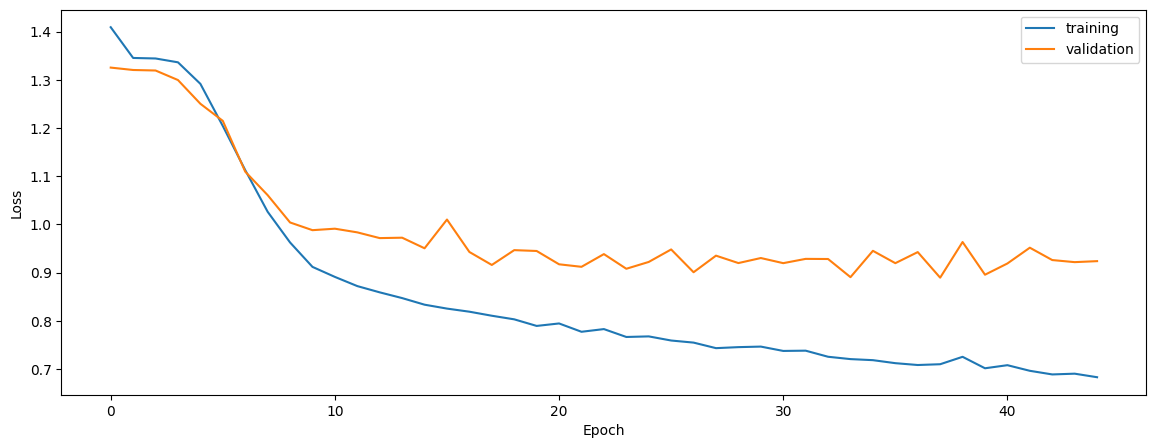

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6996339777559014
0.6611452910553716
0.7063162474292043


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6996339777559014
0.6611452910553716
0.7063162474292043


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6972384175473036
0.6790710090763481
0.7179356270810211


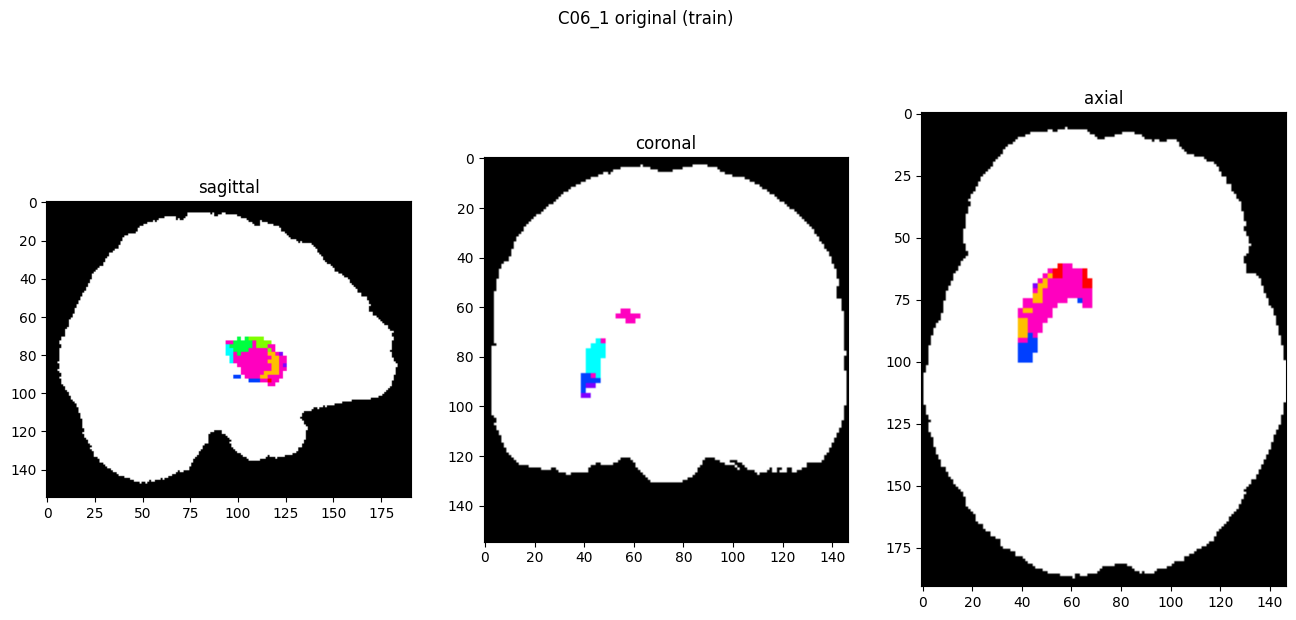

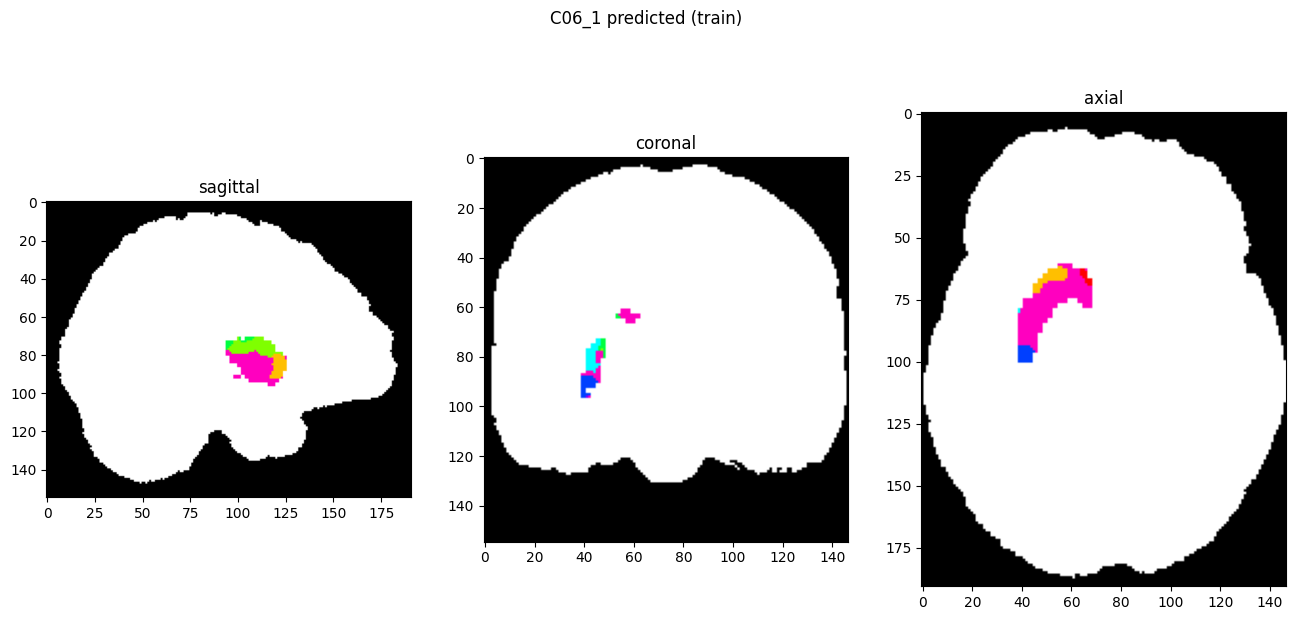

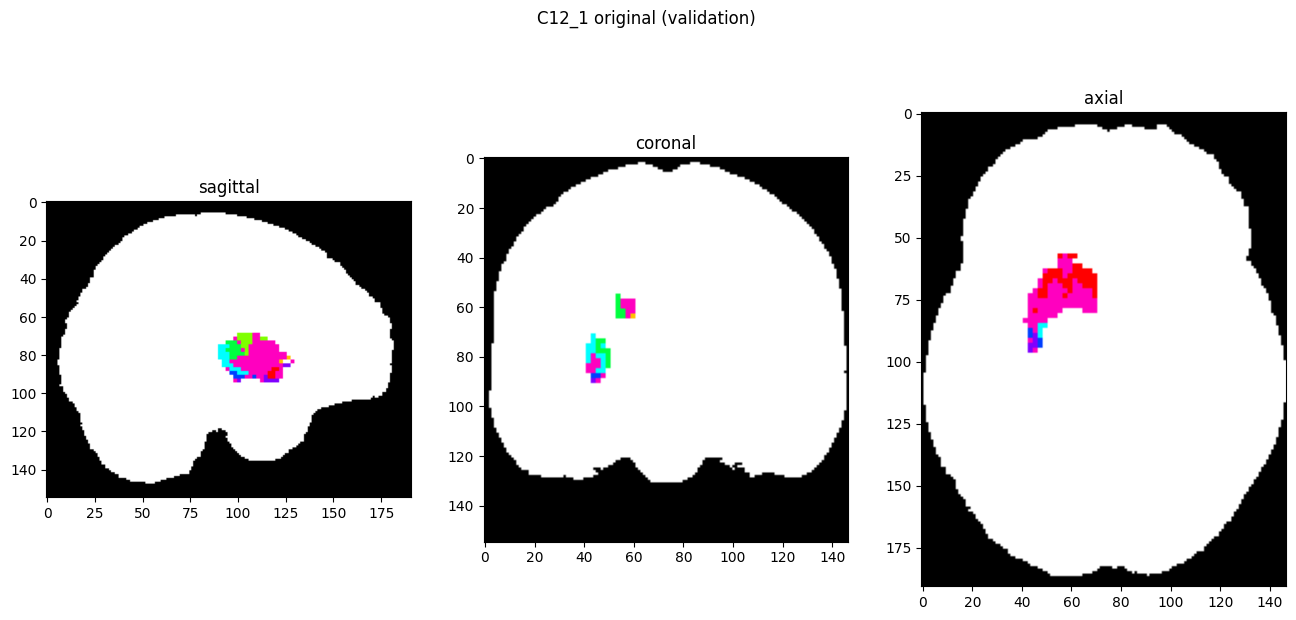

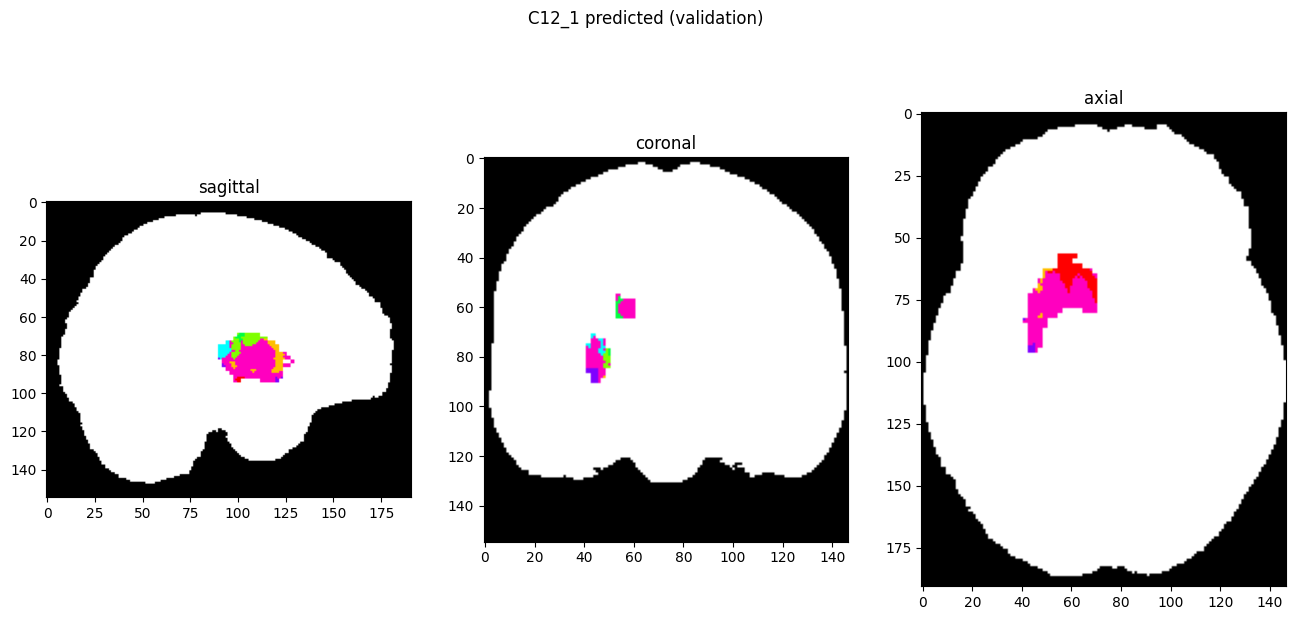

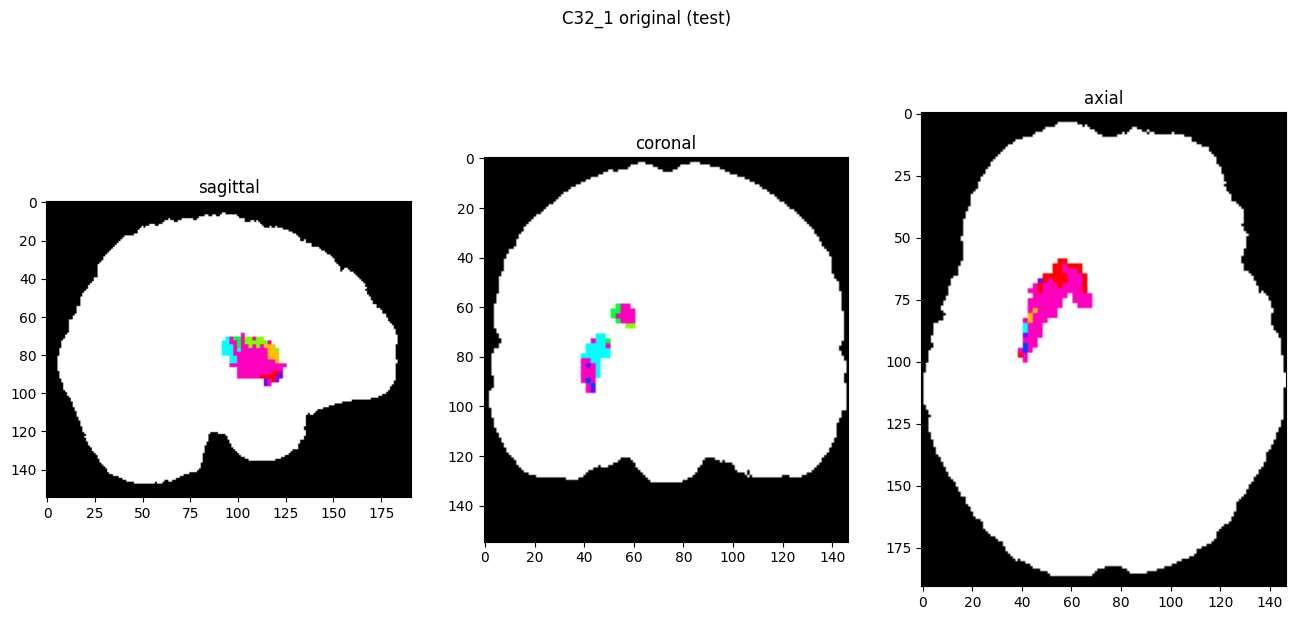

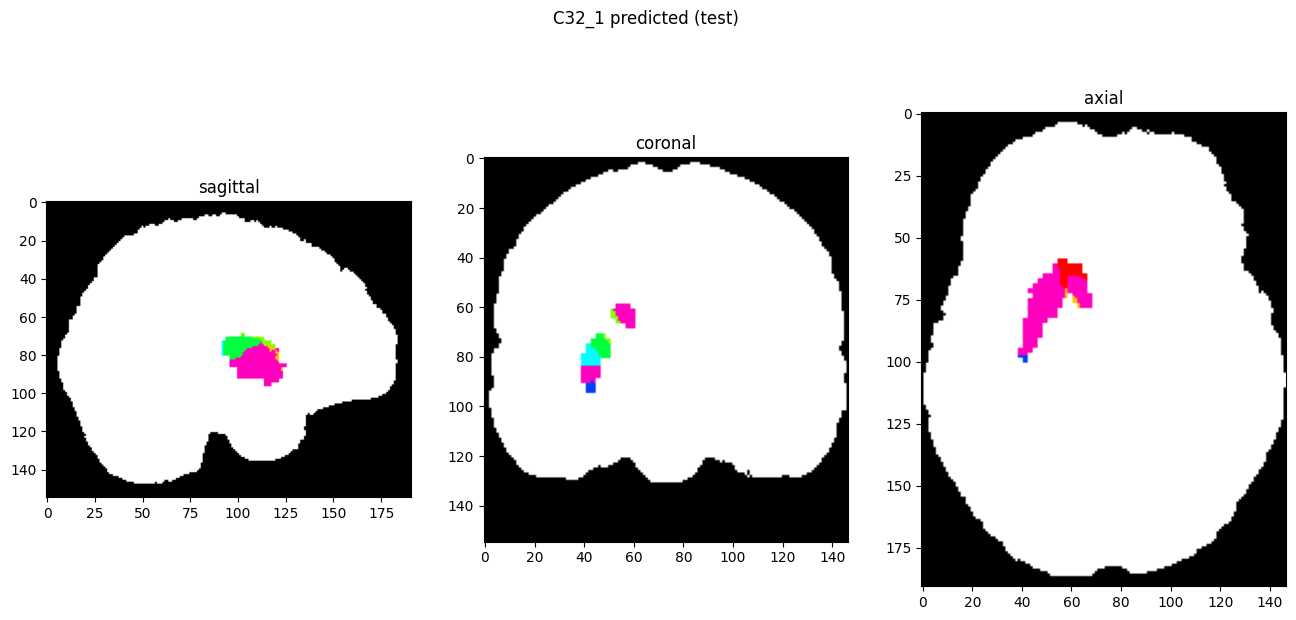

In [10]:
showResults(model, gen, threshold=0)